In [149]:
library(devtools)
source_url("https://raw.githubusercontent.com/aygoldberg/PIC-seq/master/scripts/metacell_functions.r")
source_url("https://raw.githubusercontent.com/aygoldberg/PIC-seq/master/scripts/pic_parser.r")
library(GEOquery)
library(googlesheets4)
library(googledrive)
library(metacell)
library(ggplot2)
library(ggrepel)
library(dplyr)
library(gridExtra)
library(tidyverse)
library(grid)
library(tgstat)
library(tgconfig)
library(gridExtra)
library(SingleCellExperiment)
library(ComplexHeatmap)
library(grid)
library(GOfuncR)
library(cowplot)
library(shades)
library(circlize)
library(tglkmeans)
library(ggplot2)
library(tidyverse)
library(tgstat)
library(tgconfig)
library(gridExtra)
library(SingleCellExperiment)
library(babelgene)
library(zellkonverter)
library(liana)
library(ComplexHeatmap)
library(grid)
library(cowplot)
library(R.utils)
library(rstatix) 
library(RVAideMemoire)
library(cluster)   
library(factoextra) 
library(ggpmisc)
library(glmGamPoi)
library(MASS)
library(clusterProfiler)
library(msigdbr)

ℹ SHA-1 hash of file is "bda7f06ee7b168c0be4c723ee15644ab99e6421e"
ℹ SHA-1 hash of file is "9adfcccbce4f308dad9fb0d084241583dbbeb5b8"


In [150]:
pic_ll_to_pair = function(mc_id, mat_id, pic_umis, mc_a, mc_b, alpha, bins = length(alpha), reg = 1e-6, markers = NULL) {

        sc_cl = scdb_mc(mc_id); sc_mat = scdb_mat(mat_id)
        umis = read_large_umis(mat_id, cells = names(sc_cl@mc))
	if (is.null(markers)) {
                mc_prof = sc_cl@e_gc[setdiff(rownames(sc_cl@e_gc), bad_genes),]
	} else {
                mc_prof = mc_compute_unnorm_fp(sc_cl@mc, umis[setdiff(markers, bad_genes),])
        }
	mc_prof = sweep(mc_prof, 2, colSums(mc_prof), "/")
        p_a = mc_prof[, mc_a] + reg
        p_b = mc_prof[, mc_b] + reg
        p = sweep(p_a, 2, alpha, "*") + sweep(p_b, 2, 1 - alpha, "*")
        u = pic_umis[rownames(mc_prof), ]
        ll = colSums(u * log(p)) + apply(u, 2, stirlings_lmulti)
	ll
}

In [151]:
simulate_doublets = function(mat_id, a_cells, b_cells, k, comb=NA, numis = 1000, sim_genes=NA){
    cells = union(a_cells, b_cells)
    umis = read_large_umis(mat_id, cells = cells)
    if (is.na(sim_genes)){
        sim_genes = rownames(umis)
    }
    umis = umis[sim_genes,]
    alpha = runif(k)
    numis_a = round(alpha * numis)
    numis_b = numis - numis_a
    sim_cells_a = sample(a_cells, size = k, replace = T)
    sim_cells_b = sample(b_cells, size = k, replace = T)
    cell_sizes = colSums(umis)
    a_modifier = pmax(ceiling(numis_a / cell_sizes[sim_cells_a]), 1)
    b_modifier = pmax(ceiling(numis_b / cell_sizes[sim_cells_b]), 1)
    a_umis = .downsamp_var(sweep(umis[,sim_cells_a], 2, a_modifier, "*"), numis_a, replace=F)
    colnames(a_umis) = paste0("Sim", 1:k)
    b_umis = .downsamp_var(sweep(umis[,sim_cells_b], 2, b_modifier, "*"), numis_b, replace=F)
    colnames(b_umis) = paste0("Sim", 1:k)
    simpic_umis = a_umis + b_umis
    list(sim_umis = simpic_umis, info = data.frame(sim.1=sim_cells_a, 
                                                   sim.2=sim_cells_b, 
                                                   alpha.1=alpha, 
                                                   alpha.2=1-alpha, 
                                                   row.names = paste0("Sim", 1:k)))
}

In [152]:
estimate_mixing = function(sim_umis, alpha, genes, fname, numis, normalize = T) {
	
	sim_n = sweep(sim_umis, 2, colSums(sim_umis), "/") * numis
	if (normalize) { us = sim_n} else {us = sim_umis}
	alpha_fit = cv.glmnet(t(us[genes,]), alpha)
	alpha_tag = predict(alpha_fit, newx = t(us[genes,]), s = "lambda.min")
	i = which(alpha_fit$lambda == alpha_fit$lambda.min)
	if (!is.null(fname)) {
		png(fname, height=1000, width=1000)
		#par(bg = bg, fg = fg, col.axis = col.axis, col.lab = col.lab)
	}
	lim = c(0,1)
	plot(alpha_tag, alpha, pch = 20, , col = "gray", axes = F, xlab = "", ylab = "", cex = 2, xlim = lim, ylim = lim,
		main = round(1 - alpha_fit$cvm[i] / var(alpha),4))
	axis(1); axis(2); abline(coef = c(0,1), lwd = 2)
        if (!is.null(fname)) {dev.off()}
	alpha_fit
}


run_pic_seq = function(mc_id, mat_id, pic_umis, a_cells, b_cells, 
	lr_features, mle_features, fname, numis = 1000, 
	lr_k = 2e4, bad_genes = c(), comb = NULL, reg = 1e-4, downsample=T) {
	
	sc_cl = scdb_mc(mc_id); sc_mat = scdb_mc(mat_id); 
	cells = union(a_cells, b_cells)
	lr_features = setdiff(lr_features, bad_genes)
	mle_features = setdiff(mle_features, bad_genes)
	if (is.null(comb)) {comb = rep("X", length(cells)); names(comb) = cells}

	message("Simulating ", lr_k, " PIC (numis = ", numis, ") for alpha estimation")
	lr_res = simulate_doublets(mat_id, a_cells, b_cells, lr_k, comb, numis = rep(numis, lr_k))
	sim_umis = lr_res$sim_umis; sim_info = lr_res$info
	sim_cells = names(which(colSums(sim_umis) == numis))
	sim_umis = sim_umis[,sim_cells]; sim_info = sim_info[sim_cells,]

        message("Building LR for alpha")
	alpha_fit = estimate_mixing(sim_umis, sim_info$alpha.1, lr_features, fname, numis)

	message("Running MLE on PIC")
	
	if (downsample) {
		ds = .downsamp(pic_umis, numis)
	} else {
		ds = pic_umis
	}
	real_t_frac = predict(alpha_fit, newx = t(ds[lr_features,]), s = "lambda.min")
	alpha = real_t_frac[colnames(ds),]
	good_cells = intersect(colnames(ds), names(which(alpha >= 0 & alpha <= 1)))
	mle_res = assign_pics_to_singlets(mc_id, mat_id, ds[,good_cells], a_cells, b_cells, alpha[good_cells],
		verbose=T, bad_genes = bad_genes, markers = mle_features, reg = reg)

	t_mc = mle_res$a_mc; dc_mc = mle_res$b_mc
	names(t_mc) = rownames(mle_res); names(dc_mc) = rownames(mle_res)
	mle_res$alpha = alpha[good_cells]

        mle_res
}


In [153]:
# Rerun
if(!dir.exists("scdb")) dir.create("scdb/")
scdb_init("scdb/", force_reinit=T)
if(!dir.exists("neutrophil_pic_figs")) dir.create("neutrophil_pic_figs/")
scfigs_init("neutrophil_pic_figs/")
if(!dir.exists("annotations")) dir.create("annotations/")

initializing scdb to scdb/



# Loading and preprocessing

In [154]:
bad_genes = union(read_lines('annotations/kinetics_filtered_genes.txt'), 
                  read_lines('annotations/neutrophil_filtered_genes.txt'))

In [155]:
# Rerun

message("Loading singlets dataset:")
sc_mat = scdb_mat("merged_neutrophil_epithelial_mat")
message("Loaded a UMI matrix of ", sc_mat@ncells, " cells and ", sc_mat@ngenes, " genes.")
#sin_2d = scdb_mc2d("kinetics_2dproj")
sin_cl = scdb_mc("merged_neutrophil_epithelial_mc"); sin_mat = scdb_mat("merged_neutrophil_epithelial_mat")
lfp = log2(sin_cl@mc_fp)
message("Loaded a metacell object of ", length(sin_cl@mc), " singlets. Total of ", length(table(sin_cl@mc)), " metacells.")

Loading singlets dataset:

Loaded a UMI matrix of 12523 cells and 36893 genes.

Loaded a metacell object of 12494 singlets. Total of 307 metacells.



In [8]:
message("Loading PIC dataset:")
db_mat = scdb_mat("all_pics")
message("Loaded ", db_mat@ncells, " PICs")

Loading PIC dataset:

Loaded 14849 PICs



In [9]:
alive_pics = db_mat@cells[db_mat@cell_metadata$pct_counts_mt < 30]

In [10]:
cd45_mle_res = read.delim("annotations/cd45_mle_res.txt", stringsAsFactors = F, row.names=1)

In [11]:
cd45_good_pics = read_lines("annotations/cd45_good_pics_final.txt")

In [12]:
cd45_mle_res = cd45_mle_res[cd45_good_pics,]

In [13]:
cd45_neutrophil_pics = rownames(cd45_mle_res[cd45_mle_res$b_mc %in% 626:628,])

In [14]:
length(cd45_neutrophil_pics)

[1] 183

In [15]:
neutrophil_pics = intersect(db_mat@cells[db_mat@cell_metadata$Cell_type == "EPCAM-LY6G"], alive_pics)

In [16]:
length(neutrophil_pics)

[1] 3266

In [17]:
ticks = c(100, 300, 500, 750, 1000, 2000, 10000)

Saving 6.67 x 6.67 in image


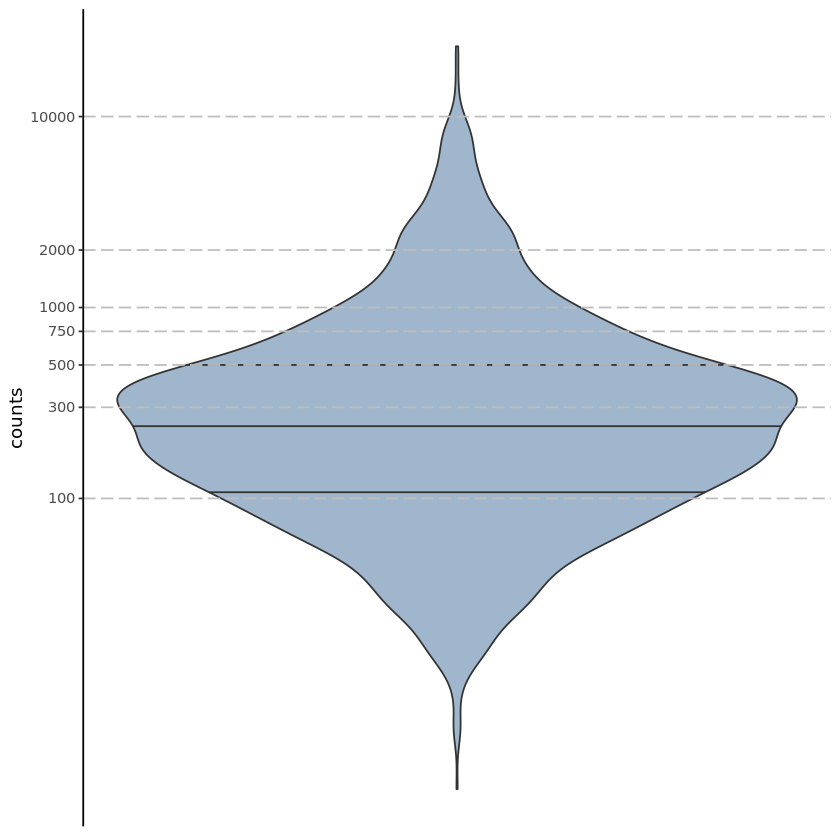

In [18]:
# Supp a

data.frame(counts=db_mat@cell_metadata[rownames(db_mat@cell_metadata) %in% neutrophil_pics &
                                       rownames(db_mat@cell_metadata) %in% alive_pics, 'total_counts']) %>%
    ggplot(aes(x=1, y=counts)) +
    geom_violin(fill='slategray3', draw_quantiles = c(0.25, 0.5, 0.75)) +
    #geom_jitter(alpha=0.2, color='slategray') +
    scale_y_log10(breaks=ticks) +
    geom_hline(yintercept = ticks, linetype='longdash', color='gray') +
    #geom_label(data = data.frame(n=ticks), aes(y=n, label=n)) +
    theme(axis.title.x = element_blank(), axis.line.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x=element_blank())

ggsave("final_figs/supp4/umi_counts.pdf")

In [19]:
neutrophil_pics = intersect(db_mat@cells[db_mat@cells %in% cd45_neutrophil_pics | 
                                         db_mat@cell_metadata$Cell_type == "EPCAM-LY6G"],
                            alive_pics)

In [20]:
length(neutrophil_pics)

[1] 3449

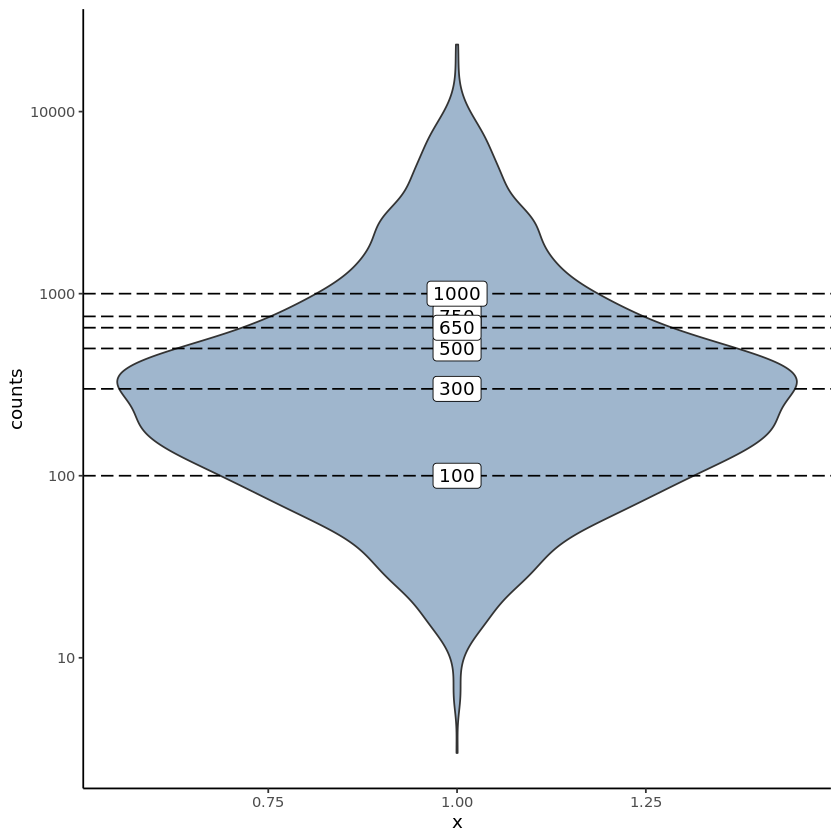

In [21]:
data.frame(counts=db_mat@cell_metadata[neutrophil_pics, 'total_counts']) %>%
    ggplot(aes(x=1, y=counts)) +
    geom_violin(fill='slategray3') +
    #geom_jitter(alpha=0.2, color='slategray') +
    scale_y_log10() +
    geom_hline(yintercept = c(100, 300, 500, 650, 750, 1000), linetype='longdash') +
    geom_label(data = data.frame(n=c(100, 300, 500, 750, 650, 1000)), aes(y=n, label=n))

In [22]:
mat2 = scm_sub_mat(db_mat, cells = neutrophil_pics)

In [23]:
mat2@cell_metadata$Cell_type %>% table

.
EPCAM-CD45 EPCAM-LY6G 
       183       3266 

# PIC qc

In [24]:
nms = c(rownames(mat2@mat), rownames(mat2@ignore_gmat))

In [25]:
hb_genes = grep("^Hb[abdg]", nms, v=T)

In [26]:
cat(hb_genes, sep='", "')

Hba-a1", "Hba-a2", "Hba-ps4", "Hba-x", "Hbb-bh1", "Hbb-bh2", "Hbb-bs", "Hbb-bt", "Hbb-y

In [27]:
hb_gene_sums = colSums(mat2@mat[c("Hba-a1", "Hba-a2", "Hba-ps4", "Hba-x", "Hbb-bh1", "Hbb-bh2", "Hbb-bs", "Hbb-bt", "Hbb-y"),])
print(sum(hb_gene_sums > 0))
print(sum(hb_gene_sums > 1))
print(sum(hb_gene_sums > 2))
print(sum(hb_gene_sums > 3))
print(sum(hb_gene_sums > 4))
print(sum(hb_gene_sums > 5))
print(sum(hb_gene_sums > 6))
print(sum(hb_gene_sums > 7))
print(sum(hb_gene_sums > 8))
print(sum(hb_gene_sums > 9))
print(sum(hb_gene_sums > 10))

[1] 314
[1] 91
[1] 36
[1] 20
[1] 15
[1] 12
[1] 12
[1] 10
[1] 9
[1] 9
[1] 9


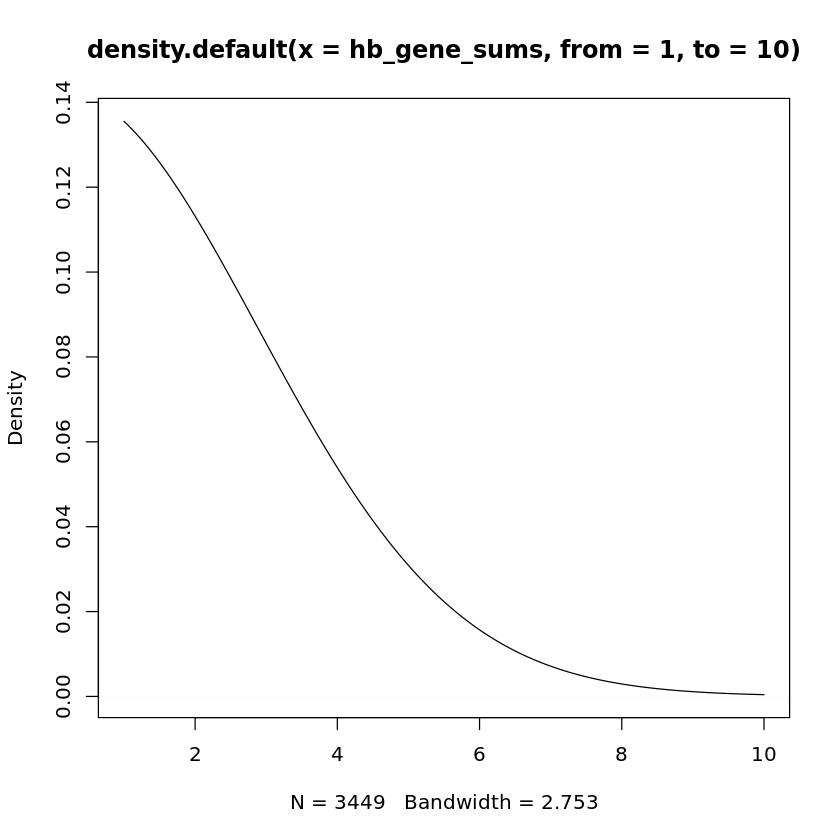

In [28]:
plot(density(hb_gene_sums, from=1, to = 10))

In [29]:
erythrocytes = names(which(hb_gene_sums > 3))

In [30]:
umis_per_cell =  colSums(mat2@mat)
mt_genes = unique(grep("^mt-", nms, v=T))
mt_percent = colSums(mat2@mat[mt_genes,]) / umis_per_cell
print(sum(mt_percent > 0.0))
print(sum(mt_percent > 0.1))
print(sum(mt_percent > 0.2))
print(sum(mt_percent > 0.3))
print(sum(mt_percent > 0.4))
print(sum(mt_percent > 0.5))
print(sum(mt_percent > 0.6))
print(sum(mt_percent > 0.7))
print(sum(mt_percent > 0.8))
print(sum(mt_percent > 0.9))

[1] 3432
[1] 2273
[1] 731
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0


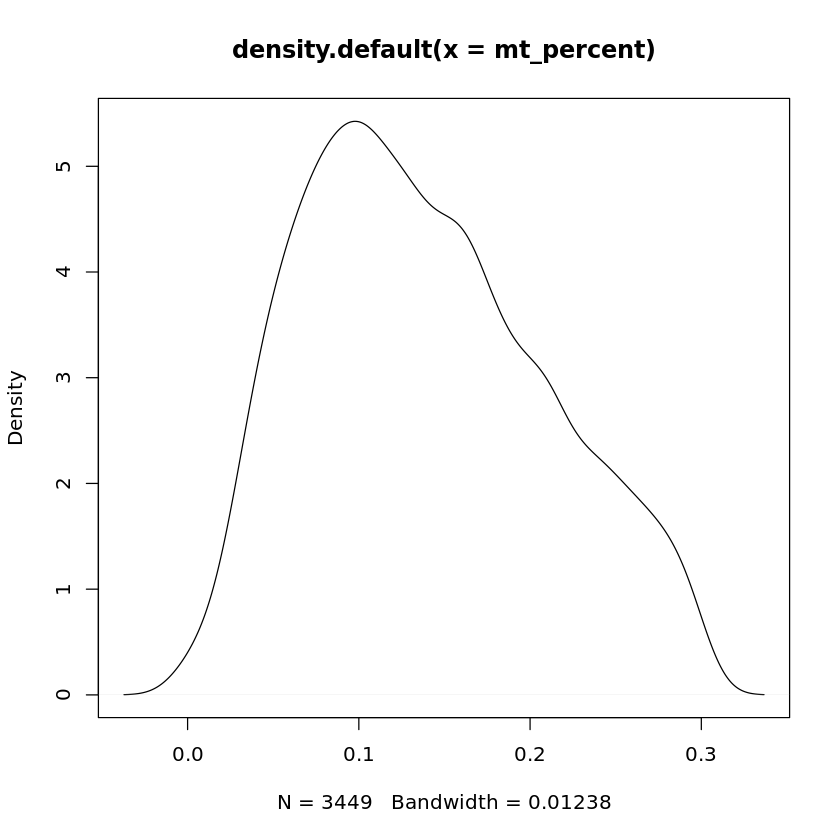

In [31]:
plot(density(mt_percent))

In [32]:
dead_cells = names(which(mt_percent > 0.3))

In [33]:
non_neutrophil_genes = c("C1qa", "C1qb", "C1qc", "Itgax", "Clec10a", "Mrc1", "H2-Ea",
                        "Cd3g", "Cd3e", "Cd3d", "Trbc2", "Trac", "Trdc", "Thy1", "Cd8b1", "Cd8a")

In [34]:
cat(non_neutrophil_genes, sep=', ')

C1qa, C1qb, C1qc, Itgax, Clec10a, Mrc1, H2-Ea, Cd3g, Cd3e, Cd3d, Trbc2, Trac, Trdc, Thy1, Cd8b1, Cd8a

In [35]:
non_neutrophil_genes = non_neutrophil_genes[non_neutrophil_genes %in% rownames(mat2@mat)]

In [36]:
non_neutrophil_gene_sums = colSums(mat2@mat[non_neutrophil_genes,])
print(sum(non_neutrophil_gene_sums > 0))
print(sum(non_neutrophil_gene_sums > 1))
print(sum(non_neutrophil_gene_sums > 2))
print(sum(non_neutrophil_gene_sums > 3))
print(sum(non_neutrophil_gene_sums > 4))
print(sum(non_neutrophil_gene_sums > 5))
print(sum(non_neutrophil_gene_sums > 6))
print(sum(non_neutrophil_gene_sums > 7))
print(sum(non_neutrophil_gene_sums > 8))
print(sum(non_neutrophil_gene_sums > 9))
print(sum(non_neutrophil_gene_sums > 10))

[1] 319
[1] 109
[1] 58
[1] 43
[1] 31
[1] 25
[1] 20
[1] 15
[1] 10
[1] 9
[1] 9


In [37]:
non_neutrophil_pics = names(which(non_neutrophil_gene_sums > 3))

In [38]:
mat2@mat[non_neutrophil_genes, non_neutrophil_pics] %>% as.matrix %>% t

,C1qa,C1qb,C1qc,Itgax,Clec10a,Mrc1,H2-Ea,Cd3g,Cd3e,Cd3d,Trbc2,Trac,Trdc,Thy1,Cd8b1,Cd8a
AB522_E20,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0
AB522_G16,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0
AB523_M10,11,16,3,1,0,0,0,0,0,0,0,0,0,0,0,0
AB538_G17,4,13,7,0,0,6,0,0,0,0,0,0,0,0,0,0
AB538_F17,1,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0
AB524_C2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0
AB524_O11,2,7,1,0,0,1,0,0,0,0,0,0,0,0,0,0
AB524_A4,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0
AB365_H1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0
AB365_D6,4,8,4,0,2,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
endo_genes = c('Pecam1', 'Cdh5', 'Col4a1', 'Col4a2', 'Cd36')

In [40]:
endo_gene_sums = colSums(mat2@mat[endo_genes,])
print(sum(endo_gene_sums > 0))
print(sum(endo_gene_sums > 1))
print(sum(endo_gene_sums > 2))
print(sum(endo_gene_sums > 3))
print(sum(endo_gene_sums > 4))
print(sum(endo_gene_sums > 5))
print(sum(endo_gene_sums > 6))
print(sum(endo_gene_sums > 7))
print(sum(endo_gene_sums > 8))
print(sum(endo_gene_sums > 9))
print(sum(endo_gene_sums > 10))

[1] 380
[1] 155
[1] 100
[1] 86
[1] 75
[1] 64
[1] 60
[1] 56
[1] 51
[1] 45
[1] 42


In [41]:
endo_pics = names(which(endo_gene_sums > 3))

In [42]:
mat2@mat[endo_genes, endo_pics] %>% as.matrix %>% t

,Pecam1,Cdh5,Col4a1,Col4a2,Cd36
AB522_G21,19,15,67,40,13
AB522_A12,2,5,30,17,0
AB522_C16,14,8,67,35,0
AB522_H19,6,1,9,6,0
AB522_F4,12,14,43,24,12
AB522_A24,11,8,65,34,12
AB522_I12,4,2,5,0,8
AB522_H7,1,1,9,3,0
AB523_I23,2,0,9,5,0
AB523_C2,1,4,0,2,1


In [43]:
small_cells = mat2@cells[mat2@cell_metadata$total_counts < 0]

In [44]:
bad_cells = endo_pics %>% union(non_neutrophil_pics) %>% union(dead_cells) %>% union(erythrocytes) %>% union(small_cells)

In [45]:
message("endothelial UMIs - ", length(endo_pics))
message("erythrocytes UMIs - ", length(erythrocytes))
message("other non-neutrophil UMIs - ", length(non_neutrophil_pics))
message("total - ", length(bad_cells))

endothelial UMIs - 86

erythrocytes UMIs - 20

other non-neutrophil UMIs - 43

total - 142



In [46]:
mat2@cell_metadata[bad_cells, 'Cell_type'] %>% table

.
EPCAM-CD45 EPCAM-LY6G 
         9        133 

In [47]:
mat2@cell_metadata[setdiff(mat2@cells, bad_cells), 'Cell_type'] %>% table

.
EPCAM-CD45 EPCAM-LY6G 
       174       3133 

In [48]:
165 + 686

[1] 851

In [49]:
clean_mat = scm_sub_mat(db_mat, cells = setdiff(mat2@cells, bad_cells))

In [50]:
clean_mat

An object of class tgScMat, stat type umi.
3307 cells by 36946 genes. median cell content 252.

In [51]:
scdb_add_mat('neutrophil_clean_pics', clean_mat)

# PIC-seq preprocessing

In [156]:
bad_genes = union(read_lines('annotations/kinetics_filtered_genes.txt'), 
                  read_lines('annotations/neutrophil_filtered_genes.txt'))

In [157]:
# Rerun

message("Loading singlets dataset:")
sc_mat = scdb_mat("merged_neutrophil_epithelial_mat")
message("Loaded a UMI matrix of ", sc_mat@ncells, " cells and ", sc_mat@ngenes, " genes.")
#sin_2d = scdb_mc2d("kinetics_2dproj")
sin_cl = scdb_mc("merged_neutrophil_epithelial_mc"); sin_mat = scdb_mat("merged_neutrophil_epithelial_mat")
lfp = log2(sin_cl@mc_fp)
message("Loaded a metacell object of ", length(sin_cl@mc), " singlets. Total of ", length(table(sin_cl@mc)), " metacells.")

message("Loading PIC dataset:")
db_mat = scdb_mat("neutrophil_clean_pics")
message("Loaded ", db_mat@ncells, " PICs")


Loading singlets dataset:

Loaded a UMI matrix of 12523 cells and 36893 genes.

Loaded a metacell object of 12494 singlets. Total of 307 metacells.

Loading PIC dataset:

Loaded 3307 PICs



In [158]:
db_mat@cell_metadata$Cell_type %>% table

.
EPCAM-CD45 EPCAM-LY6G 
       174       3133 

In [159]:
#rerun
sin_cl@color_key <- data.frame(group=unique(sin_cl@annots), color=unique(sin_cl@colors))

In [160]:
#rerun
color_scheme = sin_cl@color_key
color2name = as.vector(color_scheme$group); names(color2name) = color_scheme$color
name2color = as.vector(color_scheme$color); names(name2color) = color_scheme$group
sin_names = color2name[ sin_cl@colors[ sin_cl@mc]]; names(sin_names) = names(sin_cl@mc)

In [161]:
cat(paste(1:length(unique(sin_cl@annots)), unique(sin_cl@annots), sep=" - "), sep="\n")

1 - Neut Ptgs2
2 - MHCII Neut
3 - Neut Socs3
4 - TAN1
5 - TAN2
6 - Cystatin high
7 - Young Cystatin high
8 - Tumor cells
9 - Progenitor 1
10 - Alveolar
11 - Progenitor 2
12 - HS
13 - Basal
14 - MyoLum
15 - Myoepithelial


In [162]:
neutrophil_order = c(7, 6, 2, 1, 3:5)
epithelial_order = c(9, 11, 10, 12, 15, 13, 14, 8)

In [163]:
#rerun
order_index = c(neutrophil_order, epithelial_order)

In [164]:
#rerun
cell_order = unique(sin_cl@annots)[order_index]

In [165]:
unique(sin_cl@annots)[!unique(sin_cl@annots) %in% cell_order]

character(0)

In [166]:
cond_order = c("tumor", "normal")

In [167]:
age_order = c("10d", "3w", "6w", "8w", "10w", "12w")

In [168]:
age_dict = c(10, 3*7, 6*7, 8*7, 10*7, 12*7)
names(age_dict) = age_order

In [169]:
group.colors = unique(sin_cl@colors)[order_index]
names(group.colors) = cell_order

In [170]:
sin_stats = sc_mat@cell_metadata[names(sin_cl@mc),]

In [171]:
cat(cell_order, sep = '", "')

Young Cystatin high", "Cystatin high", "MHCII Neut", "Neut Ptgs2", "Neut Socs3", "TAN1", "TAN2", "Progenitor 1", "Progenitor 2", "Alveolar", "HS", "Myoepithelial", "Basal", "MyoLum", "Tumor cells

In [172]:
#rerun
epithelial_pops = c("Progenitor 1", "Progenitor 2", "Alveolar", "HS", "Myoepithelial", "Basal", "MyoLum", "Tumor cells")
immune_pops = c("Young Cystatin high", "Cystatin high", "MHCII Neut", "Neut Ptgs2", "Neut Socs3", "TAN1", "TAN2")

epithelial_mc = which(color2name[ sin_cl@colors] %in% epithelial_pops)
immune_mc = which(color2name[ sin_cl@colors] %in% immune_pops)
bad_mc = setdiff(names(table(sin_cl@mc)), union(epithelial_mc, immune_mc))

epithelial_cells = names(sin_names)[ sin_names %in% epithelial_pops]
immune_cells = names(sin_names)[ sin_names %in% immune_pops]

message(length(immune_cells), " immune cells and ", length(epithelial_cells), " epithelial cells")

737 immune cells and 11757 epithelial cells



In [22]:
mcell_gset_from_mc_markers(gset_id="merged_neutrophil_epithelial_markers", mc_id="merged_neutrophil_epithelial_mc")

In [68]:
markers = names(scdb_gset('merged_neutrophil_epithelial_markers')@gene_set) # Set of features used for the Metacell clustering
bad_genes = union(grep("Gm[0-9].|Mir|-ps|Rpl|Rps|Jchain|Ftl1|Hsp|Rn18s-rs5|Actb|Tuba|Rik", sin_mat@genes, v=T),
                  union(read_lines('annotations/kinetics_filtered_genes.txt'), 
                        read_lines('annotations/neutrophil_filtered_genes.txt')))
markers = markers[!markers %in% bad_genes]

In [173]:
# Rerun
lr_features = read.table("annotations/neutrophil_lr_features.txt", h=F, stringsAsFactors = F)[[1]]
mle_features = read.table("annotations/neutrophil_mle_features.txt", h=F, stringsAsFactors = F)[[1]]

message("Chose ", length(lr_features), " features")
message("Chose ", length(mle_features), " features")

Chose 1058 features

Chose 581 features



# Simulated PICs - for size threshold

In [70]:
k = 10000
numis = sample(100:1000, k, replace=T)

res = simulate_doublets(mat_id = "merged_neutrophil_epithelial_mat", 
                        a_cells = epithelial_cells, 
                        b_cells = immune_cells, 
                        k = k, 
                        numis = numis)

sim_umis = res$sim_umis; sim_info = res$info
head(sim_info)


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


,sim.1,sim.2,alpha.1,alpha.2
,<chr>,<chr>,<dbl>,<dbl>
Sim1,AB527_P17,AB266_L19,0.88609531,0.1139047
Sim2,AB400_A17,AB435_F6,0.68491722,0.3150828
Sim3,AB170_L7,AB396_N2,0.03386386,0.9661361
Sim4,AB415_I2,AB129_O17,0.45815842,0.5418416
Sim5,AB327_J6,AB435_E12,0.60933170,0.3906683
Sim6,AB322_O4,AB435_G17,0.84923282,0.1507672


In [71]:
sim_cells = names(which(colSums(sim_umis) == numis))
sim_umis = sim_umis[,sim_cells]; sim_info = sim_info[sim_cells,]
sim_alpha = sim_info$alpha.1; names(sim_alpha) = rownames(sim_info)


sim_mle_res = assign_pics_to_singlets(mc_id = "merged_neutrophil_epithelial_mc", 
                                      mat_id = "merged_neutrophil_epithelial_mat", 
                                      pic_umis = sim_umis, 
                                      a_cells = epithelial_cells, 
                                      b_cells = immune_cells, 
                                      alpha = sim_alpha,
                                      verbose=T, 
                                      bad_genes = bad_genes, 
                                      markers = mle_features, 
                                      reg = 1e-4)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



In [72]:
sim_mle_res$alpha = sim_alpha

In [73]:
sim_mle_res$sin_alpha = with(sim_mle_res, round(alpha))
sim_mle_res$sin_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, sim_alpha, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$diff = with(sim_mle_res, ll - sin_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [74]:
sim_mle_res$imm_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 1, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$imm_diff = with(sim_mle_res, ll - imm_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [75]:
sim_mle_res$epi_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 0, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$epi_diff = with(sim_mle_res, ll - epi_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [76]:
sim_mle_res$lower_diff = pmin(sim_mle_res$epi_diff, sim_mle_res$imm_diff)

In [77]:
scdb_add_mat("neutrophil_simpic_sizevar", sim_umis)

In [78]:
write.table(sim_info, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_sim_info_varsizes.txt")
write.table(sim_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_sim_mle_res_varsizes.txt")

In [42]:
#Rerun
sim_info = read.delim("annotations/neutrophil_sim_info_varsizes.txt", row.names = 1)
sim_mle_res = read.delim("annotations/neutrophil_sim_mle_res_varsizes.txt", row.names = 1)

In [43]:
sim_umis = scdb_mat("neutrophil_simpic_sizevar")

In [44]:
sim_umis = sim_umis[,rownames(sim_info)]

100

150

200

250

300

350

400

450

500

550

600

650

700

750

800

850

900

950

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


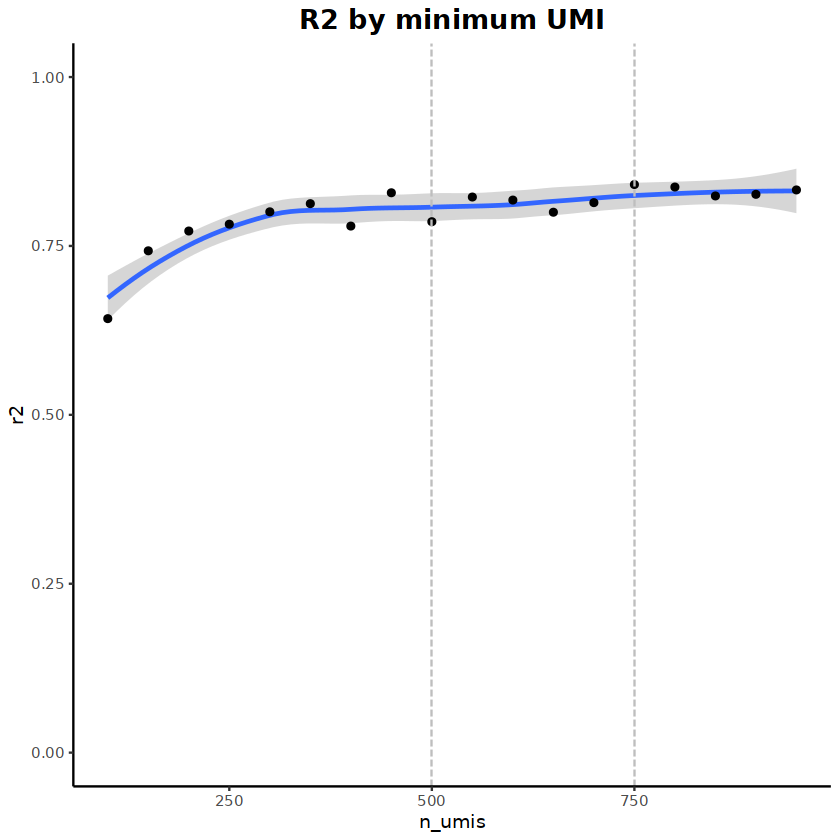

In [45]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 50), r2=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 50)){
    message(x)
    rel_cells = names(sim_sizes)[sim_sizes >= x & sim_sizes < (x + 50)]
    alpha_fit = estimate_mixing(sim_umis = sim_umis[,rel_cells], 
                                alpha = sim_info[rel_cells,'alpha.1'], 
                                genes = lr_features, 
                                fname = "./temp.pdf",
                                sim_sizes[rel_cells],
                                normalize = T)
    alpha_tag = predict(alpha_fit, newx = t(sim_umis[lr_features,]), s = "lambda.min")[,1]
    i = which(alpha_fit$lambda == alpha_fit$lambda.min)
    r2 = round(1 - alpha_fit$cvm[i] / var(sim_info[rel_cells,'alpha.1']),4)    
    df[as.character(x),'r2'] = r2
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    #melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=r2)) +
    geom_smooth(method='loess', show.legend = F) +
    #scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0,1)) +
    labs(title = 'R2 by minimum UMI') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp4/r2_bysize.pdf")

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


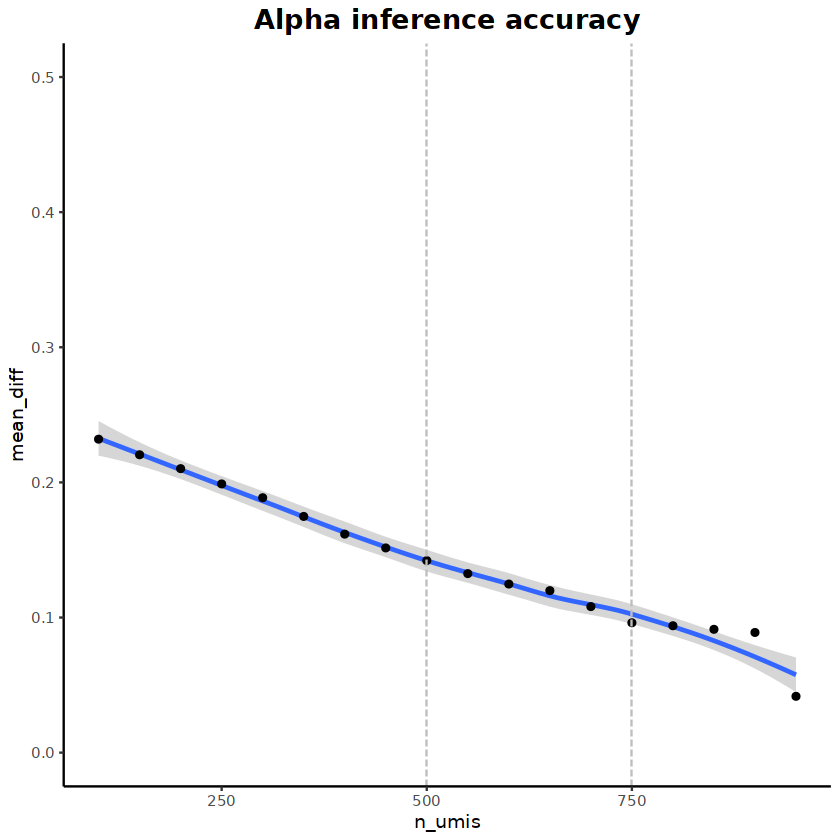

In [47]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 50), mean_diff=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 50)){
    rel_cells = names(sim_sizes)[sim_sizes >= x & sim_sizes < (x + 50)]
    df[as.character(x),'mean_diff'] = mean(abs(sim_info[rel_cells, 'alpha.1'] - alpha_tag[rel_cells]))
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    #melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=mean_diff)) +
    geom_smooth(method='loess', show.legend = F) +
    #scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0,0.5)) +
    labs(title = 'Alpha inference accuracy') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp4/alpha_inference_bysize.pdf")

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


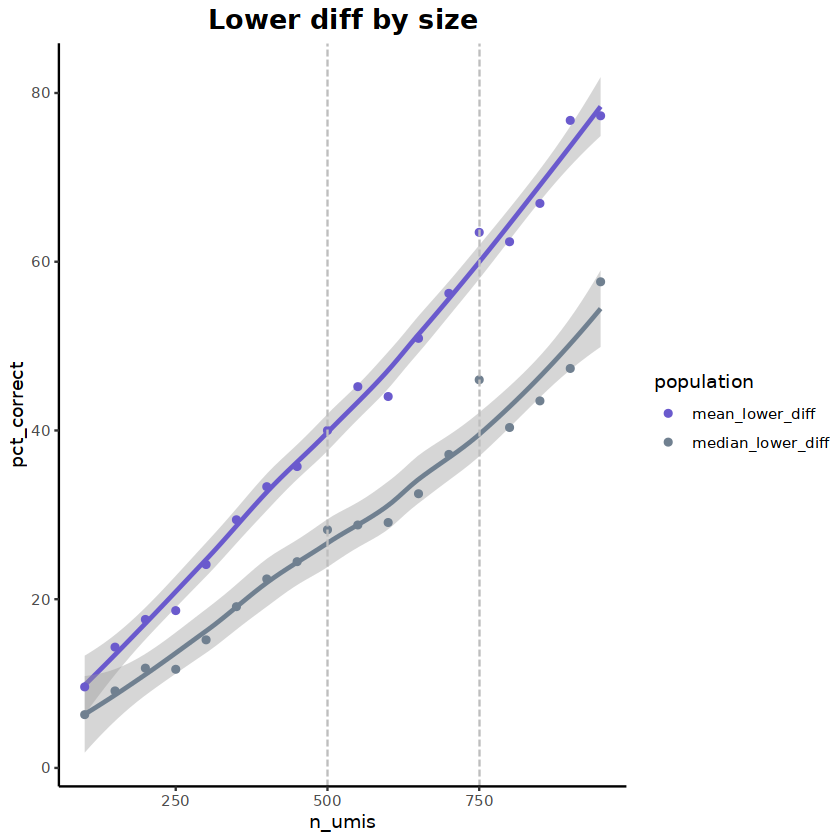

In [48]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 50), mean_lower_diff=NA, median_lower_diff=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 50)){
    rel_cells = names(sim_sizes)[sim_sizes >= x & sim_sizes < (x + 50)]
    if (length(rel_cells) > 50){
        df[as.character(x),'mean_lower_diff'] = mean(sim_mle_res[rel_cells, 'lower_diff'])
        df[as.character(x),'median_lower_diff'] = median(sim_mle_res[rel_cells, 'lower_diff'])
    }
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=pct_correct, color=population, group=population)) +
    geom_smooth(method='loess', show.legend = F) +
    scale_color_manual(values=c('slateblue', 'slategray')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    #scale_y_continuous(limits = c(0,1)) +
    labs(title = 'Lower diff by size') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp4/lowerdiff_bysize.pdf")

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


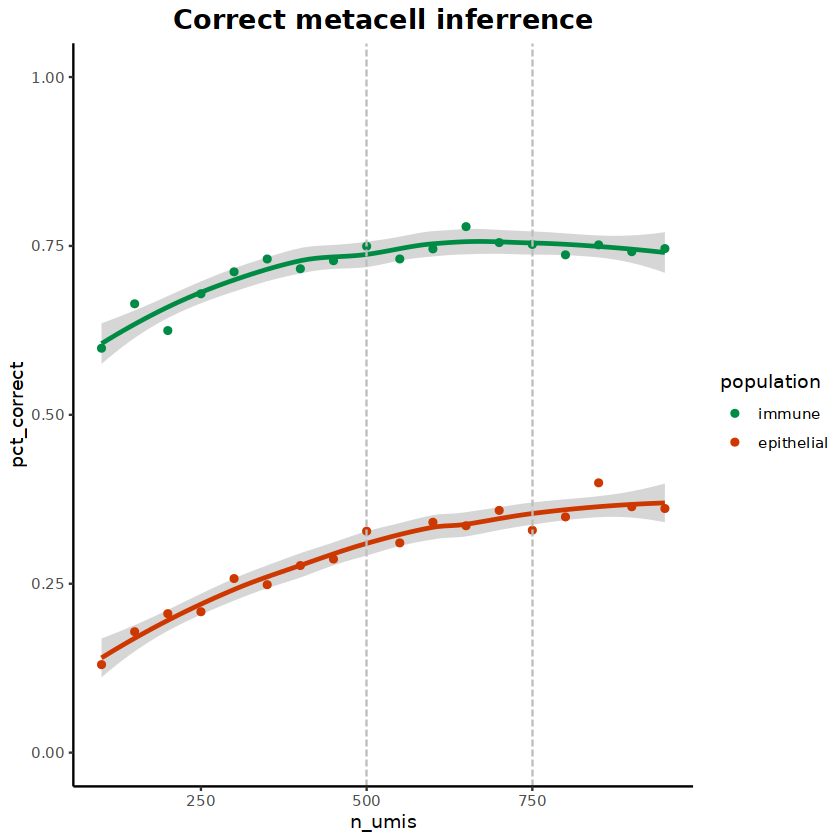

In [49]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 50), immune=NA, epithelial=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 50)){
    rel_cells = names(sim_sizes)[sim_sizes >= x & sim_sizes < (x + 50)]
    if (length(rel_cells) > 10){
        df[as.character(x),'epithelial'] = sum(sin_cl@mc[sim_info[rel_cells, 'sim.1']] == sim_mle_res[rel_cells, 'a_mc']) / length(rel_cells)
        df[as.character(x),'immune'] = sum(sin_cl@mc[sim_info[rel_cells, 'sim.2']] == sim_mle_res[rel_cells, 'b_mc']) / length(rel_cells)
    }
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=pct_correct, color=population, group=population)) +
    geom_smooth(method='loess', show.legend = F) +
    scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0,1)) +
    labs(title = 'Correct metacell inferrence') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp4/mc_inference_bysize.pdf")

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


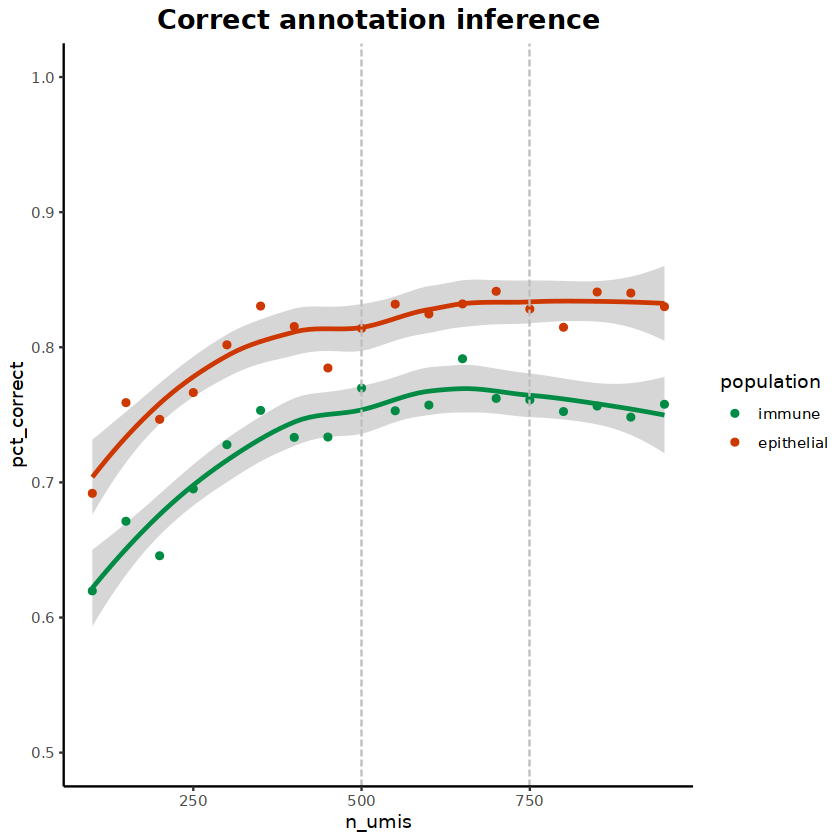

In [50]:
sim_sizes = colSums(sim_umis)

df = data.frame(size=seq(100, 999, 50), immune=NA, epithelial=NA) %>% column_to_rownames('size')

for (x in seq(100, 999, 50)){
    rel_cells = names(sim_sizes)[sim_sizes >= x & sim_sizes < (x + 50)]
    if (length(rel_cells) > 10){
        df[as.character(x),'epithelial'] = sum(sin_cl@annots[sin_cl@mc[sim_info[rel_cells, 'sim.1']]] == sin_cl@annots[sim_mle_res[rel_cells, 'a_mc']]) / length(rel_cells)
        df[as.character(x),'immune'] = sum(sin_cl@annots[sin_cl@mc[sim_info[rel_cells, 'sim.2']]] == sin_cl@annots[sim_mle_res[rel_cells, 'b_mc']]) / length(rel_cells)
    }
}

df %>%
    drop_na %>%
    rownames_to_column('n_umis') %>%
    mutate(n_umis=as.numeric(n_umis)) %>%
    melt(id.vars = 'n_umis', variable.name = 'population', value.name = 'pct_correct') %>%
    ggplot(aes(x=n_umis, y=pct_correct, color=population, group=population)) +
    geom_smooth(method='loess', show.legend = F) +
    scale_color_manual(values=c('springgreen4', 'orangered3')) +
    geom_point() +
    geom_vline(xintercept = c(500, 750), color='gray', linetype='longdash') +
    scale_y_continuous(limits = c(0.5,1)) +
    labs(title = 'Correct annotation inference') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))

ggsave("final_figs/supp4/annot_inference_bysize.pdf")

In [51]:
pic_sizes = colSums(db_mat@mat)

In [52]:
pic_sizes = pic_sizes[pic_sizes >= 100]

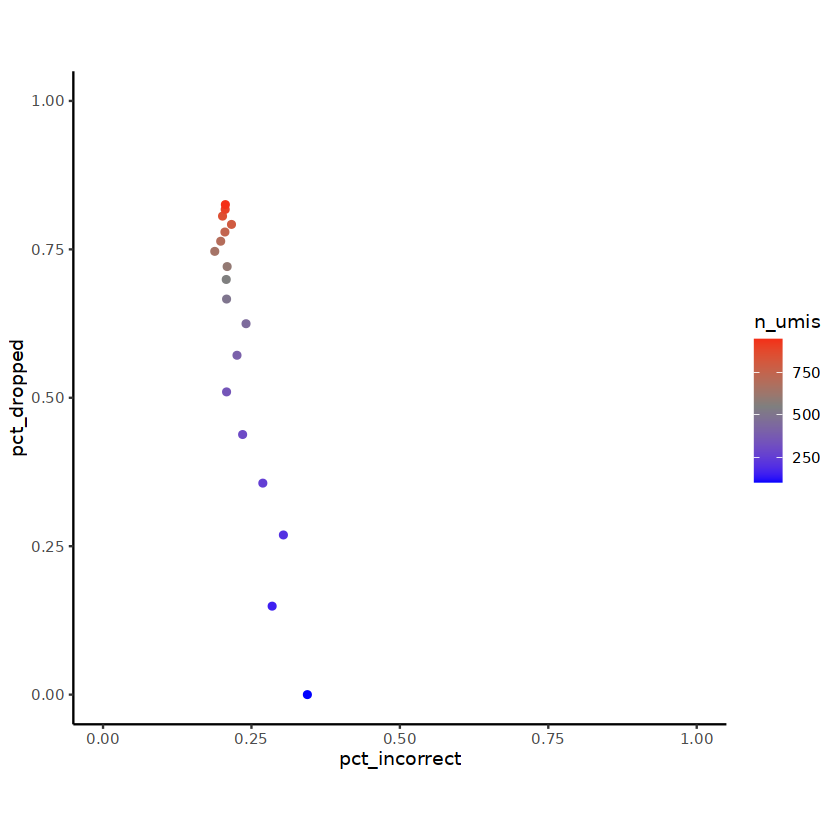

In [53]:
df %>% 
    mutate(pct_incorrect = 1-rowMeans(.)) %>%
    mutate(pct_dropped=sapply(as.numeric(rownames(.)), function(x){sum(pic_sizes < x) / length(pic_sizes)})) %>%
    rownames_to_column('n_umis') %>% 
    mutate(n_umis=as.numeric(n_umis)) %>%
ggplot(aes(y=pct_dropped, x=pct_incorrect, color=n_umis)) +
    #geom_smooth(method = 'lm', color='black', se=F) +
    geom_point() +
    scale_color_gradient2(low = 'blue', mid = 'gray50', high = 'red', midpoint = 550) +
    scale_x_continuous(limits = c(0, 1)) +
    scale_y_continuous(limits = c(0, 1)) +
    coord_fixed()

Warning message:
“attributes are not identical across measure variables; they will be dropped”


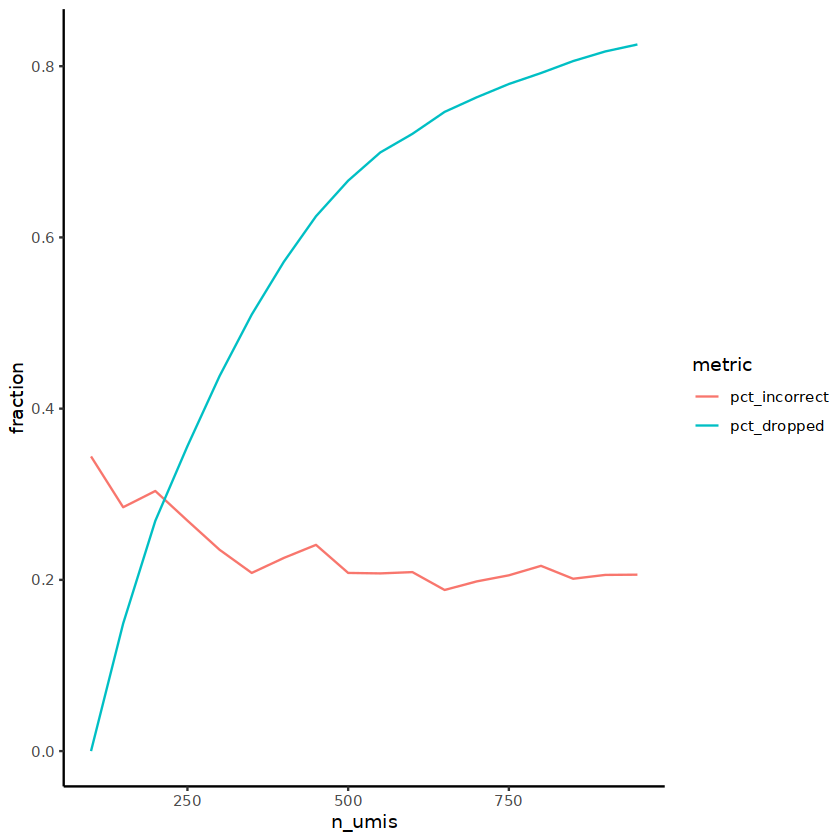

In [54]:
df %>% 
    mutate(pct_incorrect = 1-rowMeans(.)) %>%
    mutate(pct_dropped=sapply(as.numeric(rownames(.)), function(x){sum(pic_sizes < x) / length(pic_sizes)})) %>%
    rownames_to_column('n_umis') %>% 
    mutate(n_umis=as.numeric(n_umis)) %>%
    select(n_umis, pct_incorrect, pct_dropped) %>% 
    melt(id.vars = 'n_umis', variable.name = 'metric', value.name = 'fraction') %>%
ggplot(aes(x=n_umis,y=fraction, color=metric)) +
    #geom_smooth(method = 'lm', color='black', se=F) +
    geom_line()

# Simulated PICs - for QC

simulate_doublets = function(mat_id, a_cells, b_cells, k, numis = 1000, inflation=50, sim_genes=NA){
    cells = union(a_cells, b_cells)
    umis = read_large_umis(mat_id, cells = cells)
    if (is.na(sim_genes)){
        sim_genes = rownames(umis)
    }
    alpha = runif(k)
    numis_a = round(alpha * numis)
    numis_b = numis - numis_a
    sim_cells_a = sample(a_cells, size = k, replace = T)
    sim_cells_b = sample(b_cells, size = k, replace = T)
    a_umis = .downsamp_var(umis[sim_genes,sim_cells_a] * inflation, numis_a, replace=F)
    colnames(a_umis) = paste0("Sim", 1:k)
    b_umis = .downsamp_var(umis[sim_genes,sim_cells_b] * inflation, numis_b, replace=F)
    colnames(b_umis) = paste0("Sim", 1:k)
    simpic_umis = a_umis + b_umis
    list(sim_umis = simpic_umis, info = data.frame(sim.1=sim_cells_a, 
                                                   sim.2=sim_cells_b, 
                                                   alpha.1=alpha, 
                                                   alpha.2=1-alpha, 
                                                   row.names = paste0("Sim", 1:k)))
}

In [92]:
numis = 500; k = 10000
res = simulate_doublets(mat_id = "merged_neutrophil_epithelial_mat", 
                        a_cells = epithelial_cells, 
                        b_cells = immune_cells, 
                        k = k, 
                        numis = rep(numis, k))

sim_umis = res$sim_umis; sim_info = res$info
head(sim_info)


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


,sim.1,sim.2,alpha.1,alpha.2
,<chr>,<chr>,<dbl>,<dbl>
Sim1,AB005_D16,AB431_B12,0.6163680,0.3836320
Sim2,AB161_H13,AB525_E19,0.6479556,0.3520444
Sim3,AB401_E9,AB540_M15,0.7719012,0.2280988
Sim4,AB139_O17,AB435_L22,0.2469691,0.7530309
Sim5,AB401_F5,AB147_G15,0.3587932,0.6412068
Sim6,AB401_K2,AB526_A16,0.6777374,0.3222626


In [93]:
sim_cells = names(which(colSums(sim_umis) == numis))
sim_umis = sim_umis[,sim_cells]; sim_info = sim_info[sim_cells,]
sim_alpha = sim_info$alpha.1; names(sim_alpha) = rownames(sim_info)


sim_mle_res = assign_pics_to_singlets(mc_id = "merged_neutrophil_epithelial_mc", 
                                      mat_id = "merged_neutrophil_epithelial_mat", 
                                      pic_umis = sim_umis, 
                                      a_cells = epithelial_cells, 
                                      b_cells = immune_cells, 
                                      alpha = sim_alpha,
                                      verbose=T, 
                                      bad_genes = bad_genes, 
                                      markers = mle_features, 
                                      reg = 1e-4)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



In [94]:
sim_mle_res$alpha = sim_alpha

In [95]:
sim_mle_res$sin_alpha = with(sim_mle_res, round(alpha))
sim_mle_res$sin_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, sim_alpha, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$diff = with(sim_mle_res, ll - sin_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [96]:
sim_mle_res$imm_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 1, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$imm_diff = with(sim_mle_res, ll - imm_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [97]:
sim_mle_res$epi_ll = with(sim_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              sim_umis[,rownames(sim_mle_res)], a_mc, b_mc, 0, reg = 1e-4, 
                                              markers = mle_features))
sim_mle_res$epi_diff = with(sim_mle_res, ll - epi_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [98]:
sim_mle_res$lower_diff = pmin(sim_mle_res$epi_diff, sim_mle_res$imm_diff)

In [99]:
write.table(sim_info, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_sim_info_final.txt")
write.table(sim_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_sim_mle_res_final.txt")

In [55]:
#Rerun
sim_info = read.delim("annotations/neutrophil_sim_info_final.txt", row.names = 1)
sim_mle_res = read.delim("annotations/neutrophil_sim_mle_res_final.txt", row.names = 1)

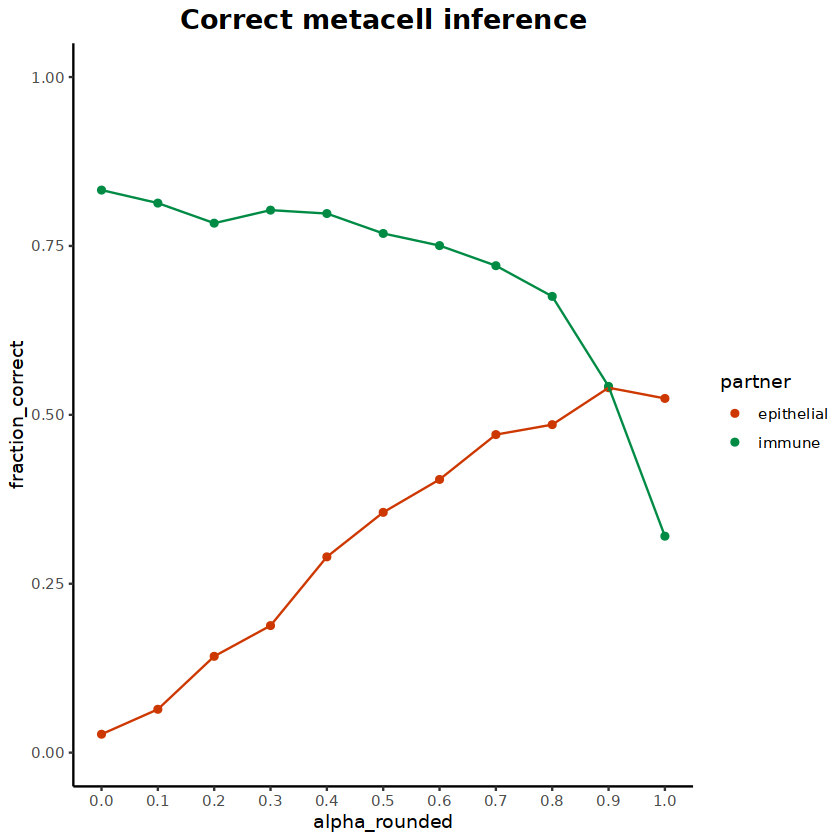

In [56]:
data.frame(alpha_rounded=round(sim_info$alpha.1, 1),
           correct_epithelial=sin_cl@mc[sim_info$sim.1] == sim_mle_res$a_mc,
           correct_immune=sin_cl@mc[sim_info$sim.2] == sim_mle_res$b_mc) %>%
    group_by(alpha_rounded) %>%
    summarise(epithelial = sum(correct_epithelial) / n(), immune = sum(correct_immune) / n()) %>%
    melt(id.vars = 'alpha_rounded', variable.name = 'partner', value.name = 'fraction_correct') %>%
    ggplot(aes(x=alpha_rounded, color=partner, y=fraction_correct, groups=partner)) +
    geom_point() +
    geom_line(show.legend = F) +
    scale_color_manual(values=c('orangered3', 'springgreen4')) +
    scale_y_continuous(limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0,1,0.1)) +
    labs(title = 'Correct metacell inference') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))


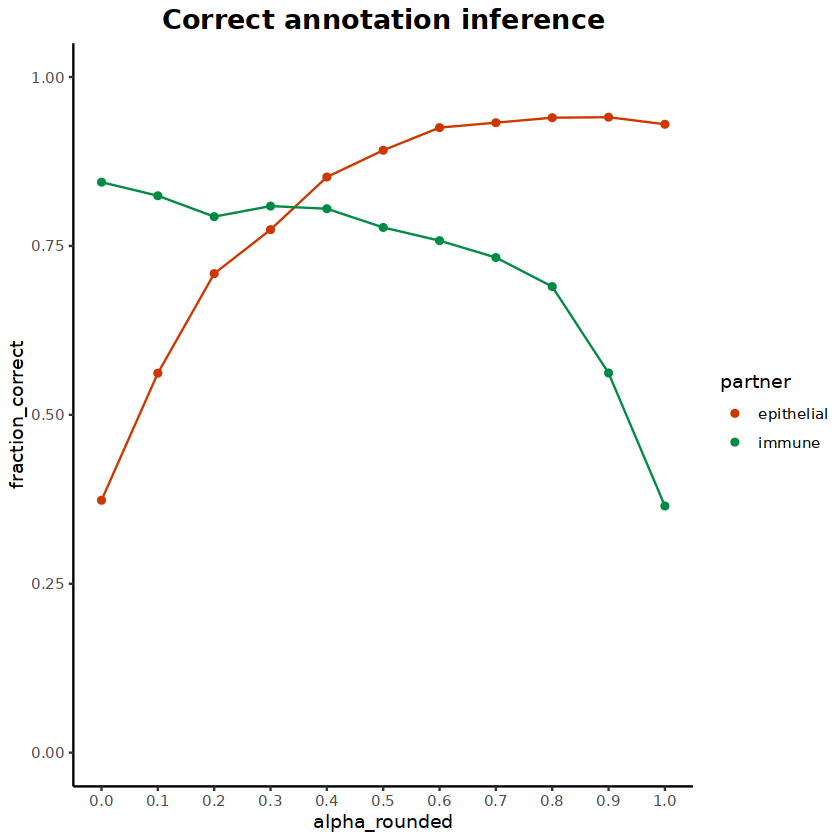

In [57]:
data.frame(alpha_rounded=round(sim_info$alpha.1, 1),
           correct_epithelial=sin_cl@annots[sin_cl@mc[sim_info$sim.1]] == sin_cl@annots[sim_mle_res$a_mc],
           correct_immune=sin_cl@annots[sin_cl@mc[sim_info$sim.2]] == sin_cl@annots[sim_mle_res$b_mc]) %>%
    group_by(alpha_rounded) %>%
    summarise(epithelial = sum(correct_epithelial) / n(), immune = sum(correct_immune) / n()) %>%
    melt(id.vars = 'alpha_rounded', variable.name = 'partner', value.name = 'fraction_correct') %>%
    ggplot(aes(x=alpha_rounded, color=partner, y=fraction_correct, groups=partner)) +
    geom_point() +
    geom_line(show.legend = F) +
    scale_color_manual(values=c('orangered3', 'springgreen4')) +
    scale_y_continuous(limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0,1,0.1)) +
    labs(title = 'Correct annotation inference') +
    theme(plot.title = element_text(size=16, hjust = 0.5, face = 'bold'))


In [58]:
epithelial_confu = table(sin_cl@mc[ as.vector( sim_info$sim.1)], sim_mle_res$a_mc)
epithelial_n = epithelial_confu / rowSums(epithelial_confu)
immune_confu = table(sin_cl@mc[ as.vector( sim_info$sim.2)], sim_mle_res$b_mc)
immune_n = immune_confu / rowSums(immune_confu)

zlim: 0<>1



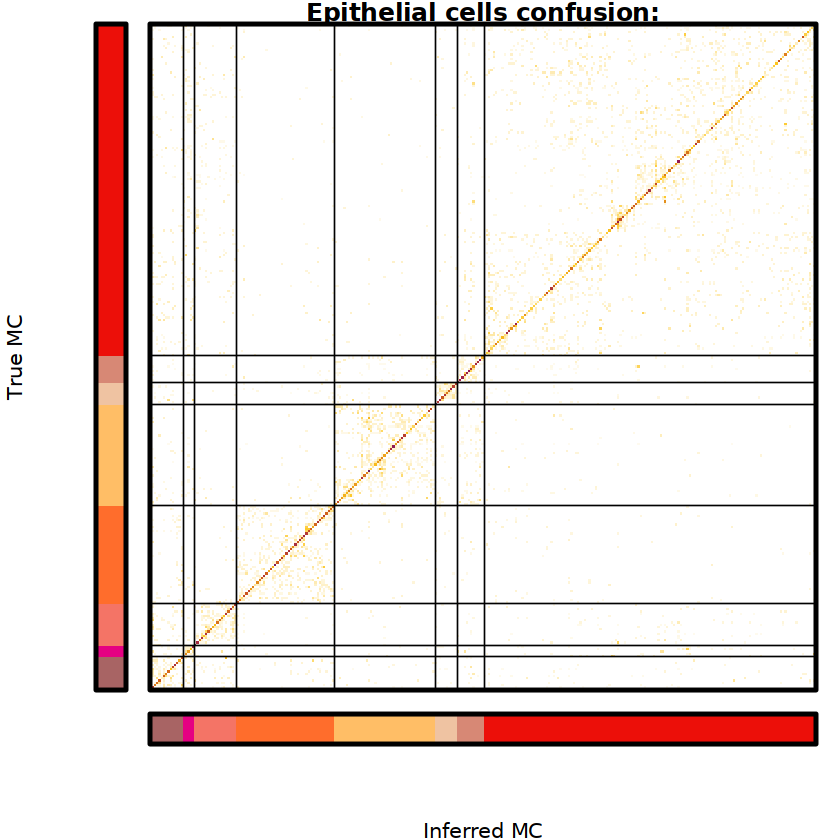

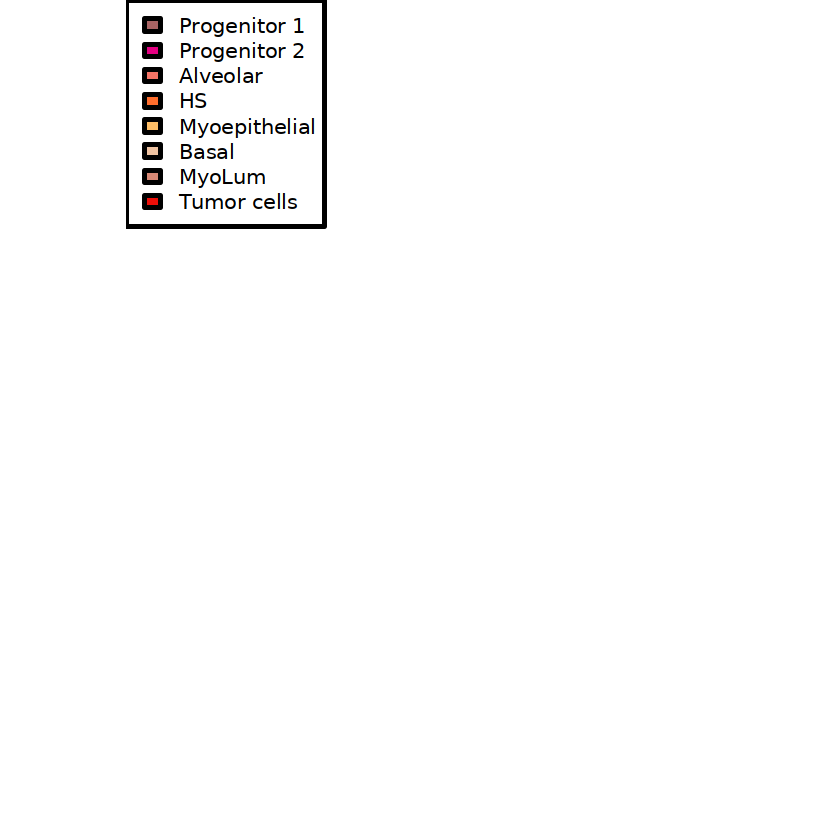

In [59]:
grad = colorRampPalette(c("white", "#FDC51D", "#CA531C", "#951851", "#36277A", "black"))(1000)
epithelial_cls = factor(color2name[ sin_cl@colors[ as.numeric(rownames(epithelial_n))]], levels = cell_order)
par(mar = rep(1,4), lwd = 3, fig = c(0.15,1,0.15,1))
image.2(epithelial_n, zlim = c(0,1), col = grad, annotate = "none", hct = epithelial_cls, vct = epithelial_cls); box()
title("Epithelial cells confusion:")
par(fig = c(0.15,1,0,0.15), mar = c(4,1,0,1), new = T)
image(matrix(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], xlab = "Inferred MC"); box()
par(fig = c(0,0.15,0.15,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], ylab = "True MC"); box()
par(mar = rep(0,4), fig = c(0.15,1,0.15,1))
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="topleft",
       legend=epithelial_pops,
       fill=group.colors[epithelial_pops],
       xpd = TRUE
       )

In [60]:
png("final_figs/supp4/epithelial_confusion.png", width = 2000, height = 2000)
par(mar = rep(1,4), lwd = 3, fig = c(0.05,1,0.05,1))
image.2(epithelial_n, zlim = c(0,1), col = grad, annotate = "none", hct = epithelial_cls, vct = epithelial_cls); box()
#title("Epithelial cells confusion:")
par(fig = c(0.05,1,0,0.05), mar = c(4,1,0,1), new = T)
image(matrix(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], xlab = "Inferred MC"); box()
par(fig = c(0,0.05,0.05,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], ylab = "True MC"); box()
dev.off()

zlim: 0<>1



png 
  2

zlim: 0<>1



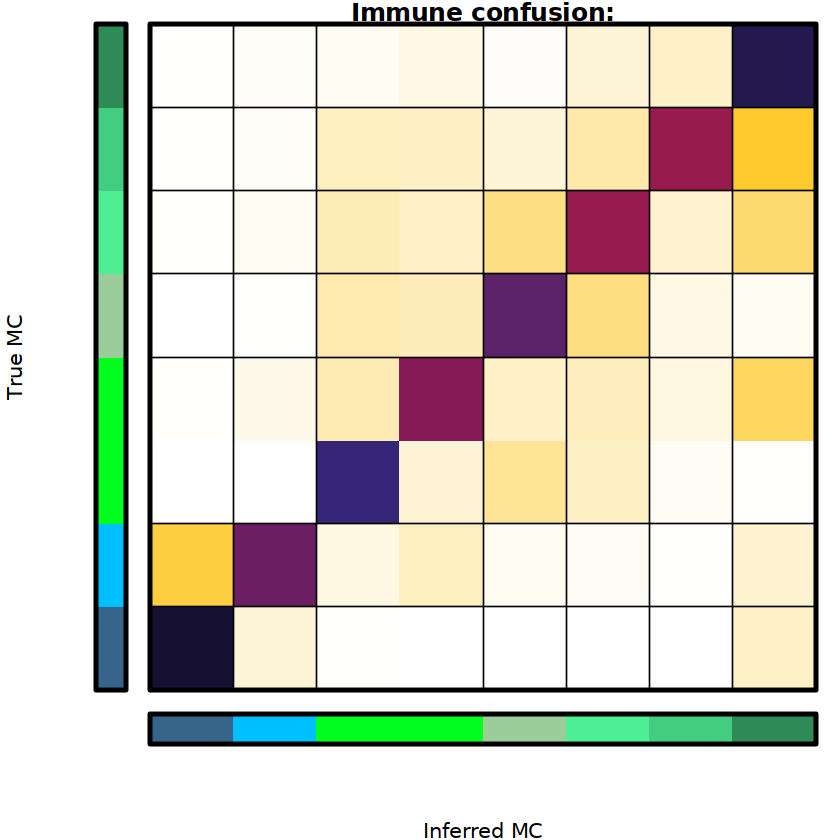

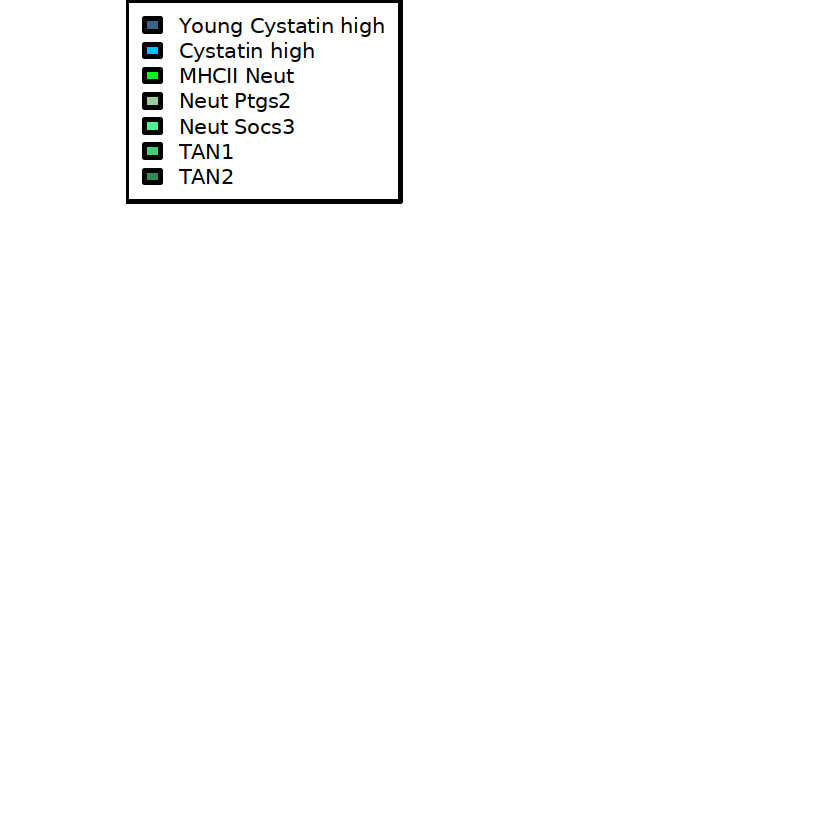

In [61]:
immune_cls = factor(color2name[ sin_cl@colors[ as.numeric(rownames(immune_n))]], levels = cell_order)
par(mar = rep(1,4), lwd = 3, fig = c(0.15,1,0.15,1))
image.2(immune_n, zlim = c(0,1), col = grad, annotate = "none", hct = immune_cls,vct = immune_cls); box()
title("Immune confusion:")
par(fig = c(0.15,1,0,0.15), mar = c(4,1,0,1), new	= T)
image(matrix(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], xlab = "Inferred MC");box()
par(fig = c(0,0.15,0.15,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], ylab = "True MC"); box()
par(mar = rep(0,4), fig = c(0.15,1,0.15,1))
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="topleft",
       legend=immune_pops,
       fill=group.colors[immune_pops],
       xpd = TRUE
       )

In [62]:
png("final_figs/supp4/immune_confusion.png", width = 2000, height = 2000)
par(mar = rep(1,4), lwd = 3, fig = c(0.05,1,0.05,1))
image.2(immune_n, zlim = c(0,1), col = grad, annotate = "none", hct = immune_cls, vct = immune_cls); box()
#title("immune cells confusion:")
par(fig = c(0.05,1,0,0.05), mar = c(4,1,0,1), new = T)
image(matrix(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], xlab = "Inferred MC"); box()
par(fig = c(0,0.05,0.05,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], ylab = "True MC"); box()
dev.off()

zlim: 0<>1



png 
  2

In [63]:
alpha_fit = estimate_mixing(sim_umis = sim_umis, 
                            alpha = sim_info$alpha.1, 
                            genes = lr_features, 
                            fname = "./temp.pdf",
                            500,
                            normalize = T)
alpha_tag = predict(alpha_fit, newx = t(sim_umis[lr_features,]), s = "lambda.min")[,1]

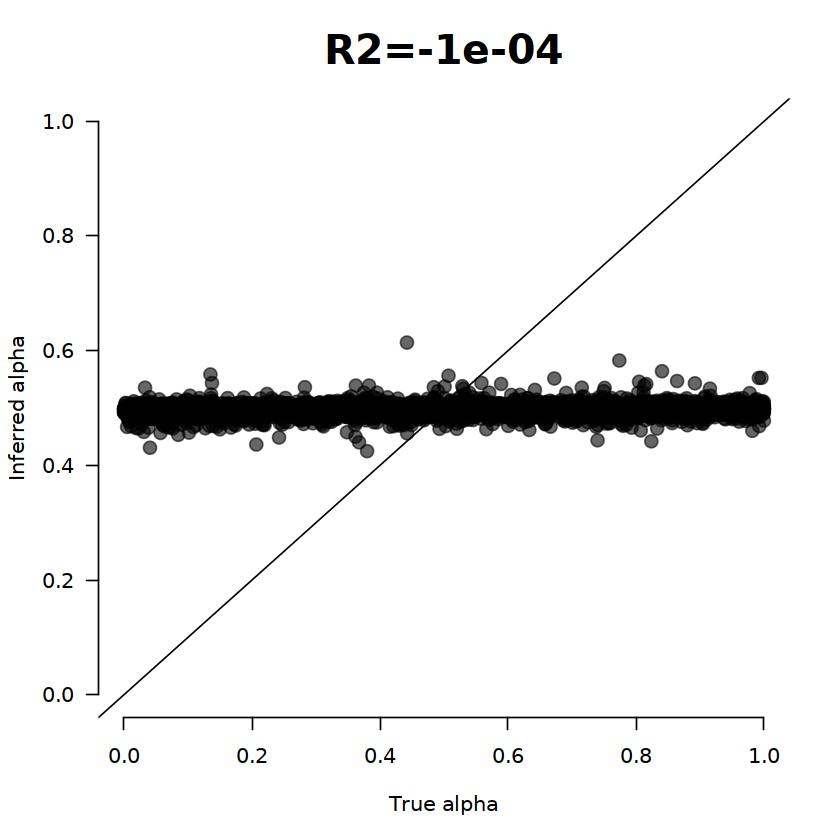

In [64]:
i = which(alpha_fit$lambda == alpha_fit$lambda.min)
plot(sim_info[, "alpha.1"], alpha_tag, pch = 20, col = rgb(0,0,0,0.6), xlim = c(0,1), ylim = c(0,1),
	cex=2, cex.main=2, main = paste0("R2=", round(1 - alpha_fit$cvm[i] / var(sim_info$alpha.1),4)), axes=F, xlab = "True alpha", ylab = "Inferred alpha")
abline(coef = c(0,1)); axis(1); axis(2,las=2)

In [65]:
png("final_figs/supp4/alpha_inference.png", width = 1000, height = 1000)
i = which(alpha_fit$lambda == alpha_fit$lambda.min)
plot(sim_info[, "alpha.1"], alpha_tag, pch = 20, col = rgb(0,0,0,0.6), xlim = c(0,1), ylim = c(0,1),
	cex=2, cex.main=2, main = paste0("R2=", round(1 - alpha_fit$cvm[i] / var(sim_info$alpha.1),4)), axes=F, xlab = "True alpha", ylab = "Inferred alpha")
abline(coef = c(0,1)); axis(1); axis(2,las=2)
dev.off()

png 
  2

# Singlet PIC-seq analysis

### Immune singlets 

In [111]:
numis=500
pic_umis = read_large_umis("merged_neutrophil_epithelial_mat", cells = names(sin_cl@mc[sin_cl@annots[sin_cl@mc] %in% immune_pops]))
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

imm_mle_res = run_pic_seq(mc_id = "merged_neutrophil_epithelial_mc", 
                      mat_id = "merged_neutrophil_epithelial_mat", 
                      pic_umis = ds, 
                      a_cells = epithelial_cells, 
                      b_cells = immune_cells, 
                      lr_features = lr_features, 
                      mle_features = mle_features, 
                      fname="./temp.pdf", 
                      bad_genes = bad_genes,
                      reg = 1e-4, 
                      numis = 500, 
                      downsample=F,
                      lr_k = 1e4)

head(imm_mle_res)

imm_mle_res$sin_alpha = with(imm_mle_res, round(alpha))
imm_mle_res$sin_ll = with(imm_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(imm_mle_res)], a_mc, b_mc, sin_alpha, reg = 1e-4, 
                                              markers = mle_features))
imm_mle_res$diff = with(imm_mle_res, ll - sin_ll)

imm_mle_res$epi_alpha = 1
imm_mle_res$epi_ll = with(imm_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(imm_mle_res)], a_mc, b_mc, epi_alpha, reg = 1e-4, 
                                              markers = mle_features))
imm_mle_res$epi_diff = with(imm_mle_res, ll - epi_ll)

imm_mle_res$imm_alpha = 0
imm_mle_res$imm_ll = with(imm_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(imm_mle_res)], a_mc, b_mc, imm_alpha, reg = 1e-4, 
                                              markers = mle_features))
imm_mle_res$imm_diff = with(imm_mle_res, ll - imm_ll)

write.table(imm_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_imm_mle_res.txt")

Retained 132 PIC with >500 UMI

Simulating 10000 PIC (numis = 500) for alpha estimation

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Building LR for alpha

Running MLE on PIC

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



,a_mc,b_mc,ll,alpha
,<int>,<int>,<dbl>,<dbl>
AB525_K11,182,1,-138.2554,0.069977418
AB525_D15,46,6,-162.4392,0.306952092
AB540_E11,200,8,-168.3708,0.007969298
AB543_A9,46,5,-145.6533,0.075362682
AB526_C2,193,6,-147.8730,0.039304494
AB526_C6,200,6,-213.2806,0.042147039


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


### Epithelial singlets 

In [112]:
numis=500
pic_umis = read_large_umis("merged_neutrophil_epithelial_mat", cells = names(sin_cl@mc[sin_cl@annots[sin_cl@mc] %in% epithelial_pops]))
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

epi_mle_res = run_pic_seq(mc_id = "merged_neutrophil_epithelial_mc", 
                      mat_id = "merged_neutrophil_epithelial_mat", 
                      pic_umis = ds, 
                      a_cells = epithelial_cells, 
                      b_cells = immune_cells, 
                      lr_features = lr_features, 
                      mle_features = mle_features, 
                      fname="./temp.pdf", 
                      bad_genes = bad_genes,
                      reg = 1e-4, 
                      numis = 500, 
                      downsample=F,
                      lr_k = 1e4)

head(epi_mle_res)

epi_mle_res$sin_alpha = with(epi_mle_res, round(alpha))
epi_mle_res$sin_ll = with(epi_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(epi_mle_res)], a_mc, b_mc, sin_alpha, reg = 1e-4, 
                                              markers = mle_features))
epi_mle_res$diff = with(epi_mle_res, ll - sin_ll)

epi_mle_res$epi_alpha = 1
epi_mle_res$epi_ll = with(epi_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(epi_mle_res)], a_mc, b_mc, epi_alpha, reg = 1e-4, 
                                              markers = mle_features))
epi_mle_res$epi_diff = with(epi_mle_res, ll - epi_ll)

epi_mle_res$imm_alpha = 0
epi_mle_res$imm_ll = with(epi_mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(epi_mle_res)], a_mc, b_mc, imm_alpha, reg = 1e-4, 
                                              markers = mle_features))
epi_mle_res$imm_diff = with(epi_mle_res, ll - imm_ll)

write.table(epi_mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_epi_mle_res.txt")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Retained 10627 PIC with >500 UMI

Simulating 10000 PIC (numis = 500) for alpha estimation

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Building LR for alpha

Running MLE on PIC

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



,a_mc,b_mc,ll,alpha
,<int>,<int>,<dbl>,<dbl>
AB529_N3,117,2,-141.0161,0.9624984
AB541_G24,145,2,-134.2062,0.9896735
AB541_P4,60,2,-134.3257,0.9396438
AB541_H8,157,2,-153.1582,0.8394734
AB541_L10,87,2,-178.7787,0.8631940
AB541_N2,252,2,-131.9127,0.9143011


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


# Real PIC-seq analysis

In [113]:
numis=500
pic_umis = read_large_umis("neutrophil_clean_pics", cells = db_mat@cells)
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

Retained 860 PIC with >500 UMI



In [114]:
mle_res = run_pic_seq(mc_id = "merged_neutrophil_epithelial_mc", 
                      mat_id = "merged_neutrophil_epithelial_mat", 
                      pic_umis = ds, 
                      a_cells = epithelial_cells, 
                      b_cells = immune_cells, 
                      lr_features = lr_features, 
                      mle_features = mle_features, 
                      fname="./temp.pdf", 
                      bad_genes = bad_genes,
                      reg = 1e-4, 
                      numis = 500, 
                      downsample=F,
                      lr_k = 1e4)

head(mle_res)

Simulating 10000 PIC (numis = 500) for alpha estimation

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Building LR for alpha

Running MLE on PIC

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
100%



,a_mc,b_mc,ll,alpha
,<int>,<int>,<dbl>,<dbl>
AB542_M7,87,2,-130.7922,0.7903814
AB542_K8,90,3,-151.2434,0.8940668
AB542_A13,94,1,-210.0961,0.6128149
AB542_P7,121,2,-135.2254,0.7563451
AB542_A4,89,2,-161.6024,0.7580213
AB539_N11,21,5,-180.6489,0.9371303


In [115]:
old_mle_res = read.delim("annotations/neutrophil_mle_res.txt", stringsAsFactors = F, row.names=1)

In [116]:
length(intersect(rownames(old_mle_res), rownames(mle_res)))

[1] 816

In [117]:
nrow(mle_res)

[1] 834

In [118]:
nrow(old_mle_res)

[1] 825

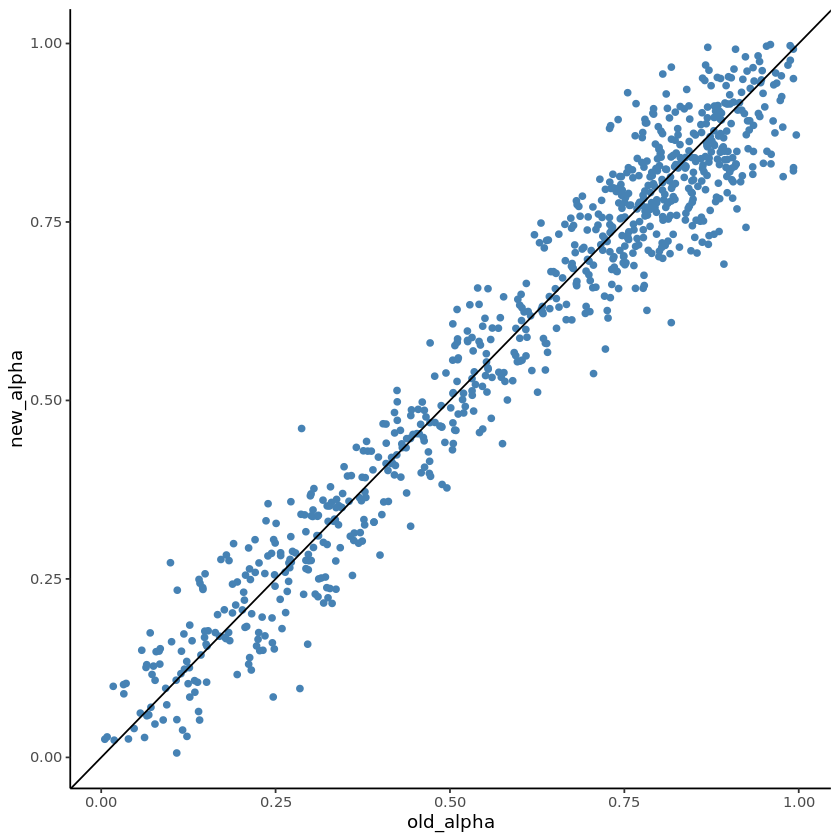

In [119]:
data.frame(new_alpha=mle_res[intersect(rownames(old_mle_res), rownames(mle_res)),'alpha'], 
           old_alpha=old_mle_res[intersect(rownames(old_mle_res), rownames(mle_res)),'alpha']) %>%
    ggplot(aes(x=old_alpha,y=new_alpha)) +
    geom_point(color='steelblue') +
    geom_abline(slope = 1, intercept = 0)

In [120]:
old_mle_res = old_mle_res[rownames(mle_res),]

In [121]:
epithelial_confu = table(mle_res$a_mc, old_mle_res$a_mc)
epithelial_n = epithelial_confu / rowSums(epithelial_confu)
immune_confu = table(mle_res$b_mc, old_mle_res$b_mc)
immune_n = immune_confu / rowSums(immune_confu)

zlim: 0<>1



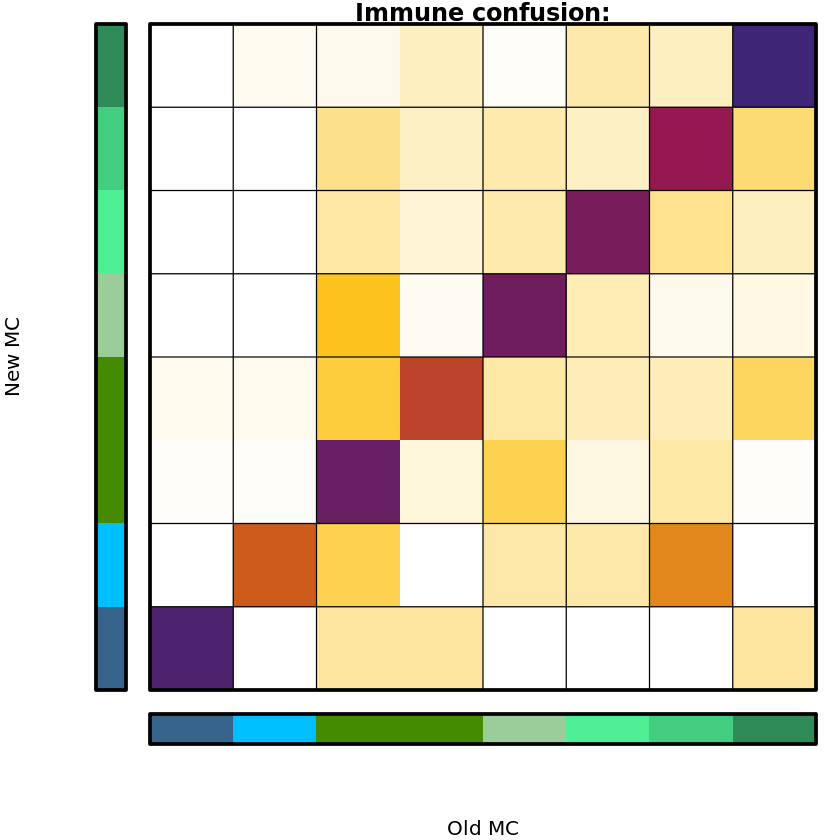

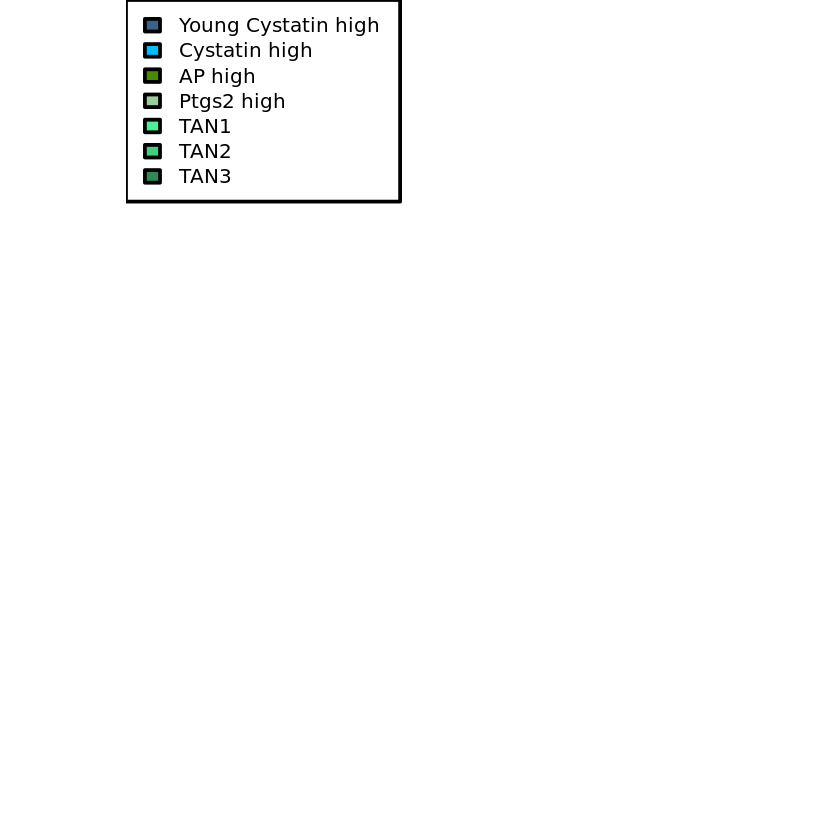

In [122]:
immune_cls = factor(color2name[ sin_cl@colors[ as.numeric(rownames(immune_n))]], levels = cell_order)
par(mar = rep(1,4), lwd = 3, fig = c(0.15,1,0.15,1))
image.2(immune_n, zlim = c(0,1), col = grad, annotate = "none", hct = immune_cls,vct = immune_cls); box()
title("Immune confusion:")
par(fig = c(0.15,1,0,0.15), mar = c(4,1,0,1), new	= T)
image(matrix(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], xlab = "Old MC");box()
par(fig = c(0,0.15,0.15,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(immune_cls)), axes = F, col = name2color[ as.vector(sort(immune_cls))], ylab = "New MC"); box()
par(mar = rep(0,4), fig = c(0.15,1,0.15,1))
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="topleft",
       legend=immune_pops,
       fill=group.colors[immune_pops],
       xpd = TRUE
       )

In [123]:
epithelial_cls = factor(color2name[ sin_cl@colors[ as.numeric(rownames(epithelial_n))]], levels = cell_order)
par(mar = rep(1,4), lwd = 3, fig = c(0.15,1,0.15,1))
image.2(epithelial_n, zlim = c(0,1), col = grad, annotate = "none", hct = epithelial_cls,vct = epithelial_cls); box()
title("epithelial confusion:")
par(fig = c(0.15,1,0,0.15), mar = c(4,1,0,1), new	= T)
image(matrix(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], xlab = "Old MC");box()
par(fig = c(0,0.15,0.15,1), mar = c(1,4,1,0), new = T)
image(t(seq_along(epithelial_cls)), axes = F, col = name2color[ as.vector(sort(epithelial_cls))], ylab = "New MC"); box()
par(mar = rep(0,4), fig = c(0.15,1,0.15,1))
plot(NULL ,xaxt='n',yaxt='n',bty='n',ylab='',xlab='', xlim=0:1, ylim=0:1)
legend(x="topleft",
       legend=epithelial_pops,
       fill=group.colors[epithelial_pops],
       xpd = TRUE
       )

ERROR: Error in `[.default`(X, , order(vct)): subscript out of bounds


ERROR: Error in box(): plot.new has not been called yet


In [124]:
mle_res$sin_alpha = with(mle_res, round(alpha))
mle_res$sin_ll = with(mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(mle_res)], a_mc, b_mc, sin_alpha, reg = 1e-4, 
                                              markers = mle_features))
mle_res$diff = with(mle_res, ll - sin_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [125]:
mle_res$imm_ll = with(mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(mle_res)], a_mc, b_mc, 1, reg = 1e-4, 
                                              markers = mle_features))
mle_res$imm_diff = with(mle_res, ll - imm_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [126]:
mle_res$epi_ll = with(mle_res, pic_ll_to_pair('merged_neutrophil_epithelial_mc', 'merged_neutrophil_epithelial_mat', 
                                              ds[,rownames(mle_res)], a_mc, b_mc, 0, reg = 1e-4, 
                                              markers = mle_features))
mle_res$epi_diff = with(mle_res, ll - epi_ll)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


In [127]:
mle_res$lower_diff = pmin(mle_res$epi_diff, mle_res$imm_diff)

In [128]:
write.table(mle_res, sep = "\t", quote=F, col.names=NA, file = "annotations/neutrophil_mle_res.txt")

In [175]:
#rerun
mle_res = read.delim("annotations/neutrophil_mle_res.txt", stringsAsFactors = F, row.names=1)
epi_mle_res = read.delim("annotations/neutrophil_epi_mle_res.txt", stringsAsFactors = F, row.names=1)
imm_mle_res = read.delim("annotations/neutrophil_imm_mle_res.txt", stringsAsFactors = F, row.names=1)
head(mle_res)

,a_mc,b_mc,ll,alpha,sin_alpha,sin_ll,diff,imm_ll,imm_diff,epi_ll,epi_diff,lower_diff
,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AB542_M7,87,2,-130.7922,0.7903814,1,-151.1895,20.397286,-151.1895,20.397286,-278.2278,147.4356,20.397286
AB542_K8,90,3,-151.2434,0.8940668,1,-189.0375,37.794062,-189.0375,37.794062,-472.9461,321.7027,37.794062
AB542_A13,94,1,-210.0961,0.6128149,1,-275.8295,65.733364,-275.8295,65.733364,-289.4468,79.3507,65.733364
AB542_P7,121,2,-135.2254,0.7563451,1,-172.2585,37.033086,-172.2585,37.033086,-262.5931,127.3677,37.033086
AB542_A4,89,2,-161.6024,0.7580213,1,-208.8252,47.222733,-208.8252,47.222733,-380.0872,218.4847,47.222733
AB539_N11,21,5,-180.6489,0.9371303,1,-188.2646,7.615641,-188.2646,7.615641,-432.6137,251.9648,7.615641


In [176]:
mle_res$lower_diff = pmin(mle_res$imm_dif, mle_res$epi_diff)
epi_mle_res$lower_diff = pmin(epi_mle_res$imm_dif, epi_mle_res$epi_diff)
imm_mle_res$lower_diff = pmin(imm_mle_res$imm_dif, imm_mle_res$epi_diff)

In [177]:
#Rerun
sim_info = read.delim("annotations/neutrophil_sim_info_final.txt", row.names = 1)
sim_mle_res = read.delim("annotations/neutrophil_sim_mle_res_final.txt", row.names = 1)

In [178]:
min_thresh = ceiling(min(c(epi_mle_res$lower_diff, imm_mle_res$lower_diff, sim_mle_res$lower_diff, mle_res$lower_diff)))

In [179]:
max_thresh = floor(max(c(epi_mle_res$lower_diff, imm_mle_res$lower_diff, sim_mle_res$lower_diff, mle_res$lower_diff)))

In [180]:
thresh_df = data.frame(thresh=seq(min_thresh, max_thresh, 0.01),
                       singlet_pctg=sapply(seq(min_thresh, max_thresh, 0.01), function(thresh){
    mean(sum(epi_mle_res$lower_diff < thresh) / nrow(epi_mle_res), sum(imm_mle_res$lower_diff < thresh) / nrow(imm_mle_res))
                           }),
                       simpic_pctg=sapply(seq(min_thresh, max_thresh, 0.01), function(thresh){
        (sum(sim_mle_res$lower_diff < thresh) / nrow(sim_mle_res))
                           })
                      )

In [181]:
max_df = thresh_df[thresh_df$singlet_pctg - thresh_df$simpic_pctg == max(thresh_df$singlet_pctg - thresh_df$simpic_pctg),][1,]
singlet_pctg = mean(max_df$singlet_pctg)

In [182]:
max_df

,thresh,singlet_pctg,simpic_pctg
,<dbl>,<dbl>,<dbl>
8253,0.52,0.9719783,0.1641


In [184]:
thresh = max_df$thresh

In [75]:
point_on_line = (max_df$singlet_pctg + max_df$simpic_pctg) / 2

In [76]:
#thresh = thresh_df[abs(thresh_df$singlet_pctg - 0.75) == min(abs(thresh_df$singlet_pctg - 0.75)),'thresh']

In [77]:
#point_on_line = (thresh_df[thresh_df$thresh == thresh,]$singlet_pctg + thresh_df[thresh_df$thresh == thresh,]$simpic_pctg) / 2

Saving 6.67 x 6.67 in image


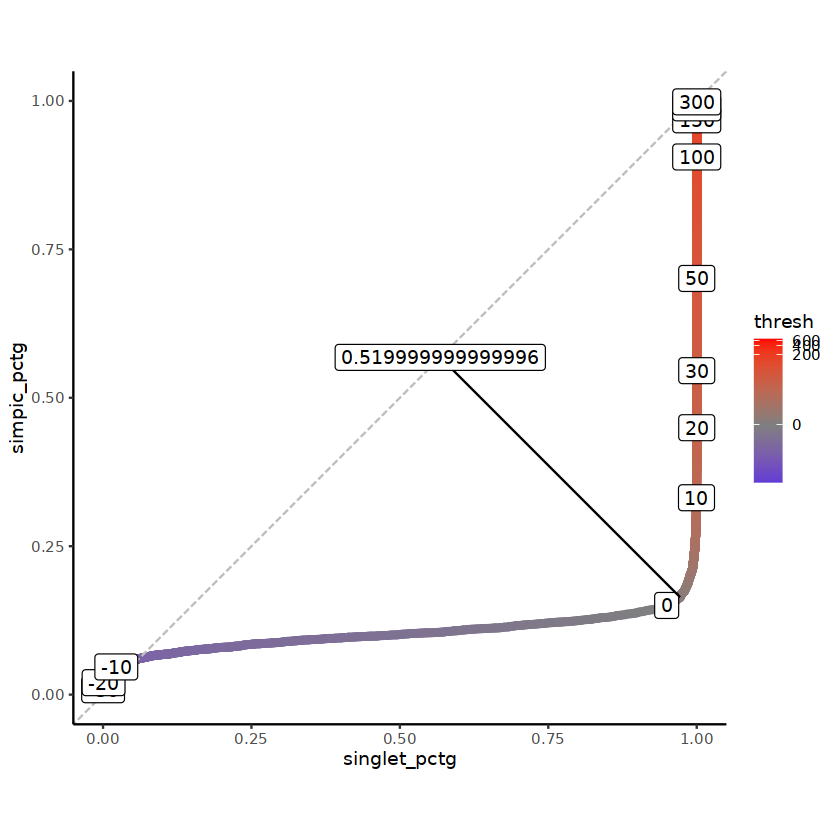

In [78]:
ggplot(thresh_df, aes(x=singlet_pctg, y=simpic_pctg, color=thresh)) +
    geom_point() +
    geom_abline(slope = 1, intercept = 0, color='gray', linetype='longdash') +
    scale_color_gradient2(low = 'blue', mid = 'gray50', high = 'red', midpoint = 0, trans='pseudo_log') +
    geom_label(data=thresh_df[thresh_df$thresh %in% c(seq(-30,30,10), seq(50,200,50), 300),],#[round(thresh_df$thresh, digits = -1) == thresh_df$thresh ,], 
               aes(label=thresh), color='black') +
    scale_y_continuous(limits = c(0,1)) +
    geom_segment(data=data.frame(x=point_on_line, y=point_on_line, 
                                 x2=thresh_df[thresh_df$thresh == thresh,]$singlet_pctg, 
                                 y2=thresh_df[thresh_df$thresh == thresh,]$simpic_pctg), 
                 aes(x=x, y=y, xend=x2, yend=y2), color='black') +
    geom_label(data=data.frame(x=point_on_line, y=point_on_line, label=thresh), 
               aes(x=x, y=y, label=label), color='black') +
    coord_fixed()
ggsave("final_figs/supp4/exclusion_curve.pdf")

Saving 6.67 x 6.67 in image


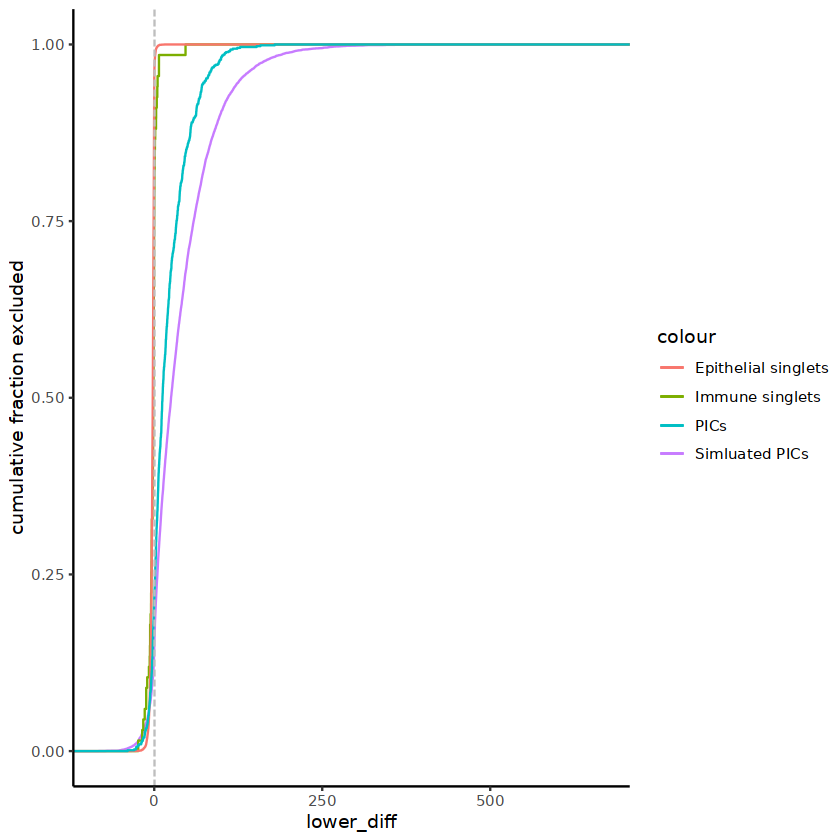

In [79]:
ggplot(sim_mle_res, aes(lower_diff)) + 
    stat_ecdf(geom = "step", aes(color='Simluated PICs')) +
    stat_ecdf(data = imm_mle_res, geom = "step", aes(color='Immune singlets')) +
    stat_ecdf(data = epi_mle_res, geom = "step", aes(color='Epithelial singlets')) +
    stat_ecdf(data = mle_res, geom = "step", aes(color='PICs')) +
    #scale_x_continuous(limits = c(-50, 200)) +
    geom_vline(xintercept = thresh, color='gray', linetype='longdash') +
    labs(y="cumulative fraction excluded")
ggsave("final_figs/supp4/exclusion_by_thresh.pdf")

In [185]:
#thresh = 0.5
message("Epithelial singlets - ", sum(epi_mle_res$lower_diff < thresh) / nrow(epi_mle_res))
message("Immune singlets - ", sum(imm_mle_res$lower_diff < thresh) / nrow(imm_mle_res))
message("Simulated PICs - ", sum(sim_mle_res$lower_diff < thresh) / nrow(sim_mle_res))
message("Experimental PICs - ", sum(mle_res$lower_diff < thresh) / nrow(mle_res))

Epithelial singlets - 0.971978305785124

Immune singlets - 0.82089552238806

Simulated PICs - 0.1641

Experimental PICs - 0.229016786570743



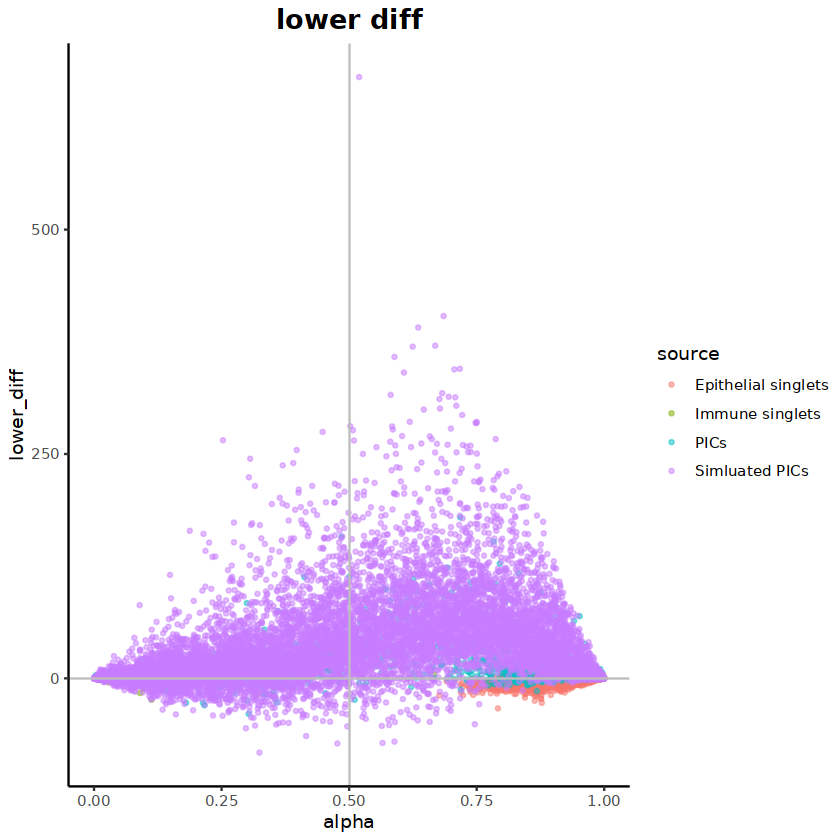

In [81]:
rbind(cbind(imm_mle_res, source='Immune singlets'), 
      cbind(epi_mle_res, source='Epithelial singlets'), 
      cbind(cbind(mle_res, imm_alpha=0, epi_alpha=1), source='PICs'),
      cbind(cbind(sim_mle_res, imm_alpha=0, epi_alpha=1), source='Simluated PICs')) %>%
    ggplot(aes(x=alpha, y=lower_diff, color=source)) +
    #geom_point(alpha=1, pch=21, color='black', size=0.5) +
    geom_point(alpha=0.5, size=0.8) +
    geom_hline(yintercept = 0, color='gray') +
    geom_vline(xintercept = 0.5, color='gray') +
    labs(title='lower diff') + 
    scale_x_continuous(limits = c(0, 1)) +
    theme(plot.title = element_text(size=16, hjust=0.5, face='bold'))

In [186]:
nrow(mle_res)

[1] 834

In [190]:
thresh

[1] 0.52

In [187]:
diff_excluded = rownames(mle_res)[mle_res$lower_diff < thresh]

In [188]:
length(diff_excluded)

[1] 191

In [191]:
good_pics = setdiff(rownames(mle_res), diff_excluded)

In [42]:
writeLines(good_pics, 'annotations/neutrophil_good_pics_final.txt')

In [192]:
length(good_pics)

[1] 643

In [44]:
db_mat@cell_metadata[good_pics, 'Cell_type'] %>% table

.
EPCAM-CD45 EPCAM-LY6G 
       161        482 

In [201]:
db_mat@cell_metadata[good_pics, c('Age', 'condition')] %>% mutate(Age = factor(Age, levels=age_order)) %>% table

     condition
Age   normal tumor
  10d      0     0
  3w       1     0
  6w       1     8
  8w       0    55
  10w      0   257
  12w      2   319

In [202]:
sin_cl@annots[mle_res[good_pics[db_mat@cell_metadata[good_pics, 'Age'] == '12w' & 
                                db_mat@cell_metadata[good_pics, 'condition'] == 'tumor'],
                      'b_mc']] %>% table

.
            AP high       Cystatin high          Ptgs2 high                TAN1 
                 93                   6                  78                  45 
               TAN2                TAN3 Young Cystatin high 
                 44                  48                   5 

In [203]:
sin_cl@annots[mle_res[good_pics, 'b_mc']] %>% table

.
            AP high       Cystatin high          Ptgs2 high                TAN1 
                194                  12                 130                  95 
               TAN2                TAN3 Young Cystatin high 
                 80                 120                  12 

# Heatmaps for proof

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


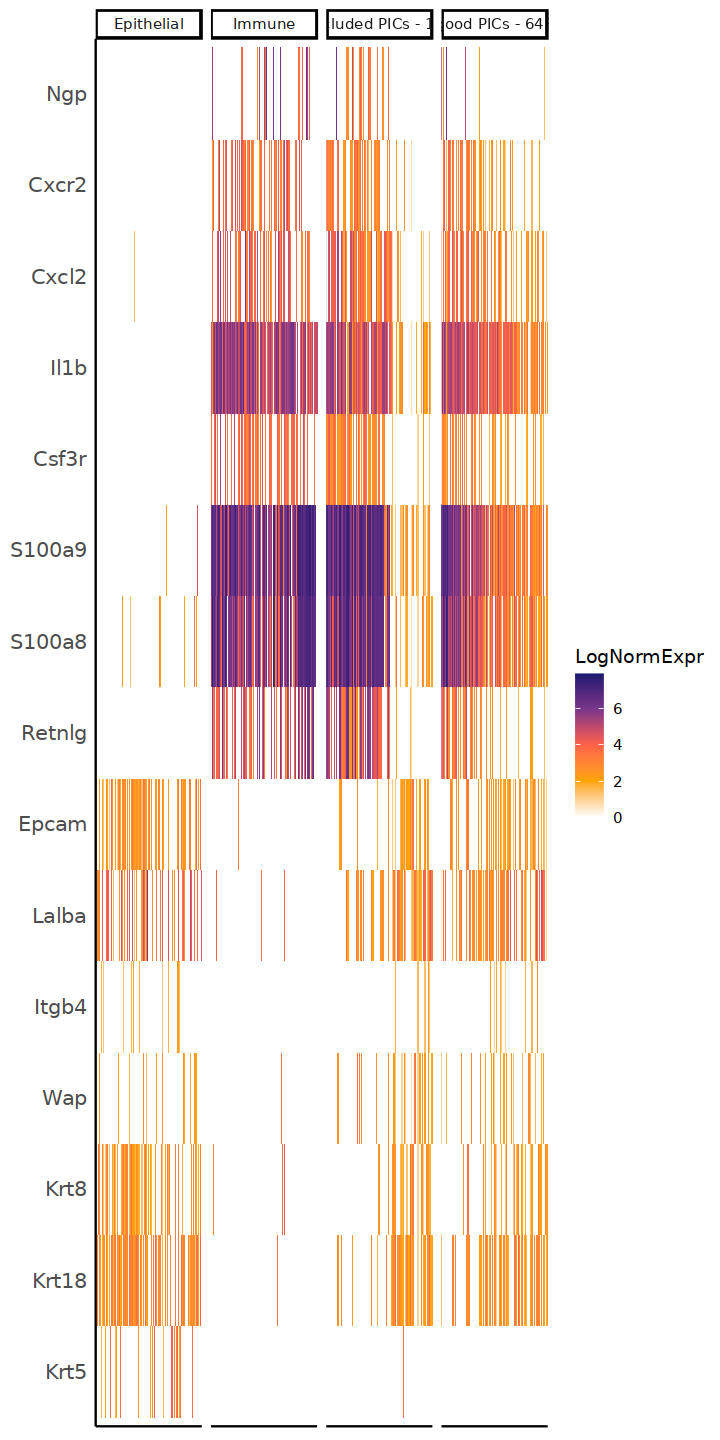

In [193]:
disp_genes = c('Krt5', 'Krt18', 'Krt8', 'Wap', 'Itgb4', 'Lalba', 'Epcam', 
               'Retnlg', 'S100a8', 'S100a9', 'Csf3r', 'Il1b', 'Cxcl2', 'Cxcr2', 'Ngp')

db_umis = read_large_umis("neutrophil_clean_pics", cells = rownames(mle_res))
epithelial_umis = read_large_umis("merged_neutrophil_epithelial_mat", cells = epithelial_cells)
immune_umis = read_large_umis("merged_neutrophil_epithelial_mat", cells = immune_cells)
focus_mat = t(db_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))

df1 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% 
    cbind(source=rep(ifelse(pmin(mle_res$epi_diff, mle_res$imm_diff) < thresh, 
                            paste0('excluded PICs - ', length(diff_excluded)), 
                            paste0('good PICs - ', length(good_pics))), 
                     each=length(disp_genes)))

focus_mat = t(epithelial_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))
df2 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source='Epithelial')

focus_mat = t(immune_umis)
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))
heatmap_df = as.matrix(t(focus_mat_norm[,disp_genes]))
df3 = heatmap_df %>% melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source='Immune')

df1$cell_name = factor(df1$cell_name, 
                       levels=rownames(mle_res)[order(mle_res$alpha)])

ggplot(rbind(df1, df2, df3) %>% 
           mutate(source=factor(source, levels=c('Epithelial', 'Immune', 
                                                 paste0('excluded PICs - ', length(diff_excluded)), 
                                                 paste0('good PICs - ', length(good_pics))))), 
       aes(x=cell_name, y=gene, fill=LogNormExpr)) +
    geom_tile() +
    scale_fill_gradientn(colors=c("white", "orange", "tomato", "mediumorchid4", "midnightblue")) +
    facet_grid(~ source, scales = 'free_x') +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks = element_blank(),
          axis.title.y = element_blank(), axis.text = element_text(size = 12))

ggsave("final_figs/supp4/gene_compare_all.pdf", width=10, height=5)

In [90]:
#rerun
good_pics = rownames(mle_res)
good_pics = good_pics[pmin(mle_res$imm_diff, mle_res$epi_diff) >= thresh]
#good_pics = good_pics[db_mat@cell_metadata[good_pics,'total_counts'] >= 650]
alpha = mle_res[good_pics, "alpha"]; names(alpha) = good_pics
epithelial_mc = mle_res[good_pics, "a_mc"]; names(epithelial_mc) = good_pics
immune_mc = mle_res[good_pics, "b_mc"]; names(immune_mc) = good_pics
parser_epithelial = color2name[ sin_cl@colors[ epithelial_mc]]; names(parser_epithelial) = good_pics
parser_immune = color2name[ sin_cl@colors[ immune_mc]]; names(parser_immune) = good_pics

table(parser_epithelial)
table(parser_immune)

parser_epithelial
     Alveolar            HS Myoepithelial        MyoLum  Progenitor 1 
           17            11             9            19            25 
 Progenitor 2   Tumor cells 
           28           534 

parser_immune
      Cystatin high          MHCII Neut          Neut Ptgs2          Neut Socs3 
                 12                 194                 130                  95 
               TAN1                TAN2 Young Cystatin high 
                 80                 120                  12 

In [206]:
writeLines(good_pics, 'annotations/neutrophil_good_pics.txt')

In [38]:
length(good_pics)

[1] 643

In [36]:
table(db_mat@cell_metadata[good_pics, c('Age', 'condition')] %>% mutate(Age = factor(Age, levels=age_order)))

     condition
Age   normal tumor
  10d      0     0
  3w       1     0
  6w       1     8
  8w       0    55
  10w      0   257
  12w      2   319

### Unified heatmap

In [112]:
cell_stats = rbind(db_mat@cell_metadata, sin_mat@cell_metadata[colnames(db_mat@cell_metadata)])
comb = with(cell_stats, paste0(ifelse(rownames(cell_stats) %in% db_mat@cells, "PIC", "Singlet"), "@",
                               condition, "@", Age, "@", Cell_type)); 
names(comb) = rownames(cell_stats)

In [113]:
cell_stats$is_pic = ifelse(rownames(cell_stats) %in% db_mat@cells, "PIC", "Singlet")

In [114]:
cell_stats$epithelial_type = ifelse(rownames(cell_stats) %in% good_pics, 
                                    parser_epithelial[rownames(cell_stats)], 
                                    ifelse(sin_cl@annots[sin_cl@mc[rownames(cell_stats)]] %in% epithelial_pops,
                                           sin_cl@annots[sin_cl@mc[rownames(cell_stats)]], NA))

In [115]:
cell_stats$immune_type = ifelse(rownames(cell_stats) %in% good_pics, 
                                parser_immune[rownames(cell_stats)], 
                                ifelse(sin_cl@annots[sin_cl@mc[rownames(cell_stats)]] %in% immune_pops,
                                           sin_cl@annots[sin_cl@mc[rownames(cell_stats)]], NA))

In [116]:
full_cell_stats = cell_stats

In [214]:
imhm_genes = rev(c("S100a9", "S100a8", "Wfdc17", "Ifitm1", 
                   "Cxcl2", "Ccrl2", "Tnfaip3", "Ptgs2", "Nfkbid", "Ccl3", 
                   "H2-Ab1", "Cd74", "H2-Aa", "Ccl6", 
                   "Retnla", "Cstdc6", "Cstdc5", "Cstdc4", "Csta3", "Stfa3", "Stfa2", "Stfa2l1", "Stfa1", 
                   "Retnlg", "Lyz2", "Pglyrp1", "Wfdc21", 
                   "Camp", "Ngp", "Arhgdib", "Ifitm6", "Mmp8", "Cd177", "Ly6a2", "Adpgk"))
epi_hm_genes = c("Kit", "Aldh1a3", "Mfge8", "Fcgbp", "Wfdc18", "Krt8", "Krt18", "Cp", 
                 "Lalba", "Csn3", 
                 "Cited1", "Pgr", "Esr1", "Prlr", 
                 "Myl9", "Acta2", #"Pdpn", "Mylk", "Myh11", "Ecrg4", "Oxtr", "Tpm2", 
                 "Krt5", "Krt14", 
                 "Krt17", "Rbp1", "Rflnb", "Gja1", #"Pclaf", "Tuba1b", "Hmgb2", "Ccna2",
                 #"Spp1",
                 "Wap", "Csn1s1", "Csn1s2a", "Csn2", "Thrsp", "Car6", "Saa1", "Saa2")
disp_genes = c(imhm_genes, epi_hm_genes)

In [215]:
hm_stats = full_cell_stats %>% 
    filter(!is.na(epithelial_type) | !is.na(immune_type)) %>% 
    select(Age, condition, is_pic, epithelial_type, immune_type)

In [216]:
pic_rows = which(hm_stats$is_pic == 'PIC')

In [217]:
epithelial_rows = which(is.na(hm_stats$immune_type))

In [218]:
immune_rows = which(is.na(hm_stats$epithelial_type))

In [219]:
hm_df = hm_stats[c(pic_rows, sample(epithelial_rows, length(pic_rows)), sample(immune_rows, length(pic_rows))),]

In [220]:
hm_df$alpha = ifelse(hm_df$is_pic == 'PIC', alpha[rownames(hm_df)], 
                     ifelse(is.na(hm_df$immune_type), 1, 0))

In [221]:
hm_df = hm_df %>% mutate(Source = factor(ifelse(is_pic == "PIC", 'PIC', ifelse(is.na(epithelial_type), 'Immune', 'Epithelial')),
                                         levels=c('Immune', 'Epithelial', 'PIC')),
                         immune_type=factor(immune_type, levels=cell_order),
                         epithelial_type=factor(epithelial_type, levels=cell_order))

In [222]:
hmgene_df = rbind(apply(t(sin_mat@mat[,rownames(hm_df %>% filter(is_pic =='Singlet'))]), 1, 
                        function(x){log1p(1e4 * x / sum(x))}) %>% t %>% as.data.frame %>% select(disp_genes),
                  apply(t(db_mat@mat[,rownames(hm_df %>% filter(is_pic =='PIC'))]), 1, 
                        function(x){log1p(1e4 * x / sum(x))}) %>% t %>% as.data.frame %>% select(disp_genes)) %>%
    as.matrix %>% t

In [223]:
c_vec = sin_cl@colors[!duplicated(sin_cl@colors)]
names(c_vec) = sin_cl@annots[!duplicated(sin_cl@annots)]

In [224]:
ha1 = HeatmapAnnotation(show_legend = F,
                        Immune_annot=factor(hm_df$immune_type, levels = cell_order), 
                        Epithelial_annot=factor(hm_df$epithelial_type, levels = cell_order), 
                        col = list(Immune_annot=c_vec, Epithelial_annot=c_vec))

ha2 = HeatmapAnnotation(alpha=hm_df$alpha,
                        col = list(alpha=colorRamp2(c(0, 0.5, 1), c("limegreen", "gray40", "firebrick3"))))

In [225]:
png(file="final_figs/supp4/heatmap_comb.pdf", 
    width = 10,
    height    = 6,
    units     = "in",
    res       = 1200,
    pointsize = 1
)

hm_plot = Heatmap(hmgene_df[,rownames(hm_df)], 
                  row_names_gp = gpar(fontsize=6), 
                  show_column_dend = F, 
                  column_order = rownames(hm_df %>% arrange(is_pic, immune_type, epithelial_type, alpha)), 
                  row_order = disp_genes,
                  column_split = hm_df$Source,
                  row_split = factor(ifelse(disp_genes %in% imhm_genes, "Immune genes", "Epithelial genes"), 
                                            levels=c("Immune genes", "Epithelial genes")),
                  heatmap_legend_param = list(labels_gp = gpar(fontsize = 6)),
                  cluster_rows = F, 
                  cluster_columns =  F, 
                  top_annotation = ha1, 
                  bottom_annotation = ha2, 
                  show_column_names = F,
                  col = colorRampPalette(c("white", "orange", "tomato", "mediumorchid4", "midnightblue"))(10000), 
                  use_raster = F)
plot(hm_plot)
dev.off()

png 
  2

In [226]:
write_lines(disp_genes, "final_figs/supp4/hm_gene_list.txt")

# Composition analysis

In [95]:
cell_stats[rownames(cell_stats) %in% good_pics & cell_stats$condition == 'tumor',] %>% dcast(Age ~ Replicate)

Using immune_type as value column: use value.var to override.

Aggregation function missing: defaulting to length



Age,1,2,3,4,5
<fct>,<int>,<int>,<int>,<int>,<int>
6w,0,0,8,0,0
8w,0,0,55,0,0
10w,0,0,0,202,55
12w,53,59,139,68,0


In [96]:
cell_stats[rownames(cell_stats) %in% good_pics & cell_stats$condition == 'normal',] %>% dcast(Age ~ Replicate)

Using immune_type as value column: use value.var to override.

Aggregation function missing: defaulting to length



Age,2,3,4
<fct>,<int>,<int>,<int>
3w,0,0,1
6w,0,1,0
12w,2,0,0


In [97]:
cell_stats = cell_stats[cell_stats$condition == 'tumor' & cell_stats$Age %in% c('8w', '10w', '12w'),]

In [98]:
cell_stats$Cell_type %>% unique

[1] EPCAM-CD45 EPCAM-LY6G CD45+      EPCAM      CD45-      LY6G      
Levels: EPCAM-CD45 EPCAM-LY6G CD45+ CD45- EPCAM LY6G

In [99]:
immune_replicate_df = cell_stats %>%
    filter(Cell_type %in% c('LY6G', 'EPCAM-LY6G') & immune_type %in% immune_pops) %>%
    #filter(Age != '10w') %>%
    #filter(Age %in% c('8w', '10w', '12w') & condition == 'tumor') %>%
    group_by(Age, condition, is_pic, immune_type, Replicate) %>% 
    summarise(Count=length(Age)) %>% drop_na() %>% as.data.frame %>%
    complete(Age, condition, is_pic, immune_type, Replicate, fill=list(Count=0)) %>%
    group_by(Age, condition, is_pic, Replicate) %>% 
    summarise(Age=Age,
              condition=condition,
              is_pic=is_pic,
              annotation=immune_type,
              Replicate=Replicate,
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count)) %>%
    filter(total > 10)

immune_replicate_df$annotation = factor(immune_replicate_df$annotation, levels=cell_order)
immune_replicate_df$condition = factor(immune_replicate_df$condition, levels=rev(cond_order))
immune_replicate_df$Age = factor(immune_replicate_df$Age, levels=age_order)
immune_replicate_df$is_pic = factor(immune_replicate_df$is_pic, levels=c('Singlet', 'PIC'))
#immune_replicate_df = remove_missing(immune_replicate_df)

`summarise()` has grouped output by 'Age', 'condition', 'is_pic',
'immune_type'. You can override using the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'condition', 'is_pic', 'Replicate'.
You can override using the `.groups` argument.


In [100]:
epithelial_replicate_df = cell_stats %>%
    filter(Cell_type %in% c('EPCAM', 'EPCAM-LY6G') & epithelial_type %in% epithelial_pops) %>%
    #filter(Age != '10w') %>%
    #filter(Age %in% c('8w', '10w', '12w') & condition == 'tumor') %>%
    group_by(Age, condition, is_pic, epithelial_type, Replicate) %>% 
    summarise(Count=length(Age)) %>% drop_na() %>% as.data.frame %>%
    complete(Age, condition, is_pic, epithelial_type, Replicate, fill=list(Count=0)) %>%
    group_by(Age, condition, is_pic, Replicate) %>% 
    summarise(Age=Age,
              condition=condition,
              is_pic=is_pic,
              annotation=epithelial_type,
              Replicate=Replicate,
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count)) %>%
    filter(total > 10)

epithelial_replicate_df$annotation = factor(epithelial_replicate_df$annotation, levels=cell_order)
epithelial_replicate_df$condition = factor(epithelial_replicate_df$condition, levels=rev(cond_order))
epithelial_replicate_df$Age = factor(epithelial_replicate_df$Age, levels=age_order)
epithelial_replicate_df$is_pic = factor(epithelial_replicate_df$is_pic, levels=c('Singlet', 'PIC'))
#epithelial_replicate_df = remove_missing(epithelial_replicate_df)

`summarise()` has grouped output by 'Age', 'condition', 'is_pic',
'epithelial_type'. You can override using the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'condition', 'is_pic', 'Replicate'.
You can override using the `.groups` argument.


In [104]:
composition_plots = function(replicate_df, pop_name, exclude_ages=c(), basedir='final_figs/fig4/pic_composition/'){
    means_df = replicate_df %>%
    group_by(Age, condition, is_pic, annotation) %>% 
    summarise(mean_fraction=mean(fraction)) %>%
    mutate_all(~replace(., is.na(.), 0)) %>%
    mutate(Age=factor(Age, levels=age_order), 
           condition=factor(condition, levels=cond_order), 
           is_pic=factor(is_pic, levels=c('Singlet', 'PIC')))
        
    p = ggplot(means_df %>% filter(!Age %in% exclude_ages), aes(y=mean_fraction, x=is_pic, fill=annotation)) + 
    geom_bar(position="fill", stat="identity", orientation = "x") +
    scale_fill_manual(values = group.colors) +
    facet_grid(condition ~ Age) +
    theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.x = element_blank(),
          axis.text.x = element_text(vjust = 0.5, hjust = 1, angle = 90),
          legend.box.margin = margin(c(0,0,0,5)),
          legend.title = element_text(size=12),   
          strip.background = element_rect(linetype="blank"),
          axis.text.y = element_blank(), axis.title.y = element_blank(),
          axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
          axis.line.x = element_blank(), axis.line.y = element_blank())

    l = get_legend(p)
    p = plot_grid(p + theme(legend.position="none"))

    ggsave(paste0(basedir, "/composition_bar_", pop_name, ".pdf"), plot = p, width = 5, height = 6)
    ggsave(paste0(basedir, "/composition_bar_", pop_name, "_legend.pdf"), plot = l, width=4, height=6)
    
    for (annot in unique(replicate_df$annotation)){
        plot_df = replicate_df %>% filter(annotation == annot)
        ggplot(plot_df, aes(x=age_dict[Age] + ifelse(is_pic == "PIC", 1, -1), y=fraction, col=is_pic)) +
            stat_summary(fun.data="mean_se", geom='errorbar') +
            geom_point(show.legend=F) +
            geom_smooth(method = 'loess', formula=y~x, se=F) +
            scale_color_manual(values = brightness(group.colors[annot], c(0.5, 1))) +
            scale_x_continuous(name="Age", breaks = age_dict, labels = names(age_dict)) +
            facet_grid(~ condition) +
            labs(title=paste(annot, "fraction of cells")) +
            expand_limits(y = 0) +
            theme(plot.title = element_text(hjust=0.5, size=20, face='bold'), strip.text = element_text(size=12))

        ggsave(paste0(basedir, "/fraction_final/fraction_", annot, ".pdf"), units = 'mm', height=150, width=150)
    }
}

In [105]:
composition_plots(epithelial_replicate_df, 'epithelial')

`summarise()` has grouped output by 'Age', 'condition', 'is_pic'. You can
override using the `.groups` argument.
`mutate_all()` ignored the following grouping variables:
• Columns `Age`, `condition`, `is_pic`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.
Warning message:
“There were 6 warnings in `mutate()`.
The first warning was:
ℹ In argument: `annotation = (structure(function (..., .x = ..1, .y = ..2, . =
  ..1) ...`.
ℹ In group 1: `Age = 8w`, `condition = tumor`, `is_pic = Singlet`.
Caused by warning in `[<-.factor`:
! invalid factor level, NA generated
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 54.86”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 28.14”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“re

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 56.86”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 14.14”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 199.94”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 54.86”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 28.14”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal con

In [106]:
composition_plots(immune_replicate_df, 'neutrophil')

`summarise()` has grouped output by 'Age', 'condition', 'is_pic'. You can
override using the `.groups` argument.
`mutate_all()` ignored the following grouping variables:
• Columns `Age`, `condition`, `is_pic`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.
Warning message:
“There were 6 warnings in `mutate()`.
The first warning was:
ℹ In argument: `annotation = (structure(function (..., .x = ..1, .y = ..2, . =
  ..1) ...`.
ℹ In group 1: `Age = 8w`, `condition = tumor`, `is_pic = Singlet`.
Caused by warning in `[<-.factor`:
! invalid factor level, NA generated
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 54.86”
Warning message in simpleLoess(y, x, w, span, degree = deg

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 14.14”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 199.94”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 54.86”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 28.14”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are o

# Comb validation

In [110]:
df = data.frame(cbind(parser_immune, parser_epithelial))

In [117]:
df$Age = factor(full_cell_stats[rownames(df),'Age'], levels=age_order)
df$condition = factor(full_cell_stats[rownames(df),'condition'], levels=cond_order)

In [118]:
df[df$condition == 'tumor',] %>% group_by(parser_immune, parser_epithelial) %>%
    summarise(num=length(Age))  %>%
    dcast(parser_immune ~ parser_epithelial, fill = 0) %>%
    column_to_rownames('parser_immune') %>%
    cbind(total=rowSums(.)) %>%
    rbind(total=colSums(.))

`summarise()` has grouped output by 'parser_immune'. You can override using the
`.groups` argument.
Using num as value column: use value.var to override.



,Alveolar,HS,Myoepithelial,MyoLum,Progenitor 1,Progenitor 2,Tumor cells,total
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cystatin high,0,0,0,0,0,1,10,11
MHCII Neut,8,5,4,10,9,11,144,191
Neut Ptgs2,3,0,3,3,3,6,112,130
Neut Socs3,2,2,1,2,2,4,82,95
TAN1,1,1,0,1,4,1,72,80
TAN2,2,3,1,3,3,4,104,120
Young Cystatin high,0,0,0,0,2,0,10,12
total,16,11,9,19,23,27,534,639


`summarise()` has grouped output by 'parser_immune', 'parser_epithelial'. You
can override using the `.groups` argument.
Saving 6.67 x 6.67 in image


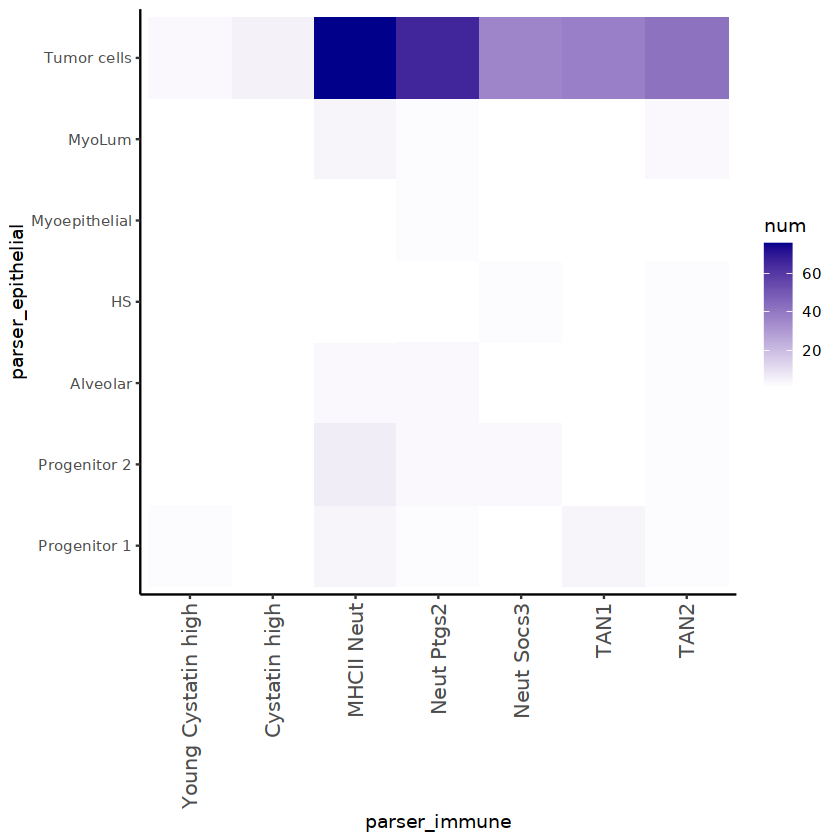

In [119]:
df[df$condition == 'tumor',] %>% group_by(parser_immune, parser_epithelial, Age) %>%
    summarise(num=length(Age))  %>%
    mutate(parser_epithelial=factor(parser_epithelial, levels=cell_order), 
           parser_immune=factor(parser_immune, levels=cell_order)) %>%
    filter(Age %in% c('8w', '10w', '12w')) %>%
    ggplot(aes(x=parser_immune, y=parser_epithelial, fill=num)) +
    geom_tile() +
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1, size=12)) +
    scale_fill_gradient(low='white', high='darkblue')
ggsave('final_figs/supp4/comb_abundance.pdf')

`summarise()` has grouped output by 'parser_immune', 'parser_epithelial'. You
can override using the `.groups` argument.
Saving 6.67 x 6.67 in image


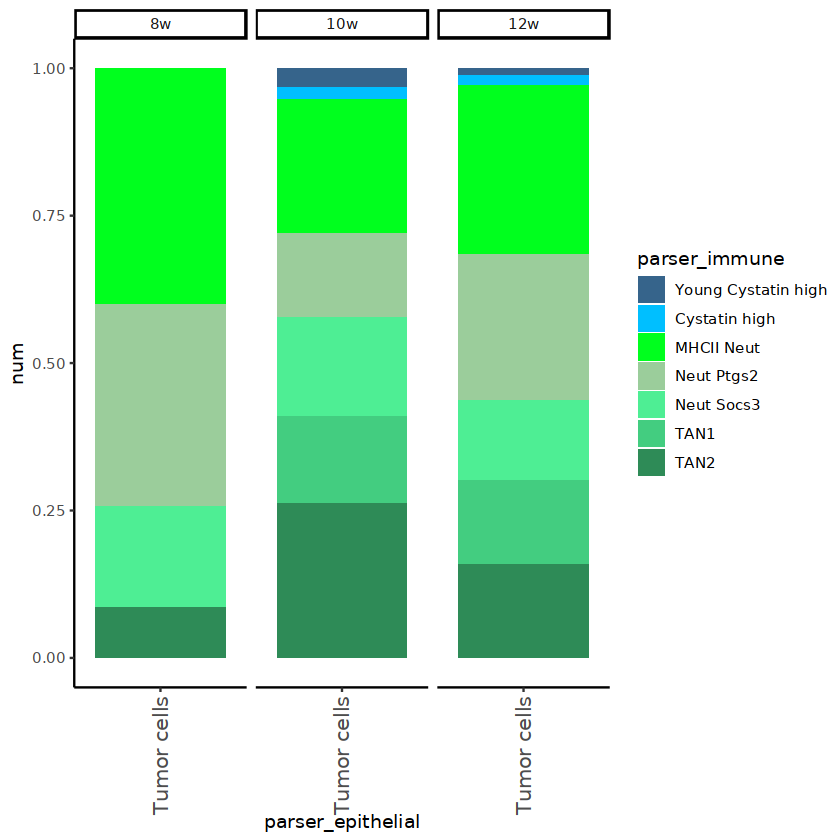

In [122]:
df[df$condition == 'tumor',] %>% group_by(parser_immune, parser_epithelial, Age) %>%
    summarise(num=length(Age))  %>%
    mutate(parser_epithelial=factor(parser_epithelial, levels=cell_order), 
           parser_immune=factor(parser_immune, levels=cell_order)) %>%
    filter(Age %in% c('8w', '10w', '12w')) %>%
    filter(parser_epithelial %in% c('Tumor cells')) %>%
    ggplot(aes(x=parser_epithelial, y=num, fill=parser_immune)) +
    geom_bar(stat='identity', position='fill') +
    scale_fill_manual(values = group.colors) +
    facet_grid(~ Age) +
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1, size=12))

ggsave('final_figs/supp4/subcomposition_immune.pdf')

`summarise()` has grouped output by 'parser_immune', 'parser_epithelial'. You
can override using the `.groups` argument.
Saving 6.67 x 6.67 in image


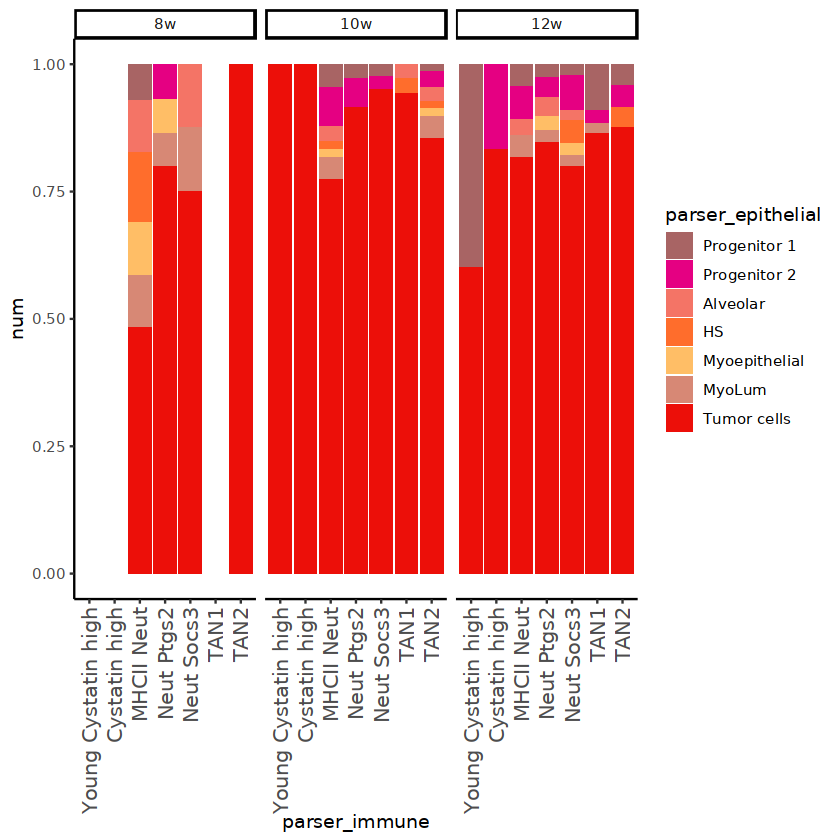

In [123]:
df[df$condition == 'tumor',] %>% group_by(parser_immune, parser_epithelial, Age) %>%
    summarise(num=length(Age))  %>%
    mutate(parser_epithelial=factor(parser_epithelial, levels=cell_order), 
           parser_immune=factor(parser_immune, levels=cell_order)) %>%
    filter(Age %in% c('8w', '10w', '12w')) %>%
    #filter(parser_immune %in% c('TAN1', 'TAN2', 'Recruiters', 'Mature')) %>%
    ggplot(aes(x=parser_immune, y=num, fill=parser_epithelial)) +
    geom_bar(stat='identity', position='fill') +
    scale_fill_manual(values = group.colors) +
    facet_grid(~ Age) +
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1, size=12))

ggsave('final_figs/supp4/subcomposition_epithelial.pdf')

# New DGE analysis

In [124]:
good_pics = read_lines('annotations/neutrophil_good_pics_final.txt')

In [125]:
db_mat@cell_metadata[good_pics, 'Cell_type'] %>% table

.
EPCAM-CD45 EPCAM-LY6G 
       161        482 

In [126]:
161 + 482

[1] 643

In [127]:
numis=500
pic_umis = read_large_umis("neutrophil_clean_pics", cells = good_pics)
ds = .downsamp(pic_umis, numis)
message("Retained ", ncol(ds), " PIC with >", numis, " UMI")

Retained 643 PIC with >500 UMI



In [128]:
analyzed_pics = good_pics[db_mat@cell_metadata[good_pics,'Age'] %in% c('8w', '10w', '12w') & 
                          db_mat@cell_metadata[good_pics,'condition'] == 'tumor' &
                          parser_epithelial[good_pics] %in% c('Tumor cells')]

In [129]:
analyzed_parser = parser_immune[analyzed_pics]

In [130]:
length(sin_mat@genes)

[1] 36893

In [131]:
length(rownames(pic_umis))

[1] 36946

In [132]:
shared_mat_genes = intersect(names(which(rowSums(sin_mat@mat[,c(immune_cells, epithelial_cells)]) > 3)), 
                             names(which(rowSums(pic_umis[,analyzed_pics]) > 3))) %>%
    setdiff(bad_genes)

In [133]:
length(shared_mat_genes)

[1] 10303

In [45]:
simulate_npics = function(cell_name, n=50, return_separated=T, select_half=0){
    numis = sum(pic_umis[shared_mat_genes, cell_name])
    mc_a = mle_res[cell_name,'a_mc']
    mc_b = mle_res[cell_name,'b_mc']
    alpha = mle_res[cell_name,'alpha']
    numis_a = round(alpha * numis)
    numis_b = numis - numis_a
    cell_a_options = names(which(sin_cl@mc == mc_a))
    cell_b_options = names(which(sin_cl@mc == mc_b))
    if (select_half == 1){
        cell_a_options = cell_a_options[1:floor(length(cell_a_options) / 2)]
        cell_b_options = cell_b_options[1:floor(length(cell_b_options) / 2)]
    } else if (select_half == 2){
        cell_a_options = cell_a_options[ceiling(length(cell_a_options) / 2):length(cell_a_options)]
        cell_b_options = cell_b_options[ceiling(length(cell_b_options) / 2):length(cell_b_options)]
    }
    cells_a = sample(cell_a_options, size = n, replace = T)
    cells_b = sample(cell_b_options, size = n, replace = T)
    cell_sizes = colSums(sin_mat@mat[shared_mat_genes, c(cells_a, cells_b)])
    a_modifier = pmax(ceiling(numis_a / cell_sizes[cells_a]), 1)
    b_modifier = pmax(ceiling(numis_b / cell_sizes[cells_b]), 1)
    a_umis = .downsamp_var(sweep(sin_mat@mat[shared_mat_genes, cells_a], 2, a_modifier, "*"), rep(numis_a, n), replace=F)
    colnames(a_umis) = paste(cell_name, "sim", 1:n, "epi", sep="_")
    b_umis = .downsamp_var(sweep(sin_mat@mat[shared_mat_genes, cells_b], 2, b_modifier, "*"), rep(numis_b, n), replace=F)
    colnames(b_umis) = paste(cell_name, "sim", 1:n, "imm", sep="_")
    simpic_umis = a_umis + b_umis
    colnames(simpic_umis) = paste(cell_name, "sim", 1:n, sep="_")
    if (return_separated){
        return(cbind(a_umis, b_umis, simpic_umis))
    } else {
        return(simpic_umis)
    }
    
}

In [720]:
simpics_full = sapply(analyzed_pics, function(x){simulate_npics(x, n=1000, return_separated=T)}) %>% do.call(cbind, .)

In [721]:
scdb_add_mat("sims_1000_new", simpics_full)

In [134]:
simpics_full = scdb_mat("sims_1000_select_genes")

In [135]:
nrow(simpics_full)

[1] 10303

In [127]:
nrow(simpics_full)#OLD

[1] 10303

In [136]:
ncol(simpics_full)

[1] 1578000

In [128]:
ncol(simpics_full)#OLD

[1] 1578000

In [139]:
simpics_imm = simpics_full[,grepl("imm", colnames(simpics_full))]
simpics_epi = simpics_full[,grepl("epi", colnames(simpics_full))]
simpics = simpics_full[,!(grepl("imm", colnames(simpics_full)) | grepl("epi", colnames(simpics_full)))]

In [ ]:
sim_pics_2 = sapply(analyzed_pics, function(x){simulate_npics(x, n=3, return_separated = F)}) %>% do.call(cbind, .)

In [51]:
sim_pics_sin1 = sim_pics_2[,seq(1,ncol(sim_pics_2),3)]
sim_pics_sin2 = sim_pics_2[,seq(2,ncol(sim_pics_2),3)]
sim_pics_sin3 = sim_pics_2[,seq(3,ncol(sim_pics_2),3)]

In [131]:
all(colSums(simpics[shared_mat_genes,]) == rep(colSums(pic_umis[shared_mat_genes,analyzed_pics]), each=1000))

[1] TRUE

In [132]:
all_mat = t(pic_umis[shared_mat_genes,])

In [133]:
all_mat = t(pic_umis[shared_mat_genes,analyzed_pics])
norm_num = median(rowSums(all_mat))
norm_mat = norm_num * all_mat / rowSums(all_mat)
message("Normalized by ", norm_num)
#lognorm_mat = log1p(10000 * all_mat / rowSums(all_mat))

Normalized by 653.5



In [55]:
norm_sim1 = norm_num * t(sim_pics_sin1) / colSums(sim_pics_sin1)

norm_sim2 = norm_num * t(sim_pics_sin2) / colSums(sim_pics_sin2)

norm_sim3 = norm_num * t(sim_pics_sin3) / colSums(sim_pics_sin3)

In [58]:
norm_sim = norm_num * t(simpics) / colSums(simpics)

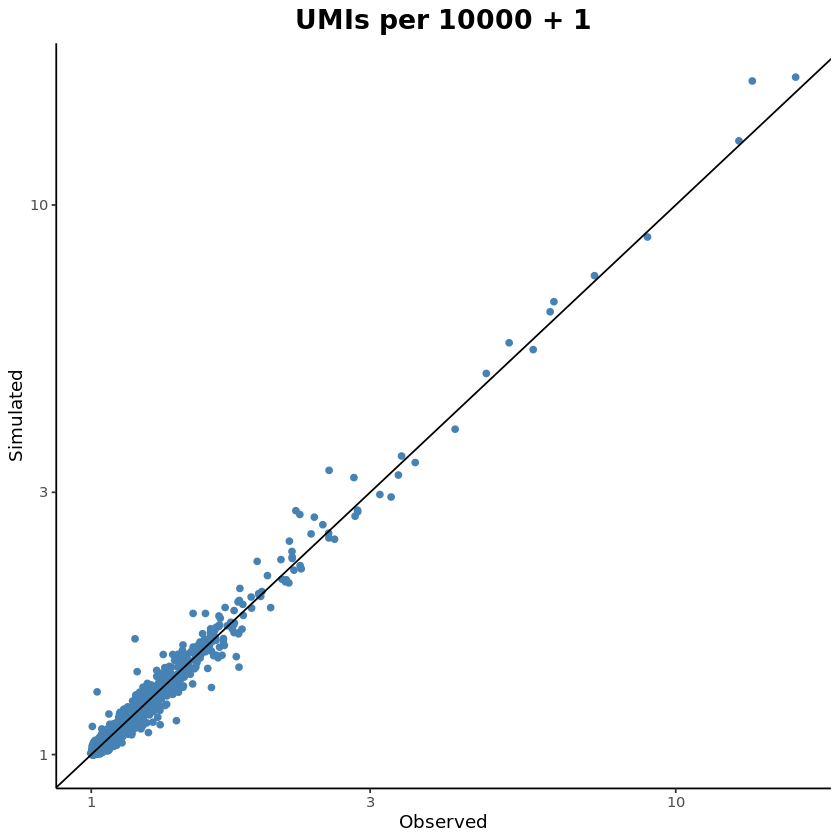

In [59]:
data.frame(x=1 + colMeans(norm_mat), y=1 + colMeans(norm_sim)) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point(color='steelblue') +
    #geom_smooth(method='lm') +
    geom_abline(intercept = 0, slope = 1) +
    scale_x_log10(labels=scales::number) +
    scale_y_log10(labels=scales::number) +
    labs(x="Observed", y="Simulated", title = "UMIs per 10000 + 1") +
    theme(plot.title = element_text(hjust=0.5, size = 16, face='bold'))

In [60]:
data.frame(x=1 + colMeans(norm_mat), y=1 + colMeans(norm_sim)) %>% lm(formula = x~y) %>% summary


Call:
lm(formula = x ~ y, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.01856 -0.00790 -0.00253  0.00443  0.82345 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.085846   0.001163    73.8   <2e-16 ***
y           0.919274   0.001049   876.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03357 on 10301 degrees of freedom
Multiple R-squared:  0.9868,	Adjusted R-squared:  0.9868 
F-statistic: 7.684e+05 on 1 and 10301 DF,  p-value: < 2.2e-16


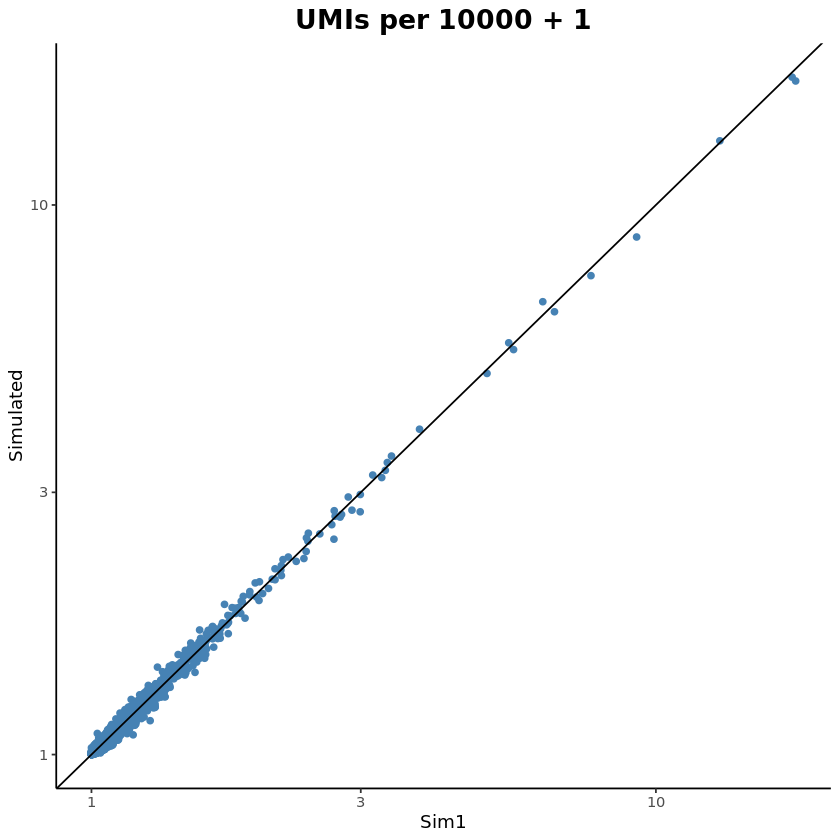

In [61]:
data.frame(x=1 + colMeans(norm_sim1), y=1 + colMeans(norm_sim)) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point(color='steelblue') +
    #geom_smooth(method='lm') +
    geom_abline(intercept = 0, slope = 1) +
    scale_x_log10(labels=scales::number) +
    scale_y_log10(labels=scales::number) +
    labs(x="Sim1", y="Simulated", title = "UMIs per 10000 + 1") +
    theme(plot.title = element_text(hjust=0.5, size = 16, face='bold'))

In [62]:
data.frame(x=1 + colMeans(norm_sim1), y=1 + colMeans(norm_sim)) %>% lm(formula = x~y) %>% summary


Call:
lm(formula = x ~ y, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48397 -0.00483  0.00016  0.00548  0.53693 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0228036  0.0005720  -39.87   <2e-16 ***
y            1.0214434  0.0005157 1980.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01651 on 10301 degrees of freedom
Multiple R-squared:  0.9974,	Adjusted R-squared:  0.9974 
F-statistic: 3.924e+06 on 1 and 10301 DF,  p-value: < 2.2e-16


# Means analysis

In [193]:
all_mat = t(pic_umis[shared_mat_genes,analyzed_pics])
norm_num = median(rowSums(all_mat))
norm_mat = norm_num * all_mat / rowSums(all_mat)
message("Normalized by ", norm_num)
#lognorm_mat = log1p(10000 * all_mat / rowSums(all_mat))

Normalized by 653.5



In [194]:
norm_sim = norm_num * t(simpics) / colSums(simpics)
#lognorm_sim = log1p(10000 * t(simpics) / colSums(simpics))

In [195]:
norm_sim_epi = rep(mle_res[analyzed_pics,'alpha'], each=1000) * norm_num * t(simpics_epi) / colSums(simpics_epi)
norm_sim_imm = (1 - rep(mle_res[analyzed_pics,'alpha'], each=1000)) * norm_num * t(simpics_imm) / colSums(simpics_imm)

In [196]:
plot_scatter = function(df, fname=NA, pval_thresh=0.01){
    p = ggplot(df %>% arrange(desc(adj_pval)), aes(x=log(` + Simulated_mean), y=log(0.1 + Observed_mean), 
                                                   color=color, size=size, label=label)) +
        geom_text_repel(max.overlaps = 1000, color='black') +
        geom_point() +
        scale_color_gradient2(low = 'chartreuse3', high='brown3', mid = 'gray10', na.value = 'gray50', midpoint = 0.5) +
        scale_size_identity() +
        geom_abline(intercept = 0, slope=1, color='black', linetype='solid')
    if (!is.na(fname)){
        l = get_legend(p)
        p = plot_grid(p + theme(legend.position="none"))

        ggsave(fname, plot = p)
        ggsave(paste0(fname, "_legend.pdf"), plot = l)
    }
}

In [197]:
plot_volcano = function(df, fname=NA, pval_thresh=0.01, lfc_thresh=0.5){
    p = ggplot(df %>% arrange(desc(adj_pval)), aes(x=lfc, y=-log10(adj_pval), color=color, size=size, label=label)) +
        geom_point(show.legend=F) +
        geom_text_repel(max.overlaps = 1000, color='black') +
        scale_color_gradient2(low = 'chartreuse3', high='brown3', mid = 'gray10', na.value = 'gray50', midpoint = 0.5) +
        scale_size_identity() +
        geom_hline(yintercept = -log10(pval_thresh), linetype='longdash', color='gray') +
        geom_vline(xintercept = c(-lfc_thresh, lfc_thresh), linetype='longdash', color='gray')
    if (!is.na(fname)){
        l = get_legend(p)
        p = plot_grid(p + theme(legend.position="none"))

        ggsave(fname, plot = p)
        ggsave(paste0(fname, "_legend.pdf"), plot = l)
    }
}

In [198]:
per_gene_plots = function(gene, dirname, focus_sim_means, focus_norm_sim, focus_norm_mat, epi_means, imm_means,
                          pval, lfc){
    plot_df = data.frame(mean_norm_expr=c(focus_sim_means[gene,], mean(focus_norm_mat[,gene])),
                         source=c(rep("Simulated", 1000), "Observed"))
    gene_mean = mean(plot_df[plot_df$source == "Simulated","mean_norm_expr"])
    gene_sd = sd(plot_df[plot_df$source == "Simulated","mean_norm_expr"])
    
    # Distribution with SDs
    ggplot(plot_df, aes(x=mean_norm_expr)) +
        geom_density(data=plot_df[plot_df$source == "Simulated",]) +
        geom_vline(xintercept = gene_mean, color='blue', linetype='longdash') +
        geom_vline(xintercept = c(gene_mean + gene_sd, gene_mean - gene_sd), color='steelblue', linetype='longdash') +
        geom_vline(xintercept = c(gene_mean + (2 * gene_sd), gene_mean - (2 * gene_sd)), color='gray', linetype='longdash') +
        geom_vline(xintercept = plot_df[plot_df$source == "Observed","mean_norm_expr"], color='red') +
        geom_point(data=plot_df[plot_df$source == "Observed",], aes(y=0), color='red', size=3) +
        labs(title=gene, subtitle = paste0("adj_pval", pval, " ; lfc = ", round(lfc, 2))) +
        theme(plot.title = element_text(size=16, hjust=0.5, face='bold'), plot.subtitle = element_text(size=12, hjust=0.5))
    ggsave(paste0("final_figs/fig5/new_gene_sd/", dirname, "/", gene, "_dist.pdf"))
    
    # Plot of all means
    ggplot(plot_df, aes(x=1, y=mean_norm_expr)) +
        geom_boxplot(data=. %>% filter(source == "Simulated")) +
        geom_jitter(width=0.1, aes(color=source, shape=source, size=source)) +
        scale_shape_manual(values = c(19, 1)) +
        scale_size_manual(values = c(5, 3)) +
        labs(title=gene, subtitle = paste0("adj_pval", pval, " ; lfc = ", round(lfc, 2))) +
        theme(plot.title = element_text(size=16, hjust=0.5, face='bold'), plot.subtitle = element_text(size=12, hjust=0.5),
              axis.title.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank())
        #scale_x_discrete(limits=c("Simulated", "Observed"))
    ggsave(paste0("final_figs/fig5/new_gene_sd/", dirname, "/", gene, "_means.pdf"), width=5, height=15)
    
    # Violin plot
    #plot_df = data.frame(LogNorm_expression=log1p(c(focus_norm_sim[,gene], focus_norm_mat[,gene])),
    #                     Source=factor(c(rep("Simulated", nrow(focus_norm_sim)), rep("Observed", nrow(focus_norm_mat))),
    #                                   levels = c("Simulated", "Observed")))
    #ggplot(plot_df, aes(x=Source, fill=Source, y=LogNorm_expression)) +
    #    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75)) +
    #    labs(title=gene) +
    #    theme(plot.title = element_text(size=20, hjust=0.5, face='bold'))
    #ggsave(paste0("final_figs/fig5/new_gene_sd/", dirname, "/", gene, "_violin.pdf"))
    
    # Bar plot
    bar_df = data.frame(source=factor(c(rep("Simulated", 2), "Observed"), levels=c("Simulated", "Observed")),
                        cell=c("Epithelial", "Neutrophil", "PIC"),
                        expression=c(epi_means[gene], imm_means[gene], mean(focus_norm_mat[,gene])))

    ggplot(bar_df, aes(x=source, y=expression, fill=cell)) +
        geom_bar(stat = 'identity', position = 'stack', color='black') +
        labs(title=gene, subtitle = paste0("adj_pval", pval, " ; lfc = ", round(lfc, 2))) +
        theme(plot.title = element_text(size=16, hjust=0.5, face='bold'), plot.subtitle = element_text(size=12, hjust=0.5))
    ggsave(paste0("final_figs/fig5/new_gene_sd/", dirname, "/", gene, "_barplot.pdf"))

}

In [199]:
p = ggplot(data.frame(x=1, y=1, color=seq(0,1,length.out = 1000)), aes(x=x, y=y, color=color)) +
    geom_tile() +
    scale_color_gradient2(low = 'chartreuse3', high='brown3', mid = 'gray10', na.value = 'gray50', midpoint = 0.5) 
l = get_legend(p)

In [200]:
ggsave(filename = "final_figs/fig5/color_legend.pdf", plot=l)

Saving 6.67 x 6.67 in image


In [235]:
n_sims=1000
pval_thresh=0.05
lfc_thresh=0.5
reg=1
per_gene = T

for (pop_name in c('All', 'MHCII Neut', 'Neut Ptgs2', 'Neut Socs3', 'TAN1', 'TAN2')){
    message("===================================================")
    message(pop_name)
    if (pop_name == "All"){
        focus_singlets = sin_mat@mat[,sin_cl@annots[sin_cl@mc[sin_mat@cells]] %in% c('Tumor cells', immune_pops)]
        is_focus = T
    } else {
        focus_singlets = sin_mat@mat[,sin_cl@annots[sin_cl@mc[sin_mat@cells]] %in% c('Tumor cells', pop_name)]
        is_focus = parser_immune[analyzed_pics] == pop_name
    }
    focus_mat = pic_umis[,analyzed_pics][,is_focus]
    focus_norm_mat = norm_mat[is_focus,]
    focus_means = colMeans(focus_norm_mat)
    
    # Simulation means    
    sim_means_file = paste0("final_figs/fig5/new_gene/", pop_name, "_sim_means.csv")
    if (file.exists(sim_means_file)) {
        message("---Simulation means file found - loading...")
        focus_sim_means = as.matrix(read.csv(sim_means_file, row.names = 1))
    } else {
        message("---Calculating simulation means...")
        focus_norm_sim = norm_sim[rep(is_focus, each=n_sims),]
        focus_sim_means = sapply(1:n_sims, function(n){colMeans(focus_norm_sim[grepl(paste0("sim_", n, "$"), 
                                                                           rownames(focus_norm_sim)),])}) 
        message("---Saving...")
        write.csv(focus_sim_means, sim_means_file)
    }
    
    # Gene data
    gene_data_file = paste0("final_figs/fig5/new_gene/", pop_name, "_genedata.csv")
    if (file.exists(gene_data_file)) {
        message("---Gene data file found - loading...")
        gene_df = read.csv(gene_data_file, row.names = 1) %>% as.matrix %>% as.data.frame
    } else {
        message("---Calculating z-score pvals, lfcs etc...")
        focus_sim_sds = sapply(shared_mat_genes, function(gene){
            sim_vals = focus_sim_means[gene,]
            return(sd(sim_vals))
        })
        focus_z_scores = sapply(shared_mat_genes, function(gene){
            sim_vals = focus_sim_means[gene,]
            z_score = (focus_means[gene] - mean(sim_vals)) / sd(sim_vals)
            return(z_score)
        })
        focus_z_pvals = 2 * pnorm(abs(focus_z_scores), lower.tail = F)

        focus_sim_meanofmeans = rowMeans(focus_sim_means)
        focus_lfcs = log2((reg + focus_means[shared_mat_genes]) / (reg + focus_sim_meanofmeans[shared_mat_genes]))
        epi_means = colMeans(norm_sim_epi[1:n_sims + rep((which(is_focus) - 1) * n_sims, each=n_sims),shared_mat_genes])
        imm_means = colMeans(norm_sim_imm[1:n_sims + rep((which(is_focus) - 1) * n_sims, each=n_sims),shared_mat_genes])
        epi_imm_ratio = epi_means / (epi_means + imm_means)

        gene_df = data.frame(Observed_mean = focus_means[shared_mat_genes],
                             Simulated_mean = focus_sim_meanofmeans[shared_mat_genes],
                             Sim_SD = focus_sim_sds,
                             z_scores = focus_z_scores,
                             full_adj_pval=p.adjust(focus_z_pvals %>% replace_na(1), method='fdr'),
                             lfc=focus_lfcs,
                             epi_imm_ratio=epi_imm_ratio)
        gene_df$adj_pval = ifelse(gene_df$full_adj_pval < 1e-5, 1e-5, gene_df$full_adj_pval)
        write.csv(gene_df, gene_data_file)
    }
    
    # Plots
    message("---Creating plots...")    
    plot_df = gene_df %>% 
        mutate(color=ifelse(adj_pval < pval_thresh, epi_imm_ratio, NA),
               size=ifelse(adj_pval < pval_thresh, 3, 1),
               label=ifelse(adj_pval < pval_thresh, rownames(.), ""))
    
    plot_scatter(plot_df, pval_thresh = pval_thresh, 
                 fname=paste0("final_figs/fig5/new_gene/", pop_name, "_scatter.pdf"))
    plot_volcano(plot_df, pval_thresh = pval_thresh, lfc_thresh = lfc_thresh,
                 fname=paste0("final_figs/fig5/new_gene/", pop_name, "_volcano.pdf"))
    if (per_gene){
        dir.create(paste0("final_figs/fig5/new_gene/", pop_name))
        sig_genes = rownames(gene_df)[gene_df$adj_pval < pval_thresh]
        for (gene in sig_genes){
            gene = unlist(str_split(gene, "\\."))[1]
            message(paste0("    ", gene))
            per_gene_plots(gene, pop_name, focus_sim_means, focus_norm_sim, focus_norm_mat, epi_means, imm_means,
                           ifelse(gene_df[gene, 'adj_pval'] == 1e-5, 
                                  ' < 1e-5', 
                                  paste0(" = ", round(gene_df[gene, 'adj_pval'], 5))), 
                           gene_df[gene, 'lfc'])
        }
    }
}


All

---Simulation means file found - loading...

---Gene data file found - loading...

---Creating plots...

Saving 6.67 x 6.67 in image
Warning message:
“ggrepel: 220 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message in dir.create(paste0("final_figs/fig5/new_gene/", pop_name)):
“'final_figs/fig5/new_gene/All' already exists”
    A2m

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Acap1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Acod1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Acox3

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Adamtsl4

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Ago2

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Agpat1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Ahnak2

Saving 6.67 x 6.67 in image


In [236]:
n_sims=1000
pval_thresh=0.05
lfc_thresh=0.5
reg=1
per_gene = T
pop_name = "TANs_merged_1012w"

focus_singlets = sin_mat@mat[,sin_cl@annots[sin_cl@mc[sin_mat@cells]] %in% c('Tumor cells', 'TAN1', 'TAN2')]
is_focus = parser_immune[analyzed_pics] %in% c('TAN1', 'TAN2') & db_mat@cell_metadata[analyzed_pics,'Age'] %in% c('10w', '12w')

focus_mat = pic_umis[,analyzed_pics][,is_focus]
focus_norm_mat = norm_mat[is_focus,]
focus_means = colMeans(focus_norm_mat)
    
# Simulation means    
sim_means_file = paste0("final_figs/fig5/new_gene/", pop_name, "_sim_means.csv")
if (file.exists(sim_means_file)) {
    message("---Simulation means file found - loading...")
    focus_sim_means = as.matrix(read.csv(sim_means_file, row.names = 1))
} else {
    message("---Calculating simulation means...")
    focus_norm_sim = norm_sim[rep(is_focus, each=n_sims),]
    focus_sim_means = sapply(1:n_sims, function(n){colMeans(focus_norm_sim[grepl(paste0("sim_", n, "$"), 
                                                                       rownames(focus_norm_sim)),])}) 
    message("---Saving...")
    write.csv(focus_sim_means, sim_means_file)
}

# Gene data
gene_data_file = paste0("final_figs/fig5/new_gene/", pop_name, "_genedata.csv")
if (file.exists(gene_data_file)) {
    message("---Gene data file found - loading...")
    gene_df = read.csv(gene_data_file, row.names = 1) %>% as.matrix %>% as.data.frame
} else {
    message("---Calculating z-score pvals, lfcs etc...")
    focus_sim_sds = sapply(shared_mat_genes, function(gene){
        sim_vals = focus_sim_means[gene,]
        return(sd(sim_vals))
    })
    focus_z_scores = sapply(shared_mat_genes, function(gene){
        sim_vals = focus_sim_means[gene,]
        z_score = (focus_means[gene] - mean(sim_vals)) / sd(sim_vals)
        return(z_score)
    })
    focus_z_pvals = 2 * pnorm(abs(focus_z_scores), lower.tail = F)

    focus_sim_meanofmeans = rowMeans(focus_sim_means)
    focus_lfcs = log2((reg + focus_means[shared_mat_genes]) / (reg + focus_sim_meanofmeans[shared_mat_genes]))
    epi_means = colMeans(norm_sim_epi[1:n_sims + rep((which(is_focus) - 1) * n_sims, each=n_sims),shared_mat_genes])
    imm_means = colMeans(norm_sim_imm[1:n_sims + rep((which(is_focus) - 1) * n_sims, each=n_sims),shared_mat_genes])
    epi_imm_ratio = epi_means / (epi_means + imm_means)

    gene_df = data.frame(Observed_mean = focus_means[shared_mat_genes],
                         Simulated_mean = focus_sim_meanofmeans[shared_mat_genes],
                         Sim_SD = focus_sim_sds,
                         z_scores = focus_z_scores,
                         full_adj_pval=p.adjust(focus_z_pvals %>% replace_na(1), method='fdr'),
                         lfc=focus_lfcs,
                         epi_imm_ratio=epi_imm_ratio)
    gene_df$adj_pval = ifelse(gene_df$full_adj_pval < 1e-5, 1e-5, gene_df$full_adj_pval)
    write.csv(gene_df, gene_data_file)
}

# Plots
message("---Creating plots...")    
plot_df = gene_df %>% 
    mutate(color=ifelse(adj_pval < pval_thresh, epi_imm_ratio, NA),
           size=ifelse(adj_pval < pval_thresh, 3, 1),
           label=ifelse(adj_pval < pval_thresh, rownames(.), ""))

plot_scatter(plot_df, pval_thresh = pval_thresh, 
             fname=paste0("final_figs/fig5/new_gene/", pop_name, "_scatter.pdf"))
plot_volcano(plot_df, pval_thresh = pval_thresh, lfc_thresh = lfc_thresh,
             fname=paste0("final_figs/fig5/new_gene/", pop_name, "_volcano.pdf"))
if (per_gene){
    dir.create(paste0("final_figs/fig5/new_gene/", pop_name))
    sig_genes = rownames(gene_df)[gene_df$adj_pval < pval_thresh]
    for (gene in sig_genes){
        gene = unlist(str_split(gene, "\\."))[1]
        message(paste0("    ", gene))
        per_gene_plots(gene, pop_name, focus_sim_means, focus_norm_sim, focus_norm_mat, epi_means, imm_means,
                       ifelse(gene_df[gene, 'adj_pval'] == 1e-5, 
                              ' < 1e-5', 
                              paste0(" = ", round(gene_df[gene, 'adj_pval'], 5))), 
                       gene_df[gene, 'lfc'])
    }
}


---Calculating simulation means...

---Saving...

---Calculating z-score pvals, lfcs etc...

---Creating plots...

Saving 6.67 x 6.67 in image
Warning message:
“ggrepel: 191 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Aatf

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Abca7

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Abcg3

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Abracl

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Acap1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Acod1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Acox3

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Adal

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Adrb2

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Ahr

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in imag

    Flii

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Flt1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Fth1-ps

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Gadd45g

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Ggt6

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Gimap4

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Glmn

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Glycam1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Gnai2

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Gpank1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Gprasp1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Grina

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Grpel2

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Gspt1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Gvin3

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Pvr

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Pygm

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Rab5a

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Rad9a

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Ramac

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Rasgrp1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Rasip1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Rb1cc1

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Rbm47

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Rbx1-ps

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Retn

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Retnlg

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Rlf

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Rnf170

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zbtb34

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zbtb8a

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zbtb8os

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zc3hav1l

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zdhhc9

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zfp354b

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zfp777

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zfp935

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zfp974

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zfp995

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zfr2

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
    Zswim7

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [205]:
gene_df = read.csv("final_figs/fig5/new_gene/All_genedata.csv", row.names = 1) %>% as.matrix %>% as.data.frame

In [206]:
focus_genes = c("Scamp3", "Bcl3", "Azin1", "Vegfa", "Lilrb4b", "Vegfb", "Rsad2", "Vapb", "Arhgef3", "Rock2", "Tnfaip3", 
                "Fabp4", "Lpl", "Fabp5", "Lalba", "Lap3", "Bst2", "Epas1")
manual_genes = c('Fabp4', 'Lilrb4b', 'Csn3', 'Lalba', 'Cstdc5', 'Stfa2', 'Ngp', 'Ccl6', "Itm2b", "Comt", "Vmp1")
plot_df = gene_df %>% 
    mutate(color=ifelse(adj_pval < 0.05, epi_imm_ratio, NA),
           size=ifelse(adj_pval < 0.05, 3, 1),
           label=ifelse(adj_pval < 0.05 & rownames(.) %in% c(focus_genes, manual_genes), rownames(.), ""))

In [207]:
fname="final_figs/fig5/new_gene/All_scatter_manual.pdf"
p = ggplot(plot_df %>% arrange(desc(adj_pval)), aes(x=log(0.1 + Simulated_mean), y=log(0.1 + Observed_mean), 
                                               color=color, size=size, label=label)) +
    geom_point() +
    geom_text_repel(max.overlaps = 1000, color='black', min.segment.length = 0, force = 5, force_pull = 0.5) +
    scale_color_gradient2(low = 'chartreuse3', high='brown3', mid = 'gray10', na.value = 'gray50', midpoint = 0.5) +
    scale_size_identity() +
    geom_abline(intercept = 0, slope=1, color='black', linetype='solid')

l = get_legend(p)
p = plot_grid(p + theme(legend.position="none"))

ggsave(fname, plot = p)
ggsave(paste0(fname, "_legend.pdf"), plot = l)


Saving 6.67 x 6.67 in image
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image


In [162]:
focus_genes = c("Scamp3", "Bcl3", "Azin1", "Vegfa", "Lilrb4b", "Vegfb", "Rsad2", "Vapb", "Arhgef3", "Rock2", "Tnfaip3", 
                "Fabp4", "Lpl", "Fabp5", "Lalba", "Lap3", "Bst2", "Epas1")
manual_genes = c('Fabp4', 'Lilrb4b', 'Csn3', 'Lalba', 'Cstdc5', 'Stfa2', 'Ngp', 'Ccl6', "Itm2b", "Comt", "Vmp1")
plot_df = gene_df %>% 
    mutate(color=ifelse(adj_pval < 0.05, epi_imm_ratio, NA),
           size=ifelse(adj_pval < 0.05, 3, 1),
           label= "")

In [163]:
fname="final_figs/fig5/new_gene_sd/All_scatter_blank.pdf"
p = ggplot(plot_df %>% arrange(desc(adj_pval)), aes(x=log(0.1 + Simulated_mean), y=log(0.1 + Observed_mean), 
                                               color=color, size=size, label=label)) +
    geom_point() +
    geom_text_repel(max.overlaps = 1000, color='black', min.segment.length = 0, force = 5, force_pull = 0.5) +
    scale_color_gradient2(low = 'chartreuse3', high='brown3', mid = 'gray10', na.value = 'gray50', midpoint = 0.5) +
    scale_size_identity() +
    geom_abline(intercept = 0, slope=1, color='black', linetype='solid')

l = get_legend(p)
p = plot_grid(p + theme(legend.position="none"))

ggsave(fname, plot = p)
ggsave(paste0(fname, "_legend.pdf"), plot = l)


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


# GSEA analysis

In [238]:
for (pop_name in c('All', 'TAN1', 'TAN2', 'TANs_merged_1012w')){
    message(pop_name, "...")

    gene_df = read.csv(paste0("final_figs/fig5/new_gene/", pop_name, "_genedata.csv"), row.names = 1)

    lfc_vector = gene_df$lfc
    names(lfc_vector) = rownames(gene_df)

    lfc_vector <- sort(lfc_vector, decreasing = TRUE)

    gs_go_res = gseGO(lfc_vector,
                      ont = "BP",
                      OrgDb = 'org.Mm.eg.db',
                      keyType = "SYMBOL",
                      exponent = 1,
                      minGSSize = 5,
                      maxGSSize = 500,
                      eps = 0,
                      pvalueCutoff = 2,
                      pAdjustMethod = "BH",
                      verbose = TRUE,
                      seed = FALSE,
                      by = "fgsea")
            
    write_csv(gs_go_res %>% as.data.frame, 
              paste0("final_figs/fig5/new_gene/go_enrichment_lfc_nosimplify_", pop_name, ".csv"))
}

All...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

TAN1...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

TAN2...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

TANs_merged_1012w...

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



In [322]:
gene_df = read.csv(paste0("final_figs/fig5/new_gene/All_genedata.csv"), row.names = 1)

In [313]:
plot_df = read.csv(paste0("final_figs/fig5/new_gene/go_enrichment_lfc_nosimplify_", "All", ".csv"))

In [11]:
focus_terms = c("epithelial cell differentiation",
                "epidermal cell differentiation",
                "interleukin-10 production",
                "positive regulation of cytokine production",
                "response to interferon-gamma",
                "vasculature development",
                "angiogenesis")

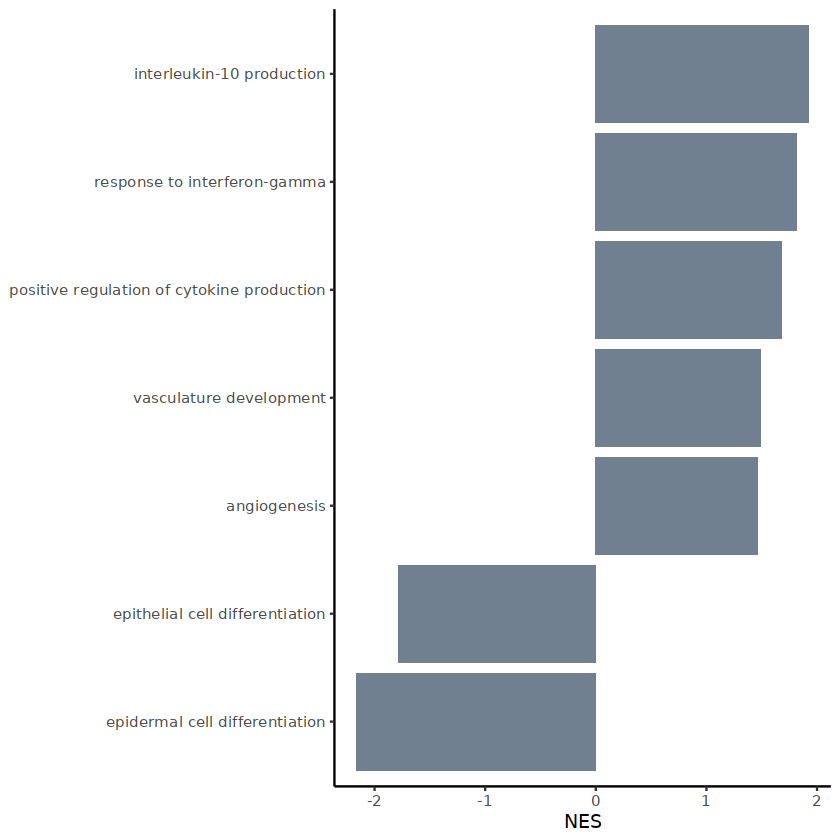

In [314]:
plot_df %>% 
    filter(Description %in% focus_terms) %>%
    arrange(NES) %>%
    mutate(Description = factor(Description, levels=Description)) %>%
    ggplot(aes(x=NES, y=Description, fill=ifelse(NES > 0, "steelblue", "chocolate"))) +
        geom_bar(stat='identity', orientation = 'y', show.legend = F, fill='slategray') +
        theme(axis.title.y = element_blank())
ggsave("final_figs/fig5/new_gene/go_enrichment_barplot.pdf", height=4, width=8)

In [27]:
plot_df = read.csv(paste0("final_figs/fig5/new_gene/go_enrichment_lfc_nosimplify_", "All", ".csv"))

In [28]:
lfc_vector = gene_df$lfc
names(lfc_vector) = rownames(gene_df)
lfc_vector <- sort(lfc_vector, decreasing = TRUE)

In [200]:
term_lfcs = lapply(focus_terms, function(term){
    genes = str_split(plot_df[plot_df$Description == term,'core_enrichment'], "/")[[1]]
    df = data.frame(gene=genes,
               lfc=lfc_vector[genes],
               go_term=term) %>%
        arrange(desc(abs(lfc))) %>%
        mutate(gene=factor(gene, levels=gene))
    df = df[1:min(15, nrow(df)),]
})

In [201]:
names(term_lfcs) = focus_terms

In [212]:
for (term in focus_terms){
    df = term_lfcs[[term]]
    ggplot(df, aes(x=gene, y=lfc)) +
        geom_bar(stat='identity', fill=ifelse(term %in% focus_terms[1:2], 'steelblue', 'brown3'), color='black', linewidth=0.2) +
        labs(title=term) +
        theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1), plot.title = element_text(hjust=0.5, size=10), 
              text = element_text(size=8), axis.title.x = element_blank())
    ggsave(paste0("final_figs/fig5/term_barplot_", term, ".pdf"), height=60, width=40, units = 'mm')
}

# Per comb graphs

In [219]:
full_genedata = lapply(3:7, function(i){
    pop = immune_pops[i]
    read.csv(paste0("final_figs/fig5/new_gene/", pop, "_genedata.csv"), row.names=1) %>% 
        cbind(source_index=i) %>% as.matrix
}) %>% 
    do.call(rbind, .) %>% 
    as.data.frame %>% 
    mutate(immune=immune_pops[source_index], epithelial="Tumor cells") %>% 
    mutate(pic=paste(immune, epithelial, sep=".")) %>%
    rownames_to_column("gene") %>%
    mutate(gene = str_split_i(gene, "\\.", 1))

In [217]:
full_genedata$se = with(full_genedata, 2.576 * Sim_SD / (1000 ** 0.5))

In [57]:
pic_counts = sapply(immune_pops, function(pop){sum(parser_immune[analyzed_pics] == pop)})

In [291]:
per_comb_obs_exp = function(focus_gene){
    
    gene_df = full_genedata %>% 
        filter(gene == focus_gene) %>%
        mutate(immune_exp=Simulated_mean * (1 - epi_imm_ratio), 
               epithelial_exp=Simulated_mean * epi_imm_ratio) %>%
        dplyr::select(Observed_mean, immune_exp, epithelial_exp, immune, epithelial, pic, gene) %>%
        melt(variable.name = "source", value.name = "norm_mean") %>%
        mutate(obs_exp = ifelse(source == "Observed_mean", "Observed", "Expected"),
               fill=factor(ifelse(source == 'immune_exp', 
                                  group.colors[immune], 
                                  ifelse(source == "epithelial_exp", 
                                         group.colors['Tumor cells'], 
                                         "slategray")),
                           levels=c(group.colors, "slategray")))
    
    
    
    p1 = ggplot(gene_df, aes(x=obs_exp, y=norm_mean, fill=fill)) +
        geom_bar(stat='identity', position='stack', color='black', show.legend = F) +
        geom_errorbar(data=full_genedata %>% filter(gene == focus_gene) %>% mutate(obs_exp="Expected"),
                      aes(ymin=pmax(0, Simulated_mean - Sim_SD), ymax=Simulated_mean + Sim_SD, y=0, fill=NA), width=0.1) +
        scale_fill_identity() +
        facet_grid(~pic) +
        labs(title = focus_gene) +
        theme(strip.background = element_blank(), strip.text.x = element_blank(), plot.title = element_text(hjust=0, size=20),
              axis.title.x=element_blank(), axis.line.x=element_blank(), axis.ticks.x=element_blank(), 
              axis.text.x=element_blank())

    draw_dot = function(dot_df, side){
        ggplot(dot_df, aes(x=x, y=y, fill=fill)) +
        geom_point(color='black', pch=21, show.legend = F, size=10) +
        scale_fill_identity() + 
        facet_grid(~ pic) + 
        theme_void() +
        ylab("          ") +
        theme(strip.background = element_blank(), strip.text.x = element_blank(), axis.title.y = element_text(hjust = 1))
    }

    p2 = data.frame(x=0, y=0, pic=unique(gene_df$pic), fill=group.colors[str_replace(unique(gene_df$pic), '\\..*', '')]) %>%
        draw_dot

    p3 = data.frame(x=0, y=0, pic=unique(gene_df$pic), fill=group.colors[str_replace(unique(gene_df$pic), '.*\\.', '')]) %>%
        draw_dot

    p_unified = grid.arrange(p1, p2, p3, nrow=3, heights=c(19,1,1))
}

In [311]:
full_genedata %>% dcast(gene ~ pic, value.var='full_adj_pval', fun.aggregate = function(x){x[1]}) %>%
    write_csv("final_figs/fig5/new_gene/pvalues.csv")

Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”
Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”
Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


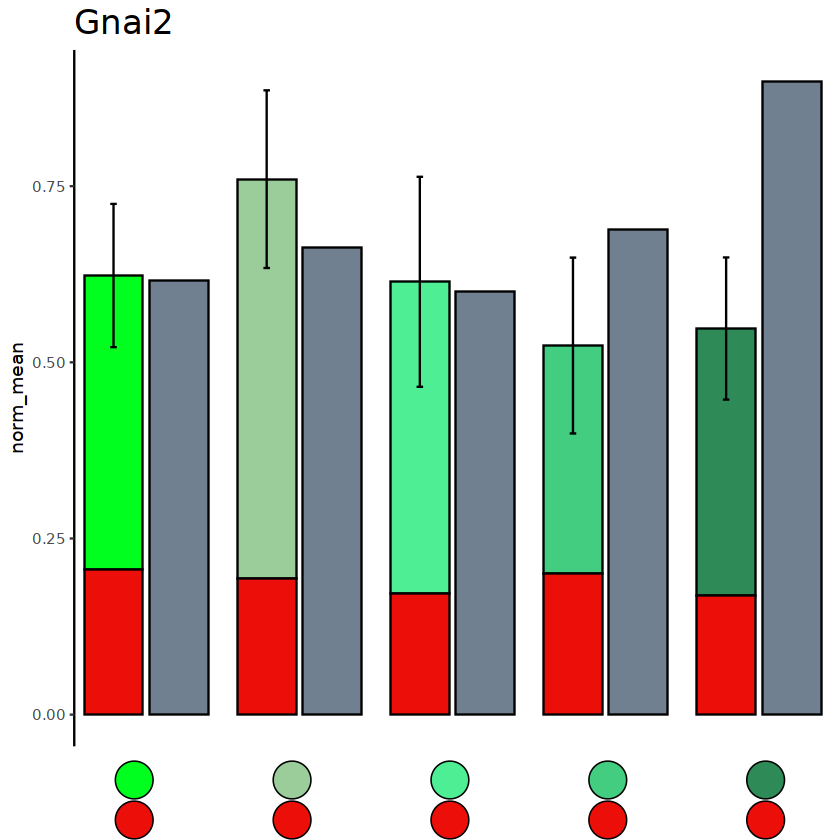

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


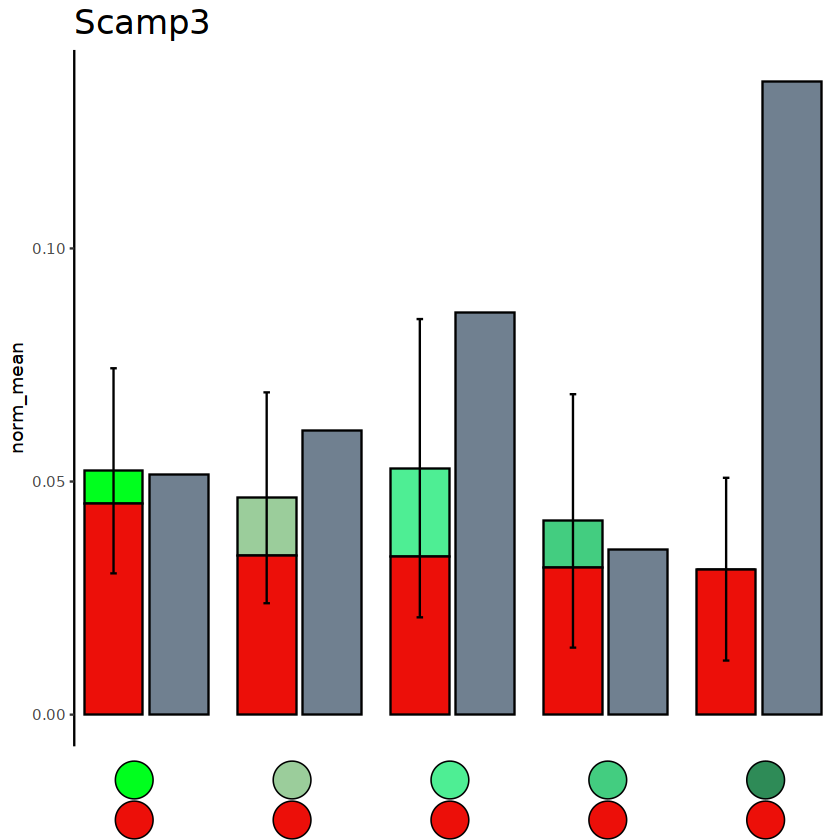

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


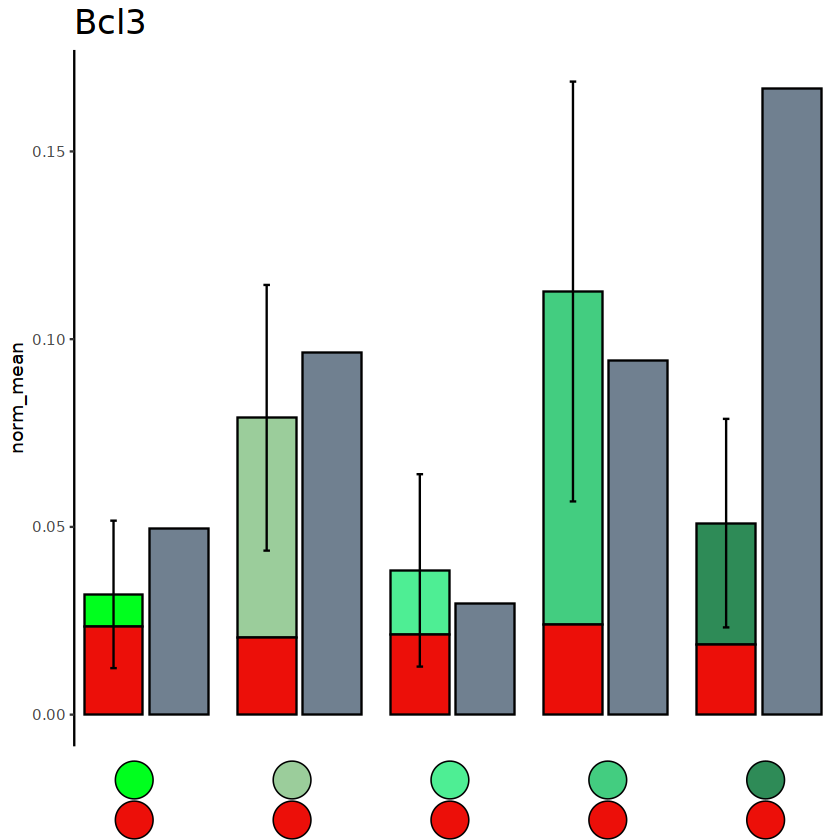

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


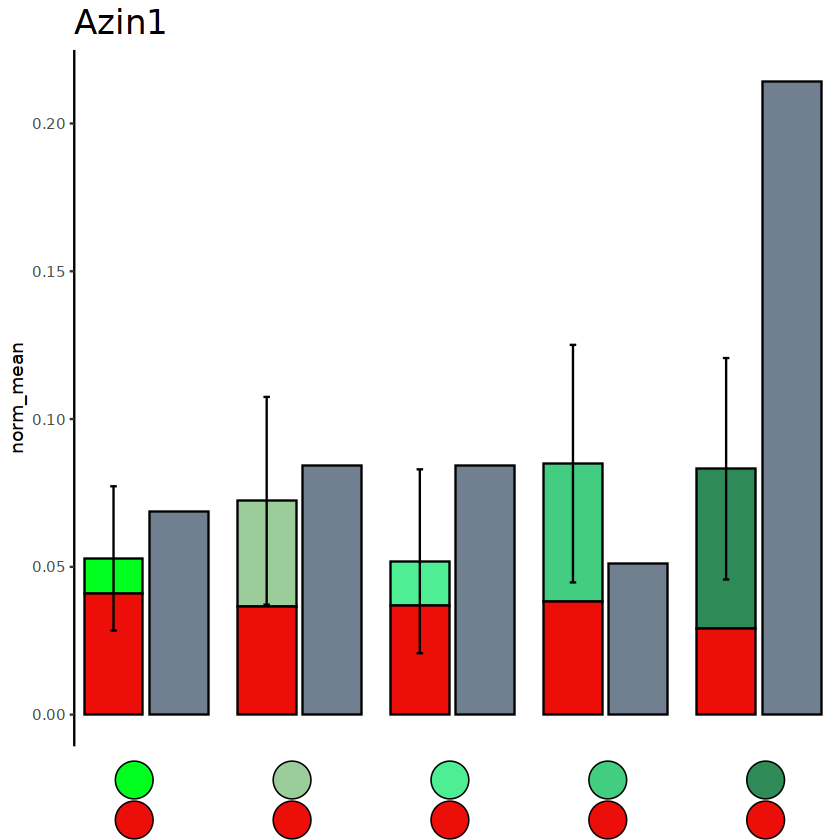

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


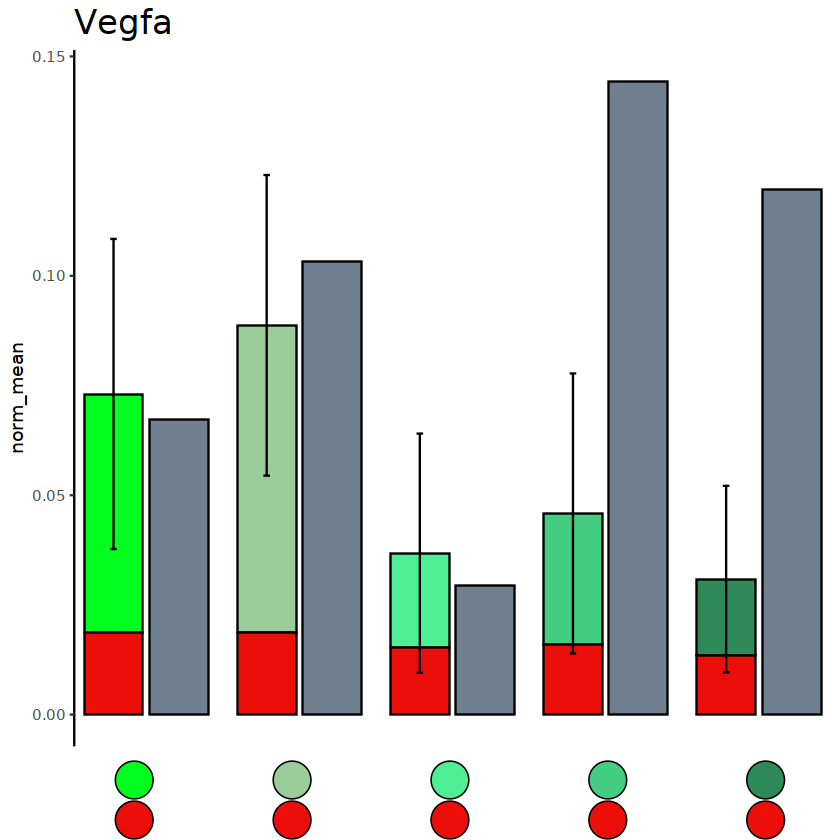

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


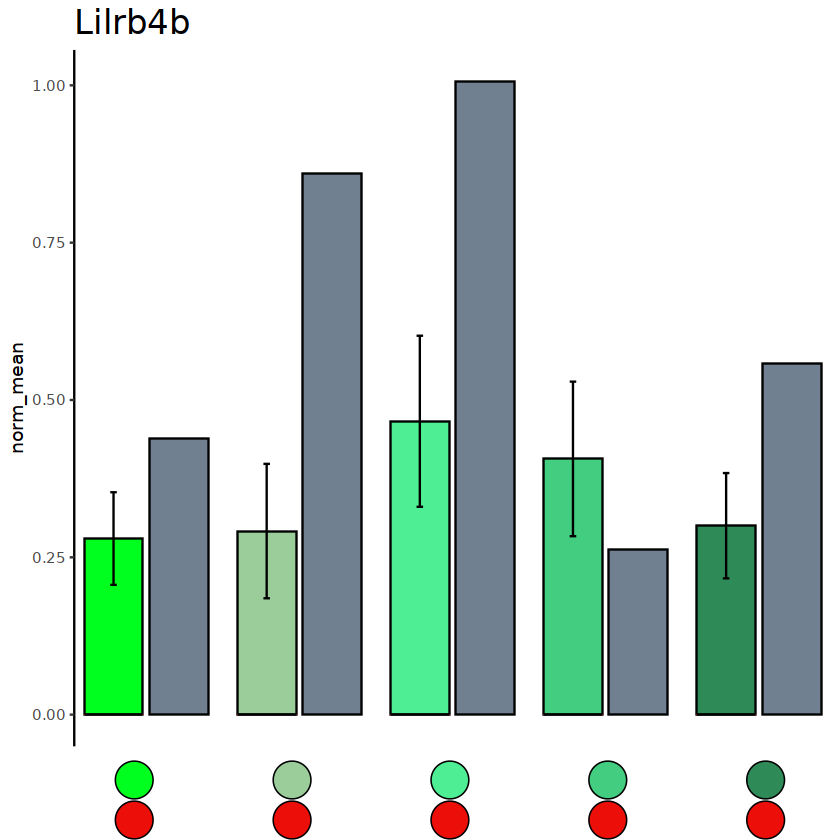

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


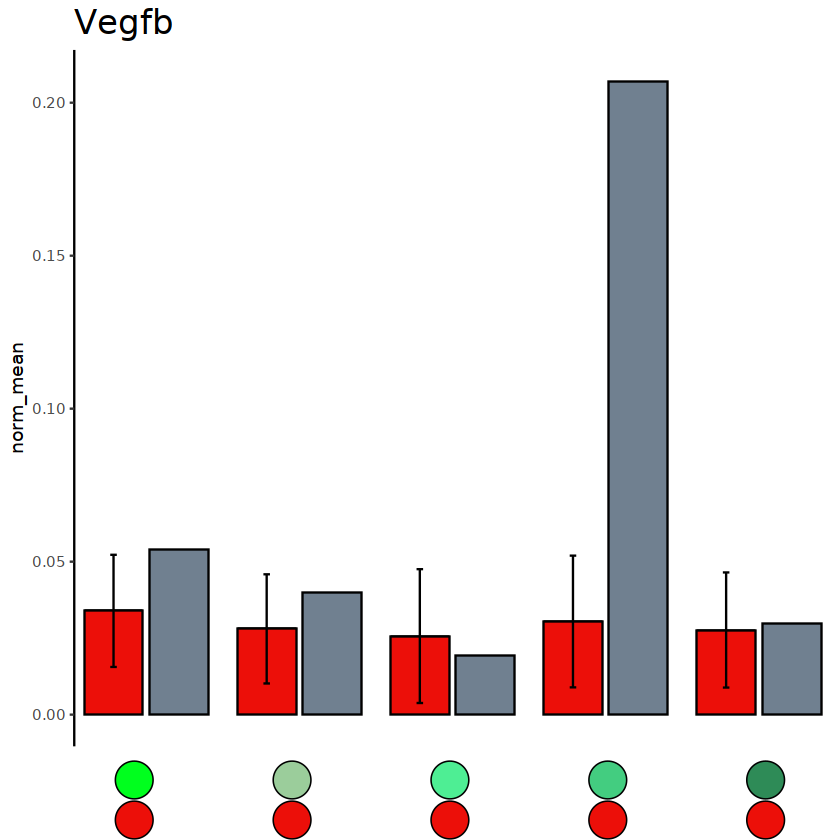

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


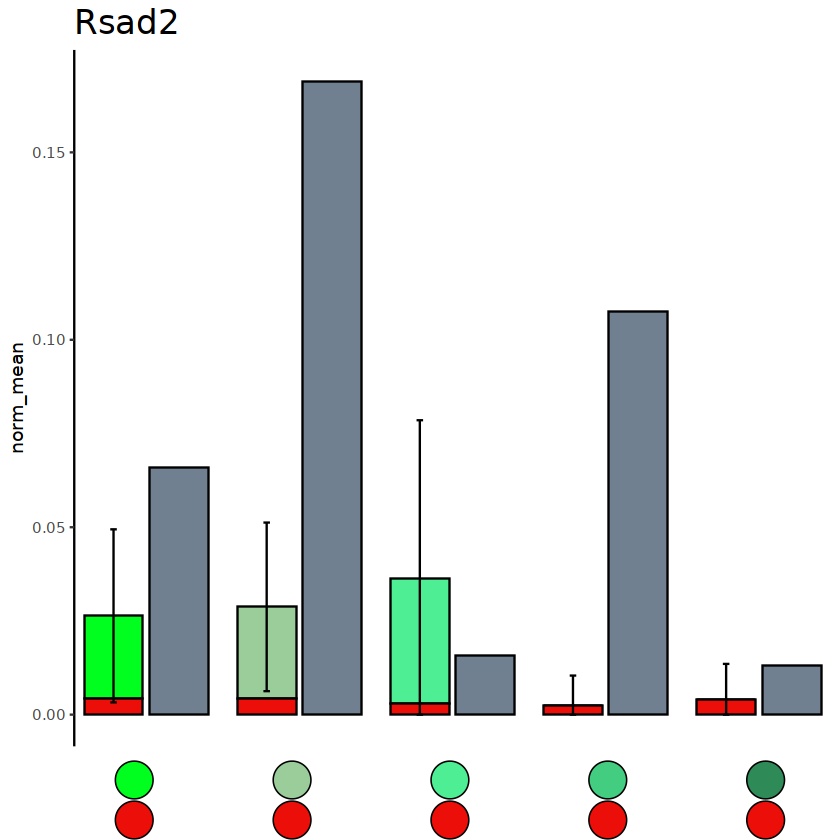

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


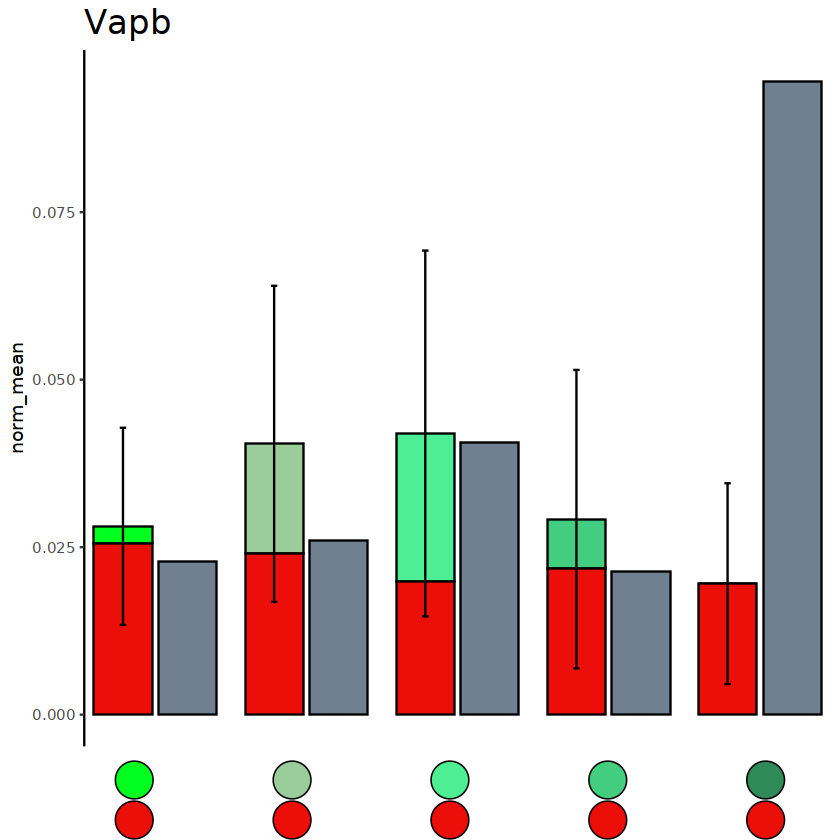

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


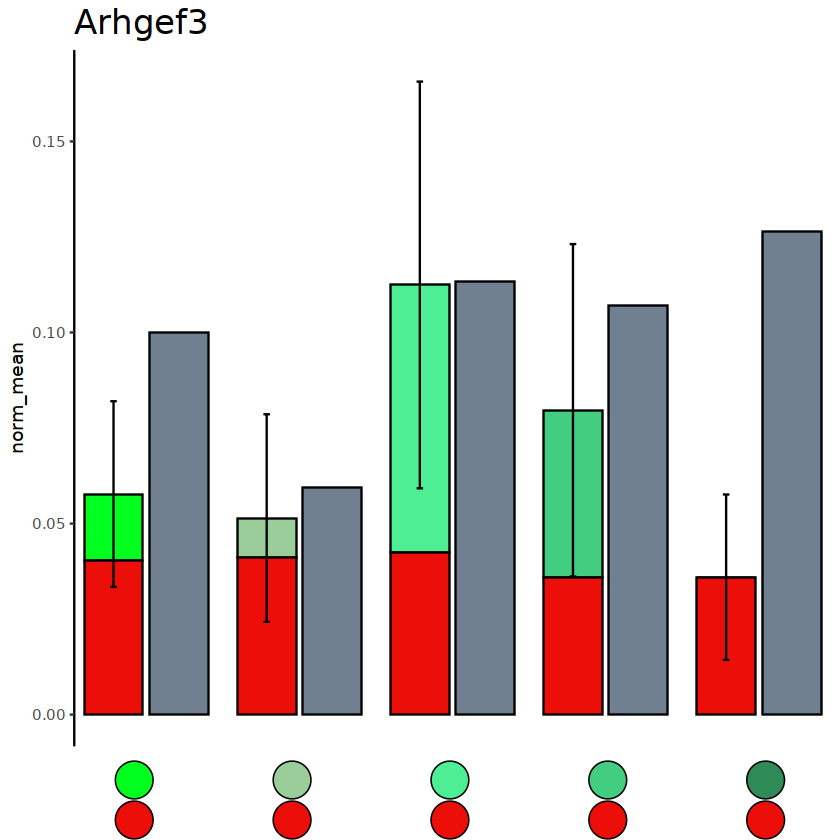

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


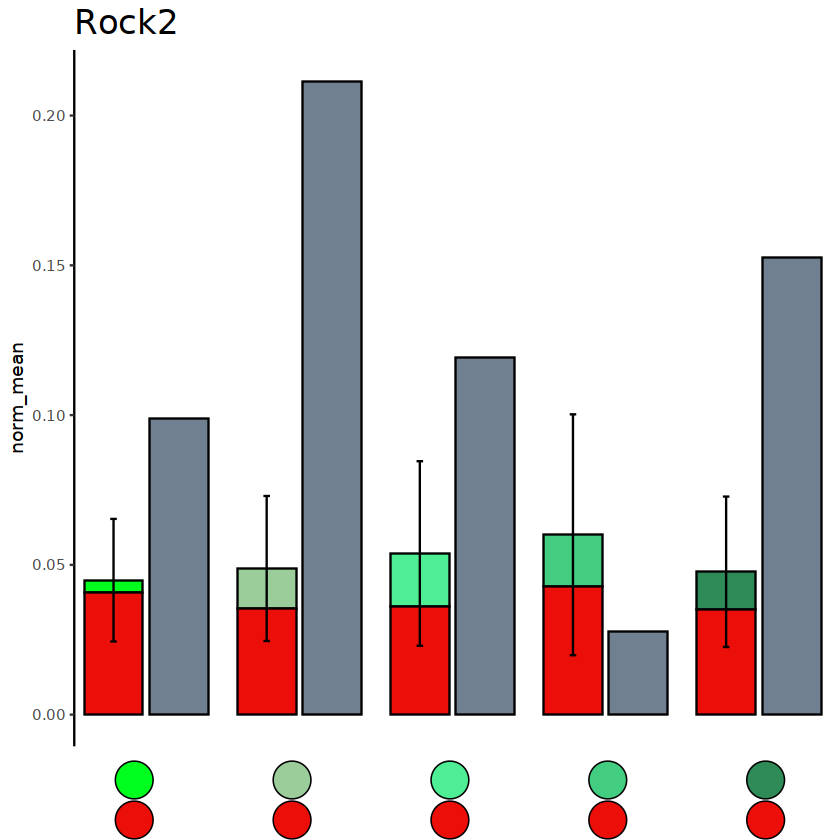

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


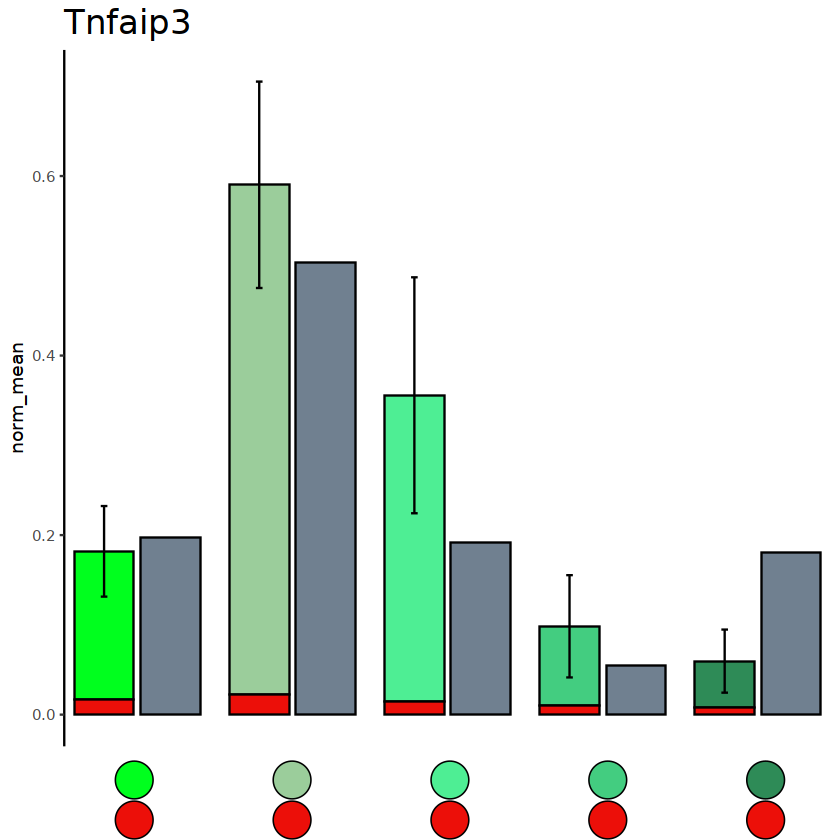

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


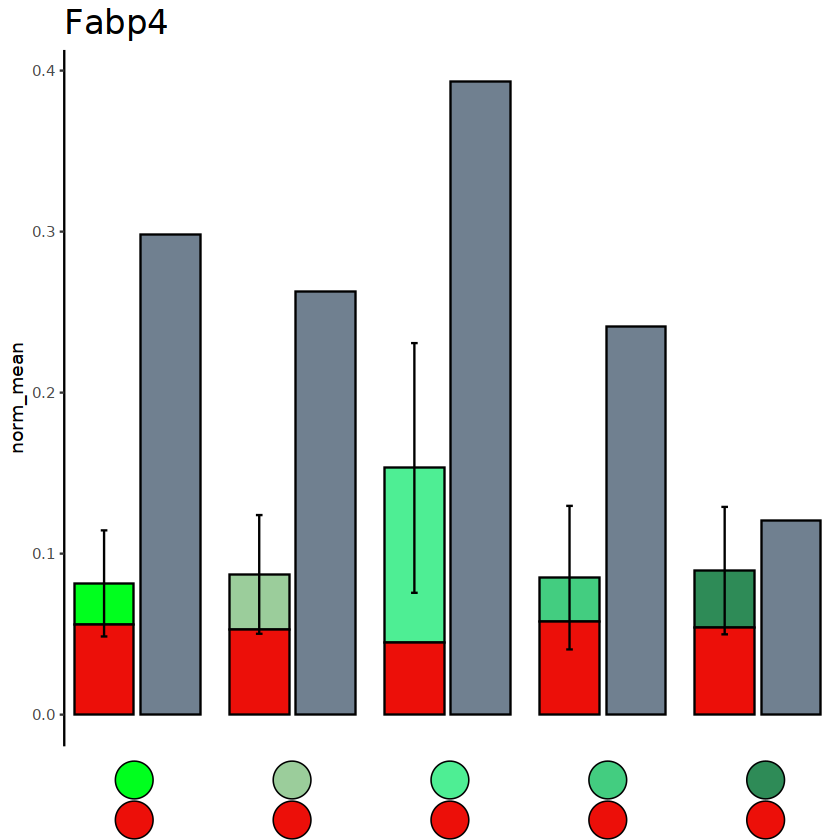

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


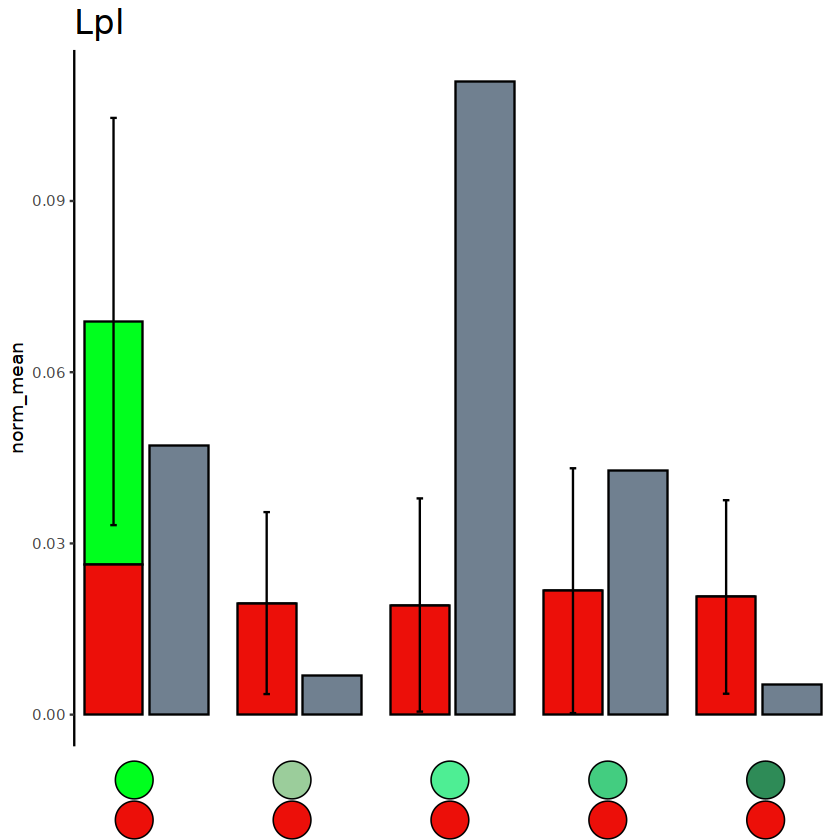

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


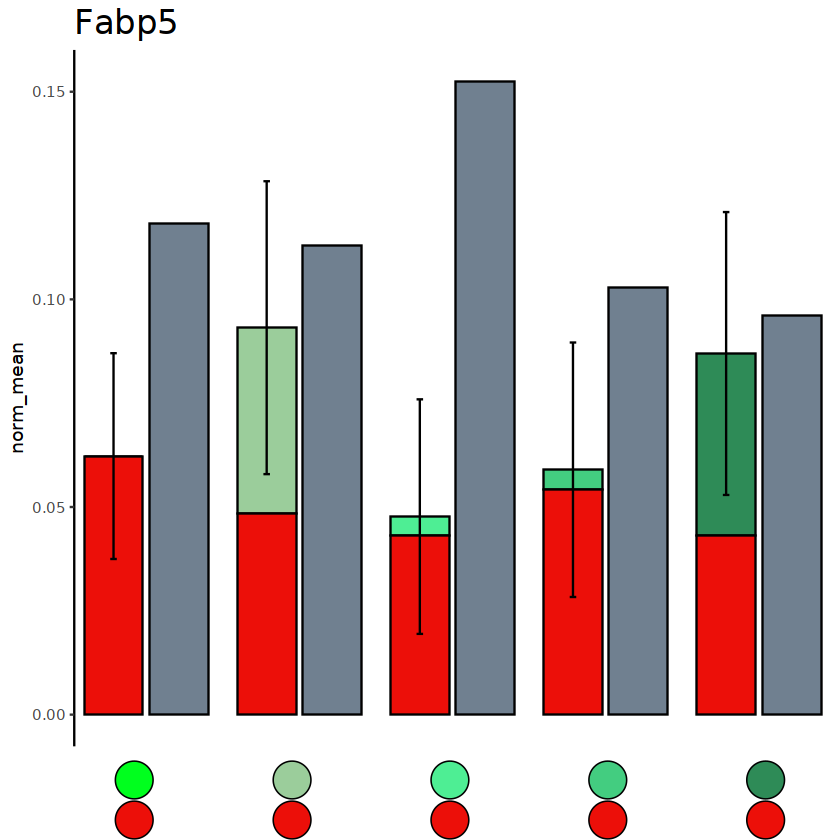

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


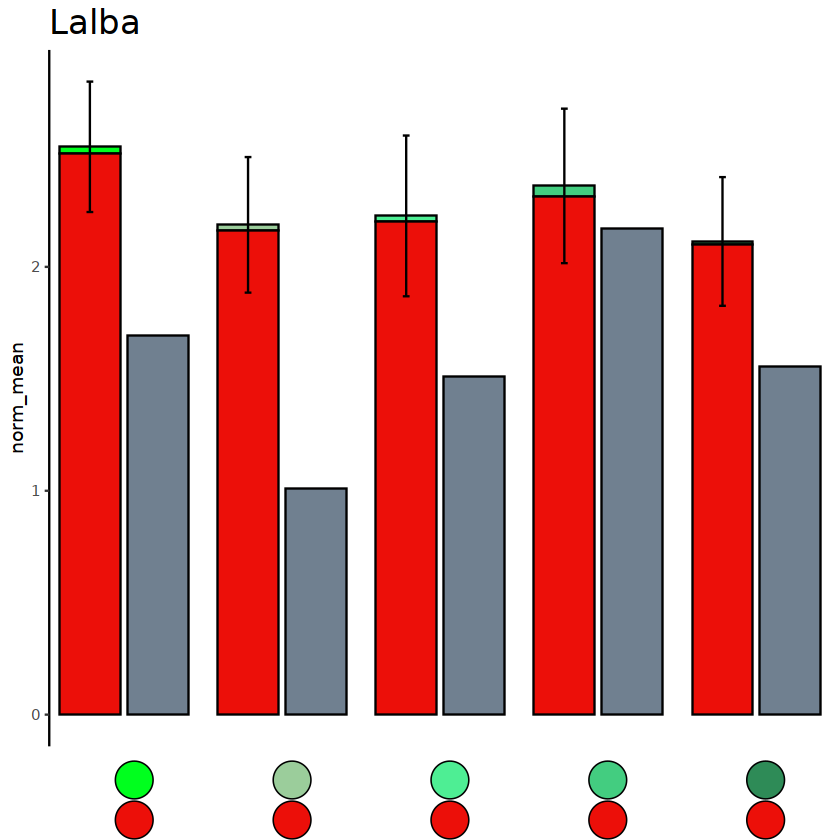

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


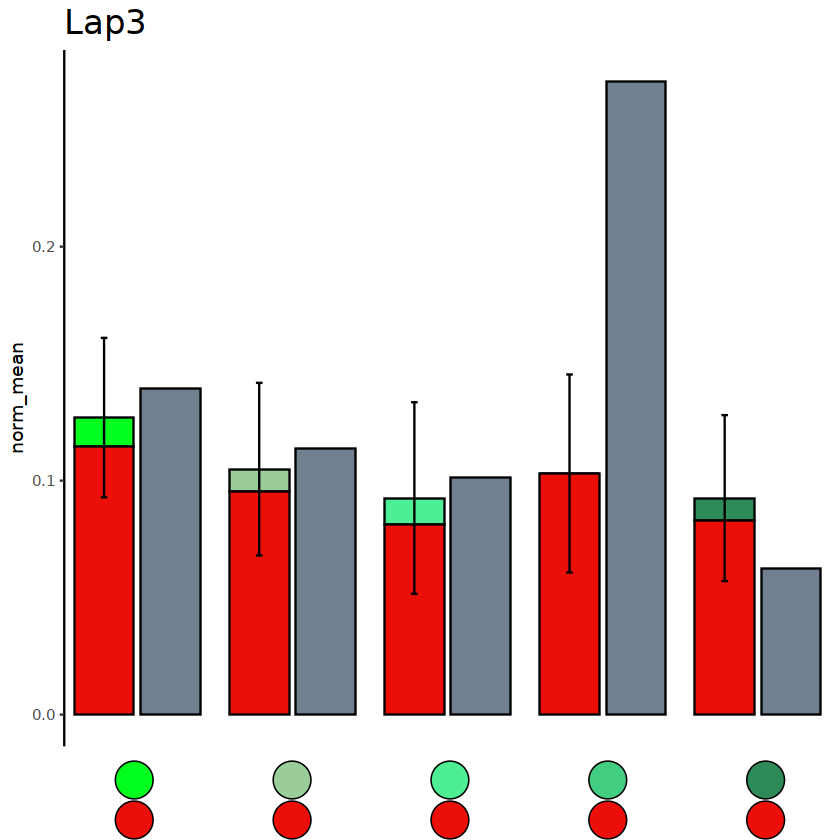

Saving 6.67 x 6.67 in image
Using immune, epithelial, pic, gene as id variables

Warning message in geom_errorbar(data = full_genedata %>% filter(gene == focus_gene) %>% :
“Ignoring unknown aesthetics: fill”


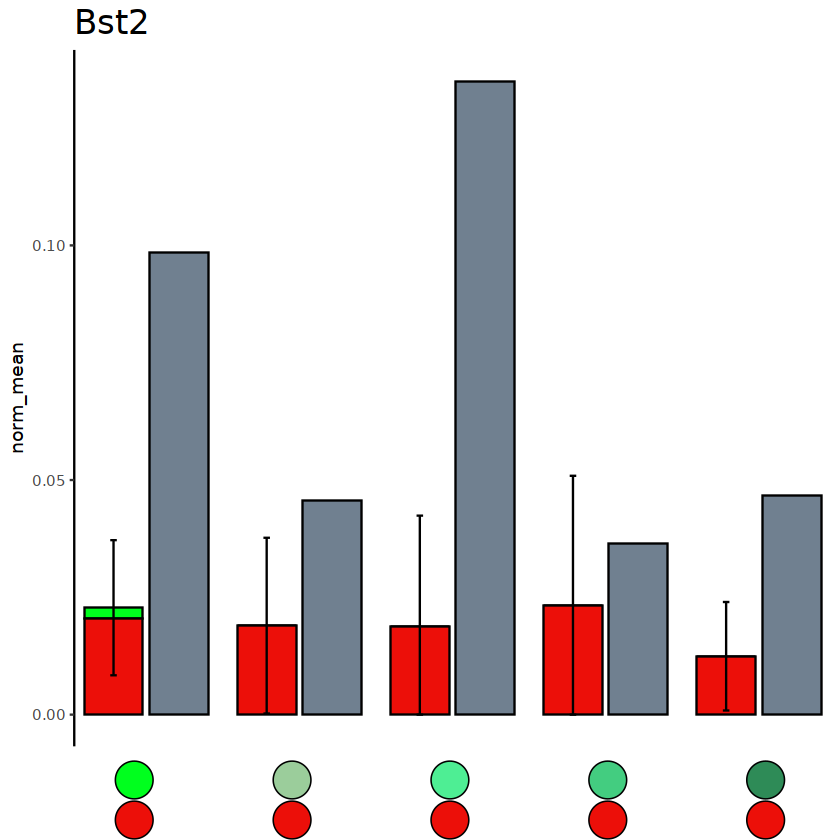

Saving 6.67 x 6.67 in image


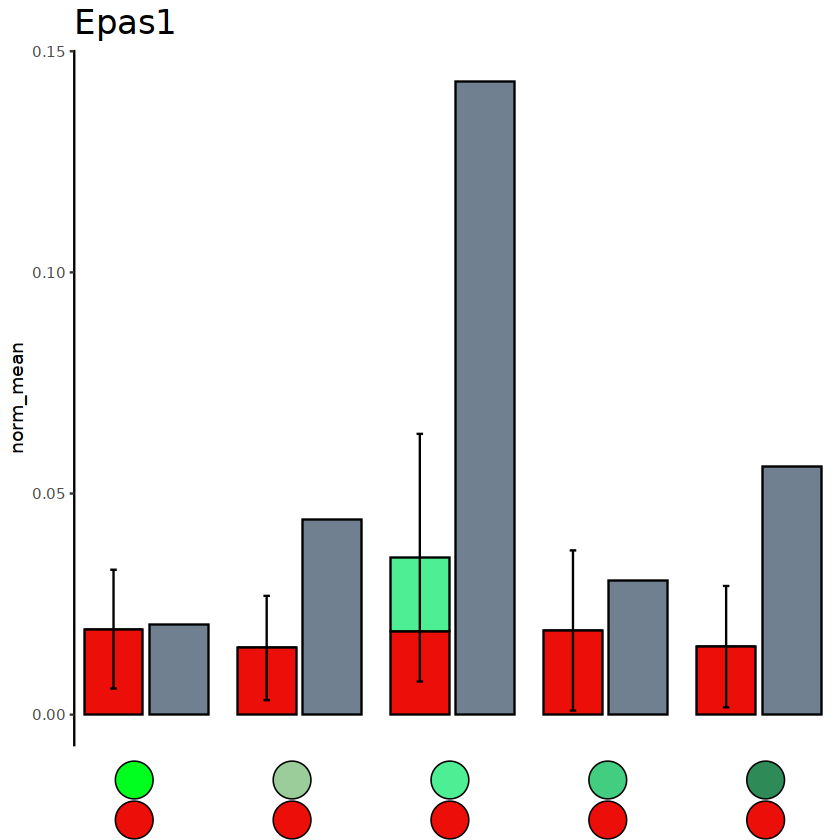

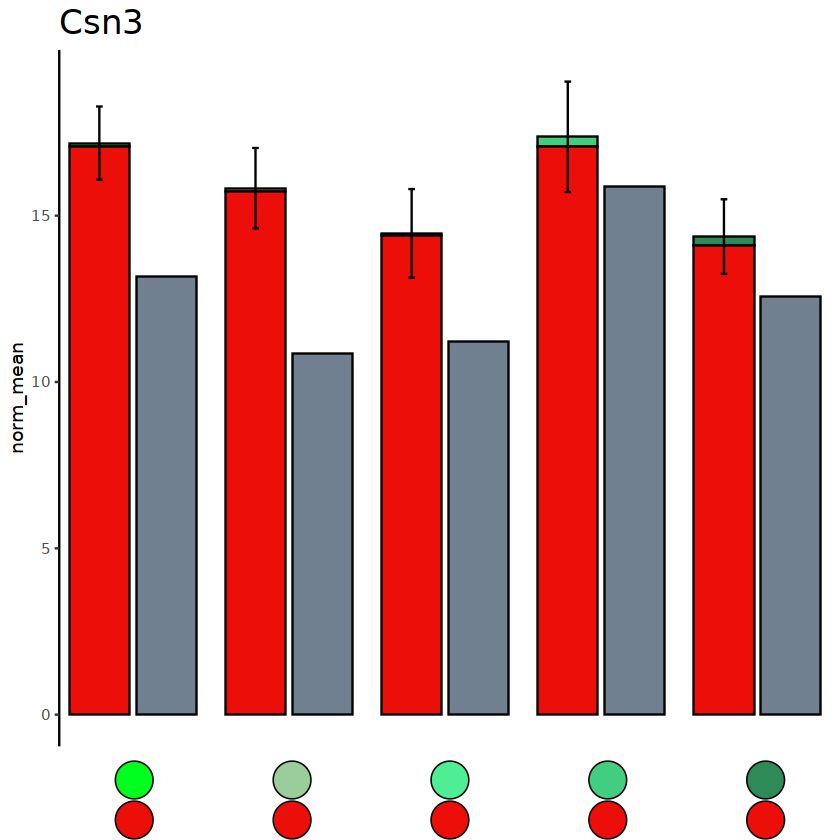

In [294]:
focus_genes = c('Gnai2', "Scamp3", "Bcl3", "Azin1", "Vegfa", "Lilrb4b", "Vegfb", "Rsad2", "Vapb", "Arhgef3", "Rock2", "Tnfaip3", 
                "Fabp4", "Lpl", "Fabp5", "Lalba", "Lap3", "Bst2", "Epas1", "Csn3")
for (gene in focus_genes){
    p = per_comb_obs_exp(gene)
    ggsave(paste0("final_figs/fig5/new_gene/gene_comb/", gene, ".pdf"), plot=p)
}

In [238]:
full_genedata = lapply(c(immune_pops[3:7], "TANs_merged_1012w"), function(pop){
    read.csv(paste0("final_figs/fig5/new_gene/", pop, "_genedata.csv"), row.names=1) %>% 
        cbind(source_pops=pop) %>% as.matrix
}) %>% 
    do.call(rbind, .) %>% 
    as.data.frame %>% 
    rownames_to_column('gene') %>%
    mutate(pic=paste(source_pops, "Tumor cells", sep="."), gene = str_split_i(gene, "\\.", 1)) %>%
    dplyr::select(c(pic, colnames(.)[1:8]))

In [240]:
write_csv(full_genedata, "annotations/unified_gene_pics.csv")